In [1]:
import sys
sys.path.append('PyGazeAnalyser-master\\pygazeanalyser')

#pygaze imports
from pygaze import *
from edfreader import *
from gazeplotter import *

#other python libs import
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

#csv import 
import csv
import cv2

### CSV File

'1'

In [17]:
partic_id = 'G036'
game_nr  = 1
trial_nr = 1

print(partic_id[-2:])

36


### Particpant ID: G036

#### Using Gazeplotter

[]

In [6]:
#participant details
partic_id = 'G036'
game_nr  = 4

#read data using read_edf function
fname = 'Participant Data/'+str(partic_id)+ '/' + str(partic_id) + \
         str('_') + str(game_nr) + str('.asc') #path of the ASC file

# Stimulus phase
start_message = 'SYNCTIME'
stop_message = 'CC'
data = read_edf(fname,start='SYNCTIME',stop='CC') #start and stop indicators can be found in the ASC file

def read_data(partic_id,game_nr,phase='stimulus'):
    """
    three phases: fixation, stimulus, reward
    
    """
    fname = 'Participant Data/'+str(partic_id)+ '/' + str(partic_id) + \
             str('_') + str(game_nr) + str('.asc') #path of the ASC file

    if phase =='stimulus':
        start_message = 'SYNCTIME'
        stop_message = 'CC'
    elif phase =='fixation':
        start_message = 'TRIALID'
        stop_message = 'SYNCTIME'
    elif phase =='reward':
        start_message = 'CC'
        stop_message = 'TRIALEND'
    data = read_edf(fname,start=start_message,stop=stop_message) #start and stop indicators can be found in the ASC file
    return data

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


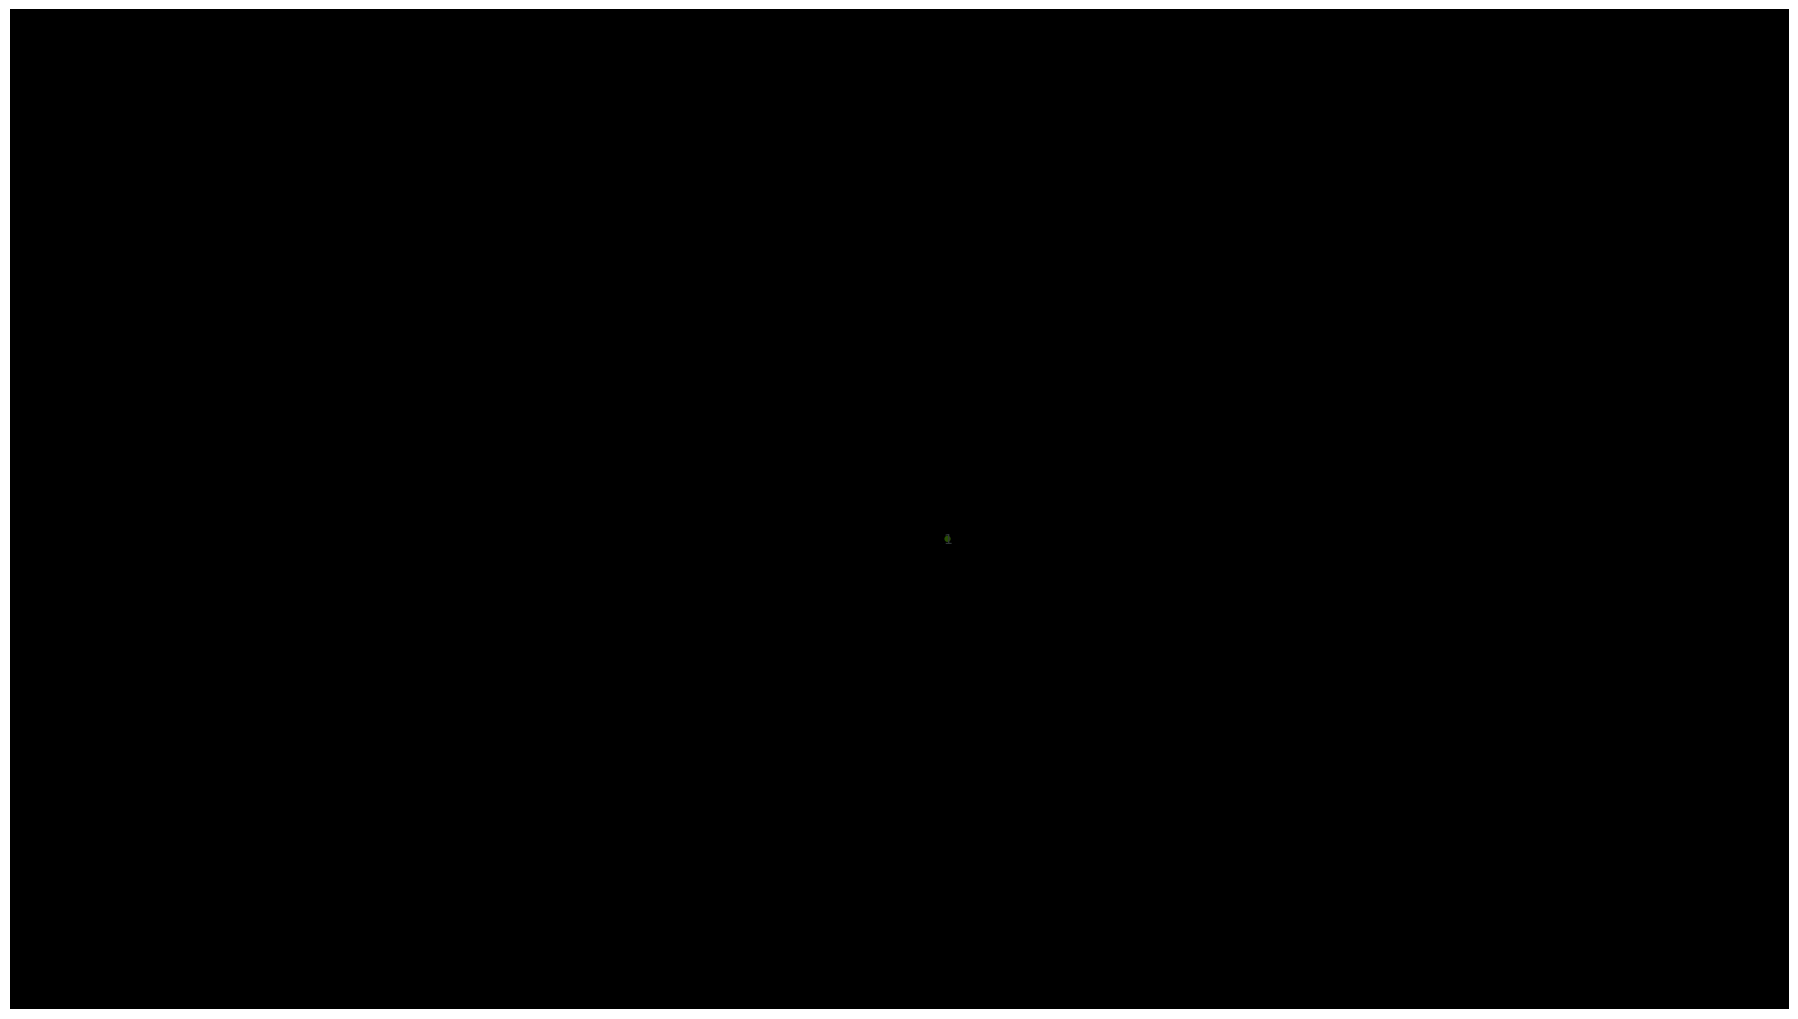

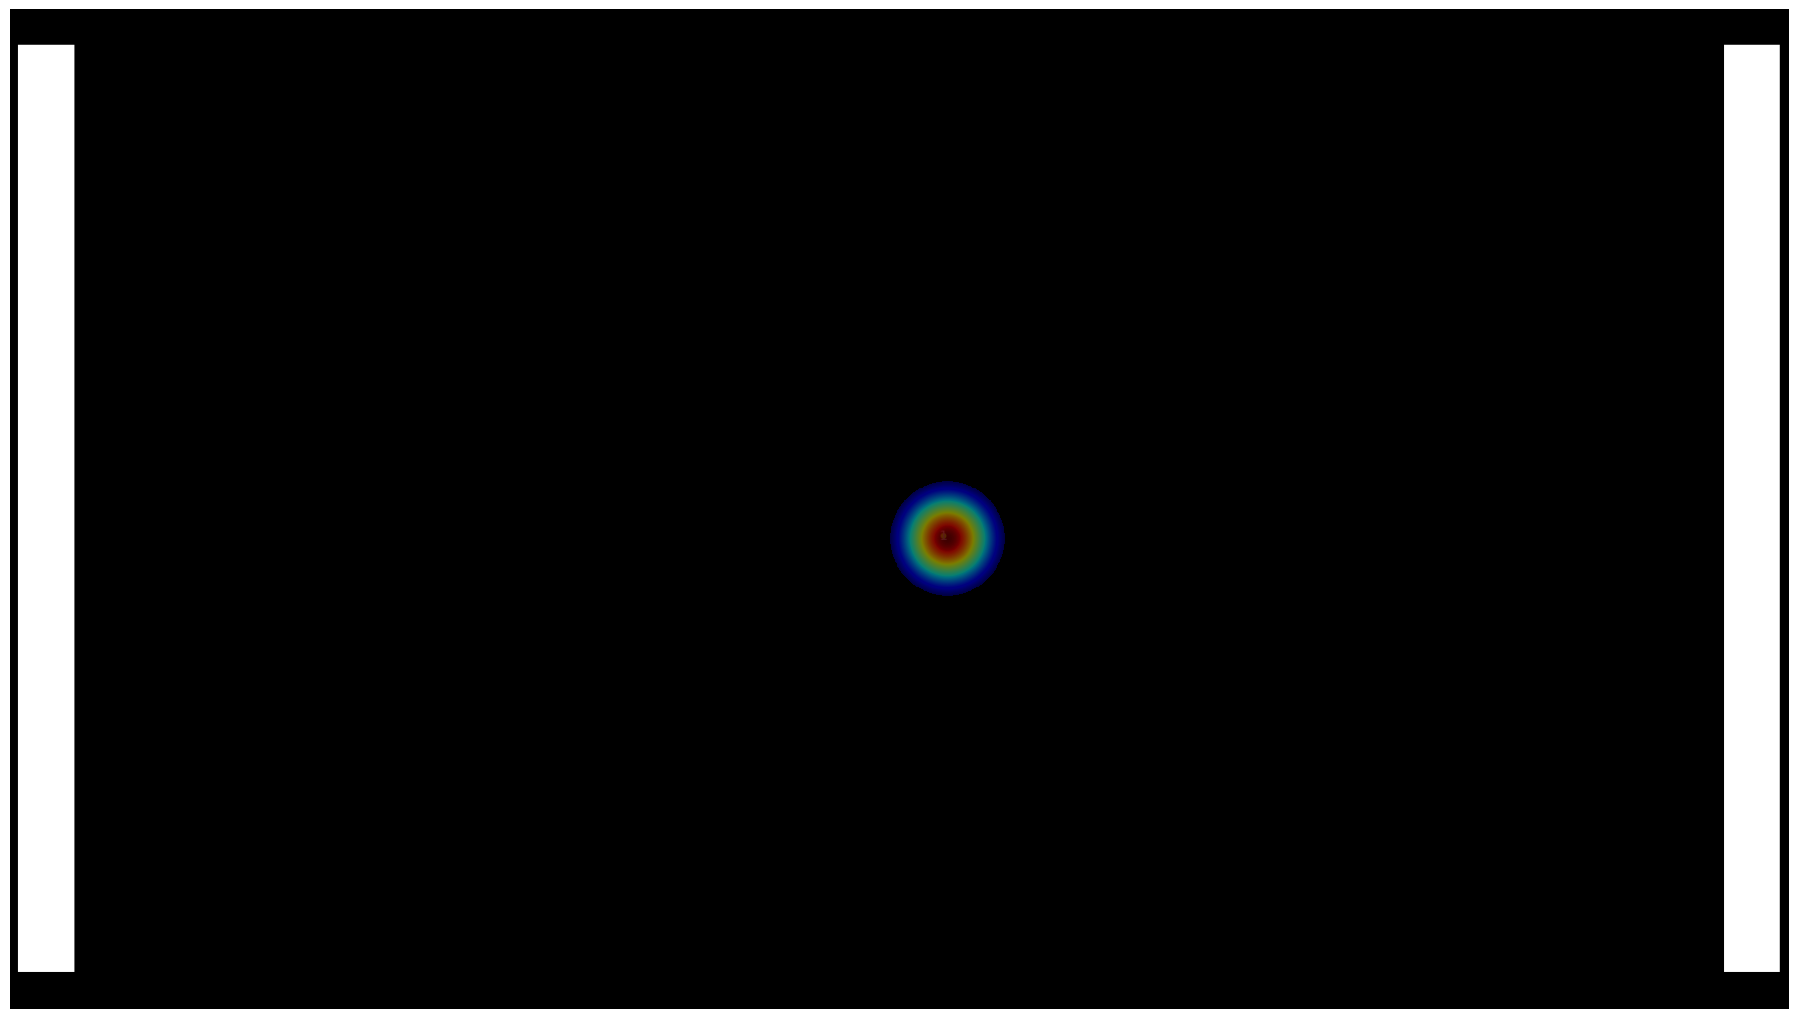

In [52]:

trial_nr = 12
#saccades and fixations
saccades = np.array(data[trial_nr]['events']['Esac'])
fixations = np.array(data[trial_nr]['events']['Efix'])
dispsize= (1919,1079) # (px,px) size of screen 

# draw saccadic scanpath and save fig

#saves as id+game_nr+trial_nr+current date time
savefilename = 'output_images/' + str(partic_id) + '_game_'+str(game_nr)+'_' \
               + str(trial_nr) + '_'+ time.strftime("%Y%m%d-%H%M%S")
fig = draw_scanpath(fixations, saccades, dispsize, imagefile=None, alpha=0.5, savefilename=savefilename)

#draw heatmap on top of it
img_file = savefilename + '.png'
fig_heatmap = draw_heatmap(fixations, dispsize, imagefile=img_file)
img_heatmap_file = savefilename + '_heatmap'
fig_heatmap.savefig(img_heatmap_file)



### Estimating Crosshair Position from Fixation Phase

In [7]:
def return_cross_pos(partic_id,game_nr,trial_nr):
    """
    Returns the averaged cross_hair position as calculated from the
    fixation time
    
    
    @Input:
    data : data during fixation time
    
    """
    
    fname = 'Participant Data/'+str(partic_id)+ '/' + str(partic_id) + \
         str('_') + str(game_nr) + str('.asc') #path of the ASC file
    data = read_edf(fname,start='TRIALID',stop='SYNCTIME') #fixation time
    Efix = np.array(data[trial_nr]['events']['Efix'])
    
    #check if Efix is 2D 
    if len(Efix.shape)>1:
        x_mean,y_mean = np.mean(Efix[:,-2]),np.mean(Efix[:,-1])
    
    elif Efix.size==0:
        x_mean,y_mean = 0, 0 # 0,0 for no Efix value
    
    else:
        x_mean,y_mean = Efix[-2:]

    return x_mean, y_mean

### OpenCV Manipulations 


In [8]:
def return_centroid_heatmap(image_load):
    """
    Finds circular contours in the image and returns the center
    
    @Input: image_load: Input image of the heatmap
    
    Returns: center (x,y); image_out (image with contours)
    """
    ## find number of blobs 

    #threshold
    _,thresh_image = cv2.threshold(image_load,10,255,cv2.THRESH_BINARY)#+cv2.THRESH_OTSU)cv2.threshold(img_gray, thresh, 150, 255, THRESH_BINARY);
    contours, hierarchy = cv2.findContours(thresh_image,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    center_list = [] #relevant contours 
    radius_list = [] #relevant radii 
    for cnt in contours:
        #check for circle enclosing contour
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        center = (int(x),int(y))
        radius = int(np.ceil((radius)))

        if radius <100:
            #draw circular contours
            cv2.circle(image_load,center,radius,(255,255,0),2)
            center_list.append([x,y])
            radius_list.append(radius)
            #cv2.drawContours(image_load,cnt,contourIdx=-1, color=(255, 255, 0), thickness=2,\
                         #lineType=cv2.LINE_AA)   
    
    return np.array(center_list),radius_list,image_load


center : [[998.         528.95349121]]


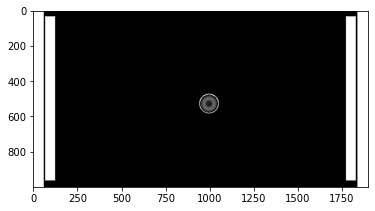

In [125]:
## TESTING THE ABOVE FN
image_load = cv2.imread(img_heatmap_file+'.png',0)
center,image_out = return_centroid_heatmap(image_load)

plt.imshow(image_out,cmap='gray')
print('center :',center)

### Plot - 'Inattention' vs Trial No

[[983.13861084 411.16744995]]
[[970.15966797 451.04174805]]
[[1065.68017578  315.67993164]]
[[1112.96582031  342.59942627]]


C:\Users\adith\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adith\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]
[]
[]
[[1075.90393066  482.55947876]]
[]
[[963.5 502.5]]
[[1070.27770996  445.5       ]]
[[998.         528.95349121]]
[[1061.07348633  511.26721191]]
[]
[[922.49230957 344.29400635]]


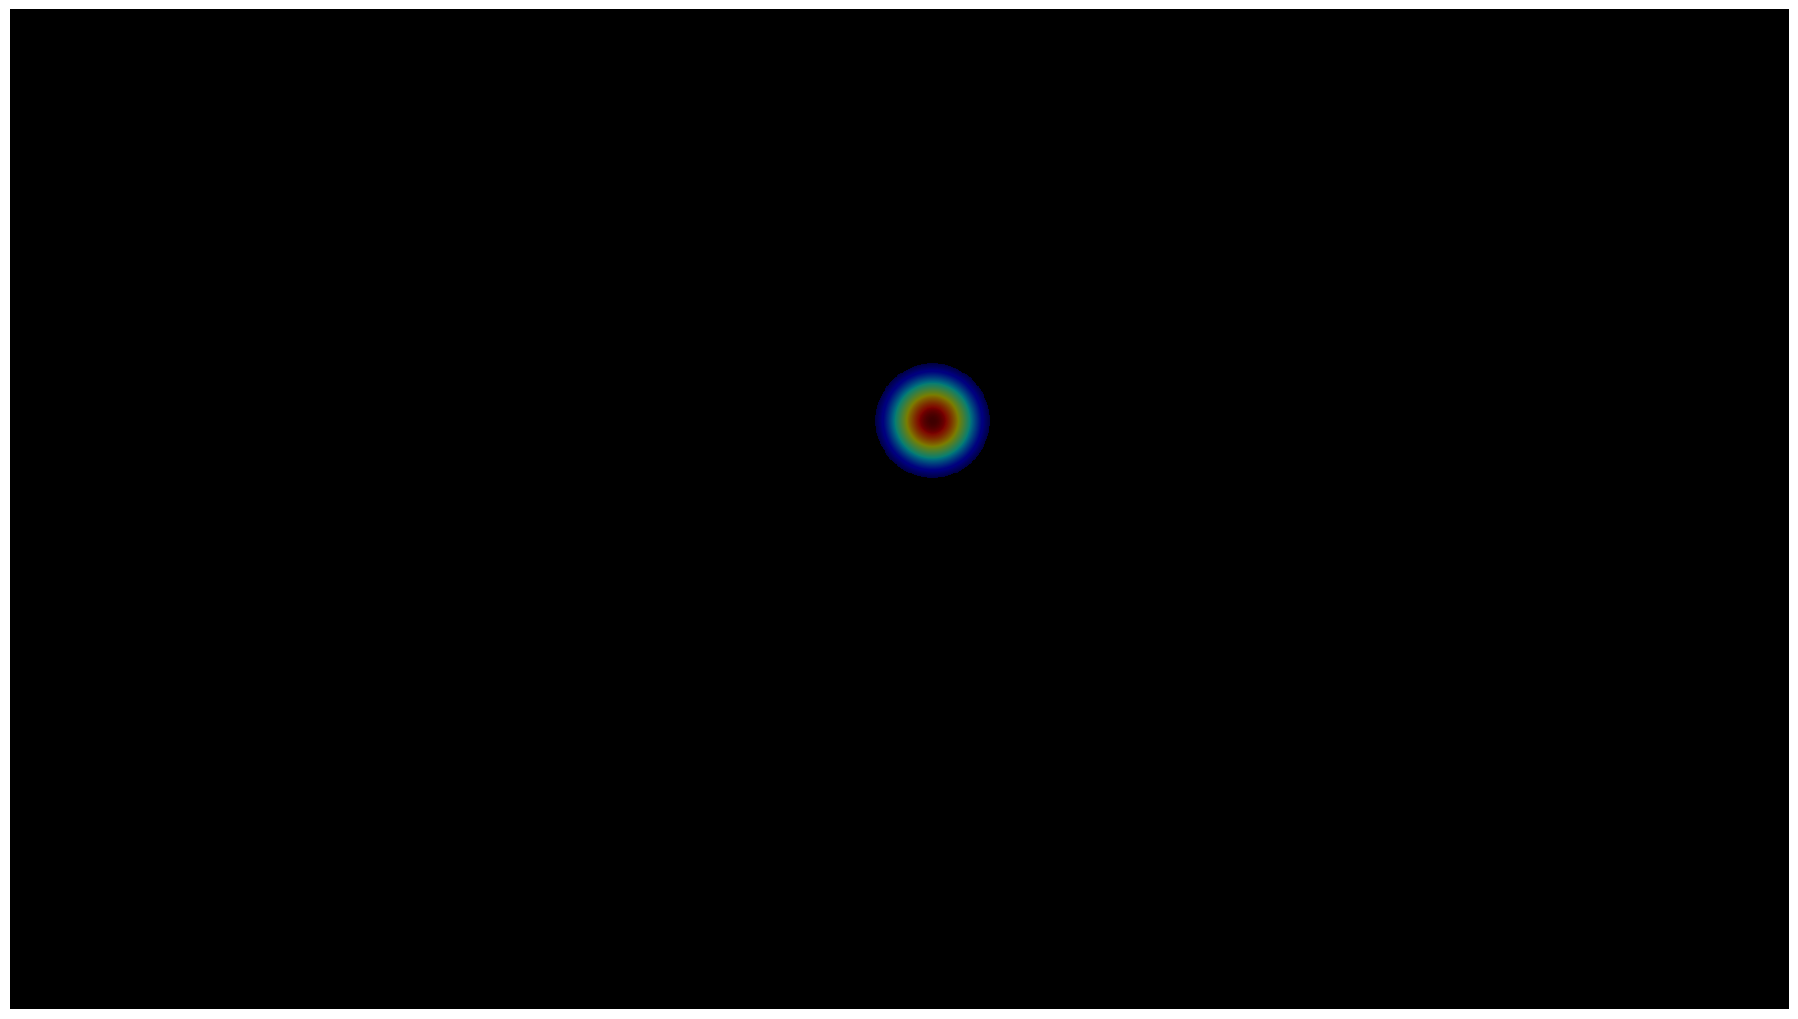

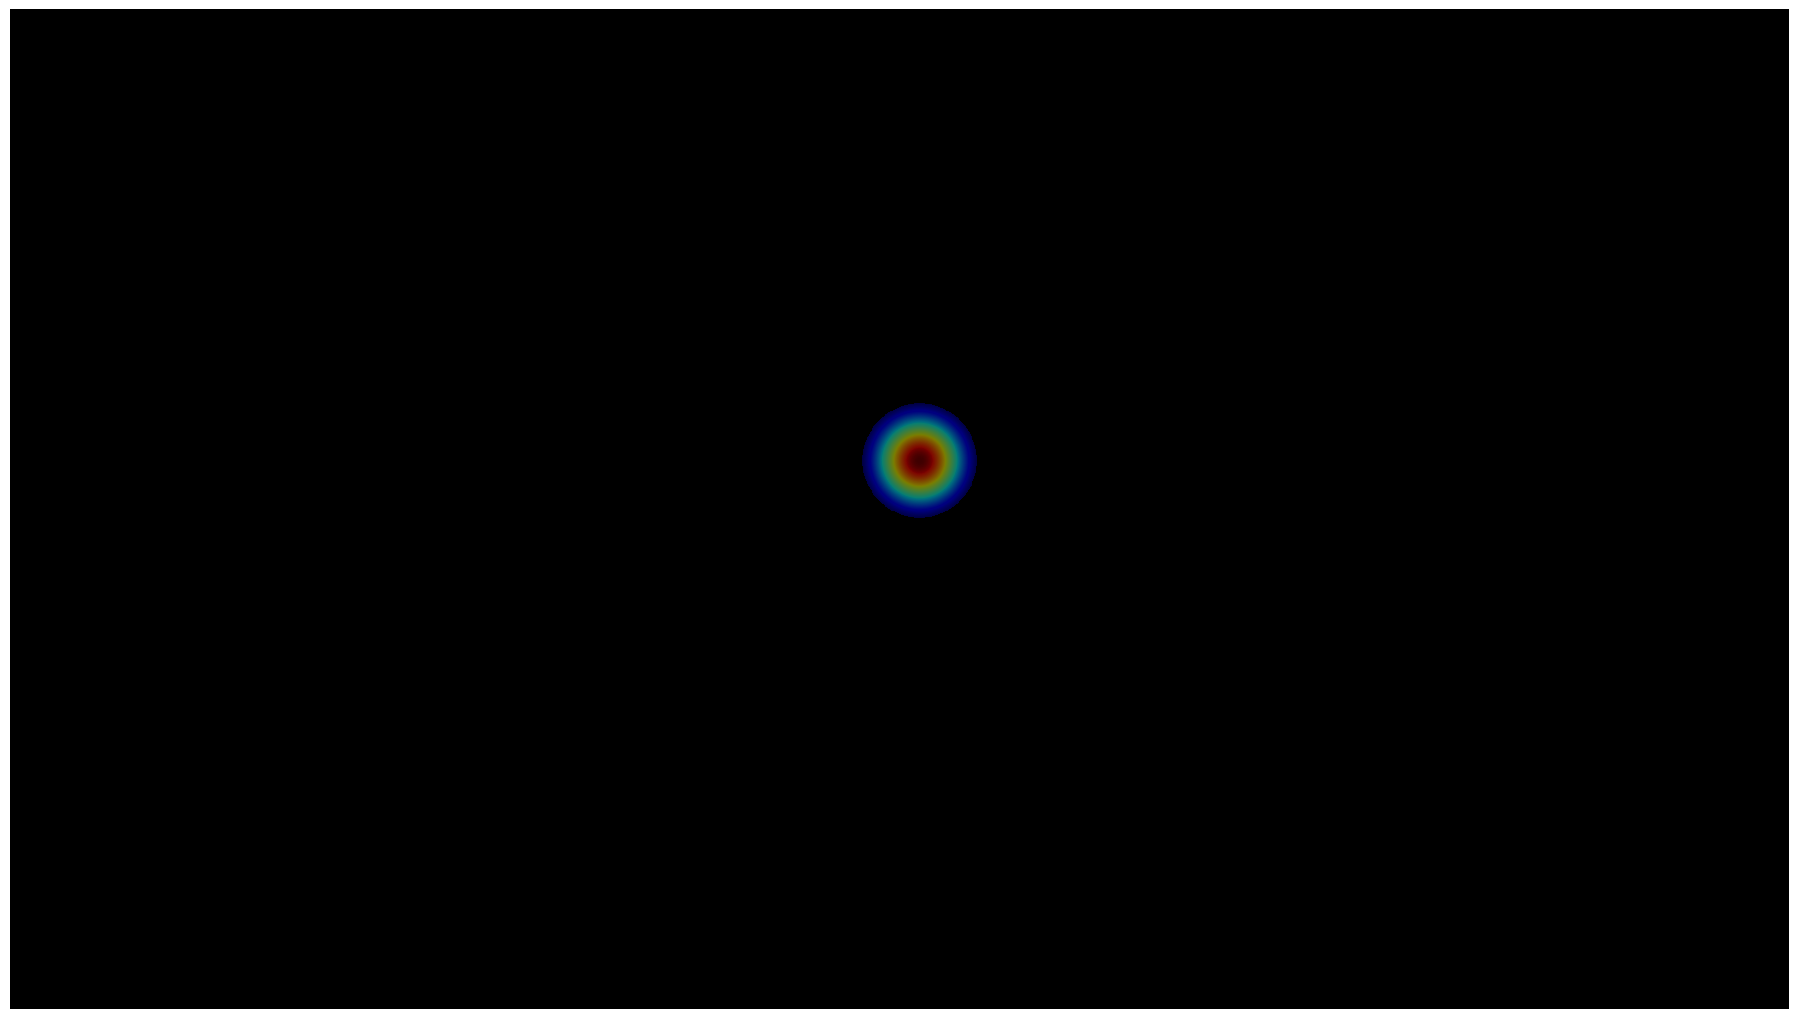

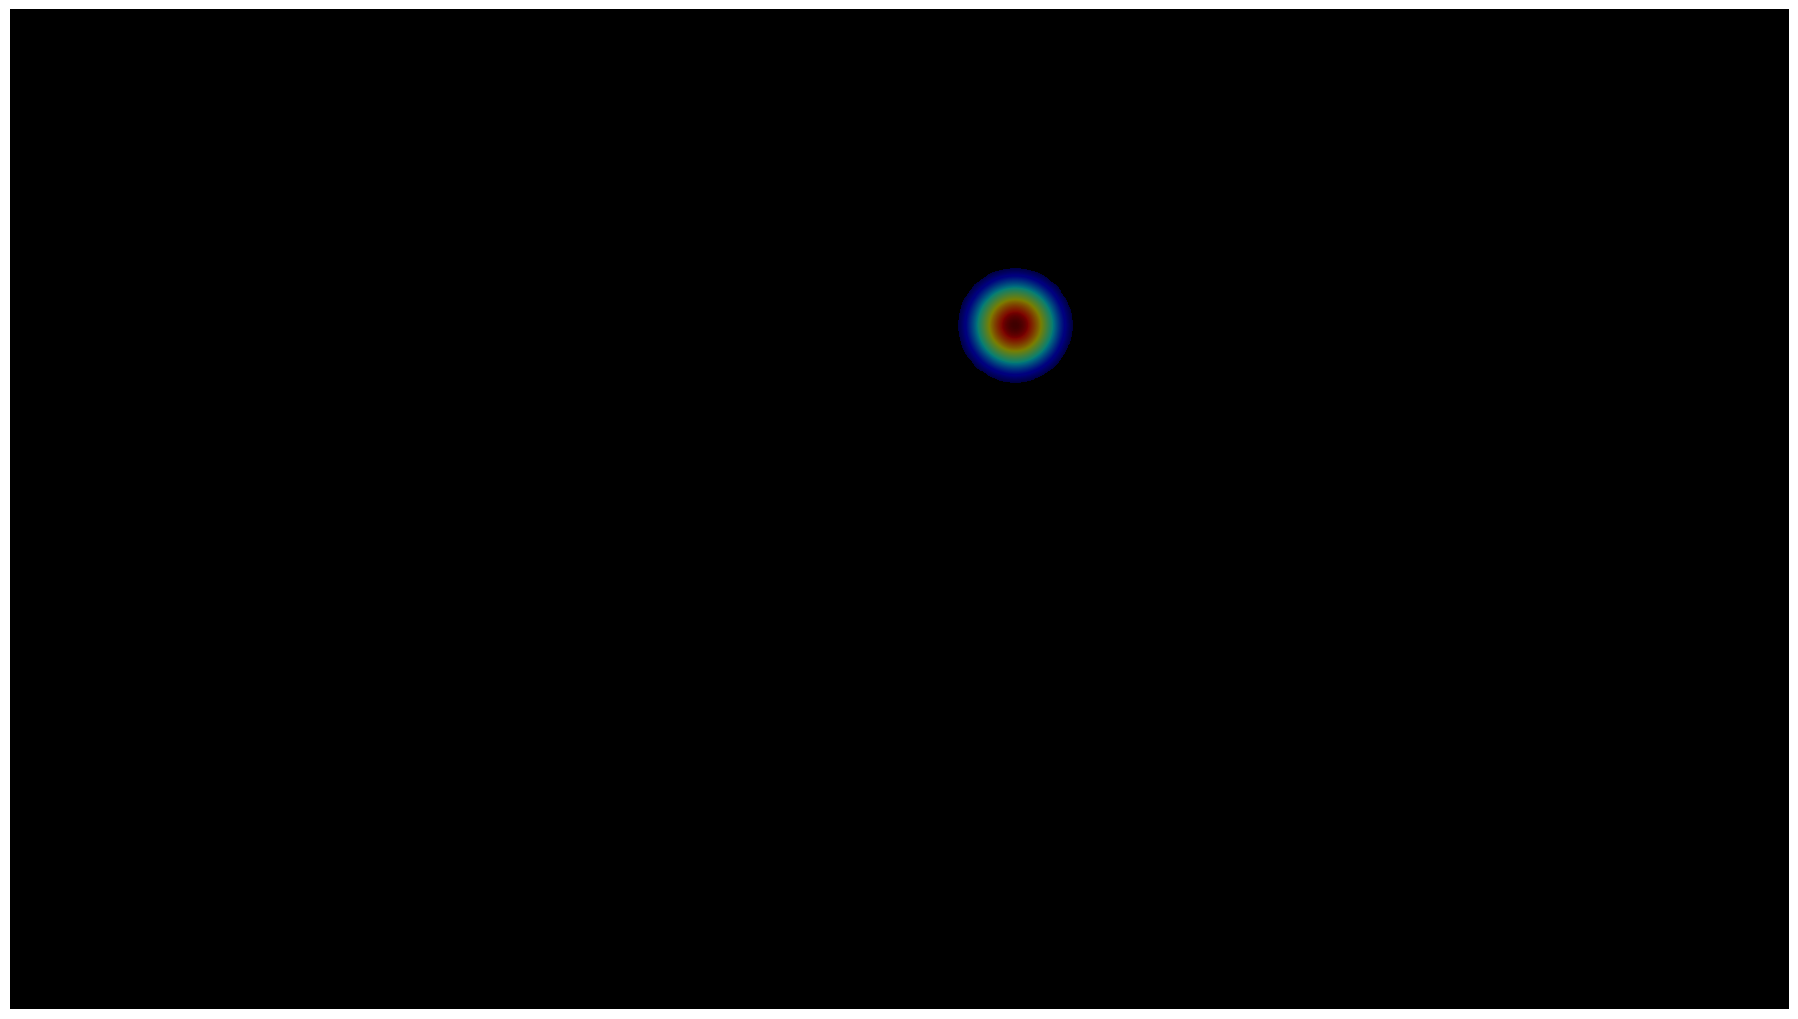

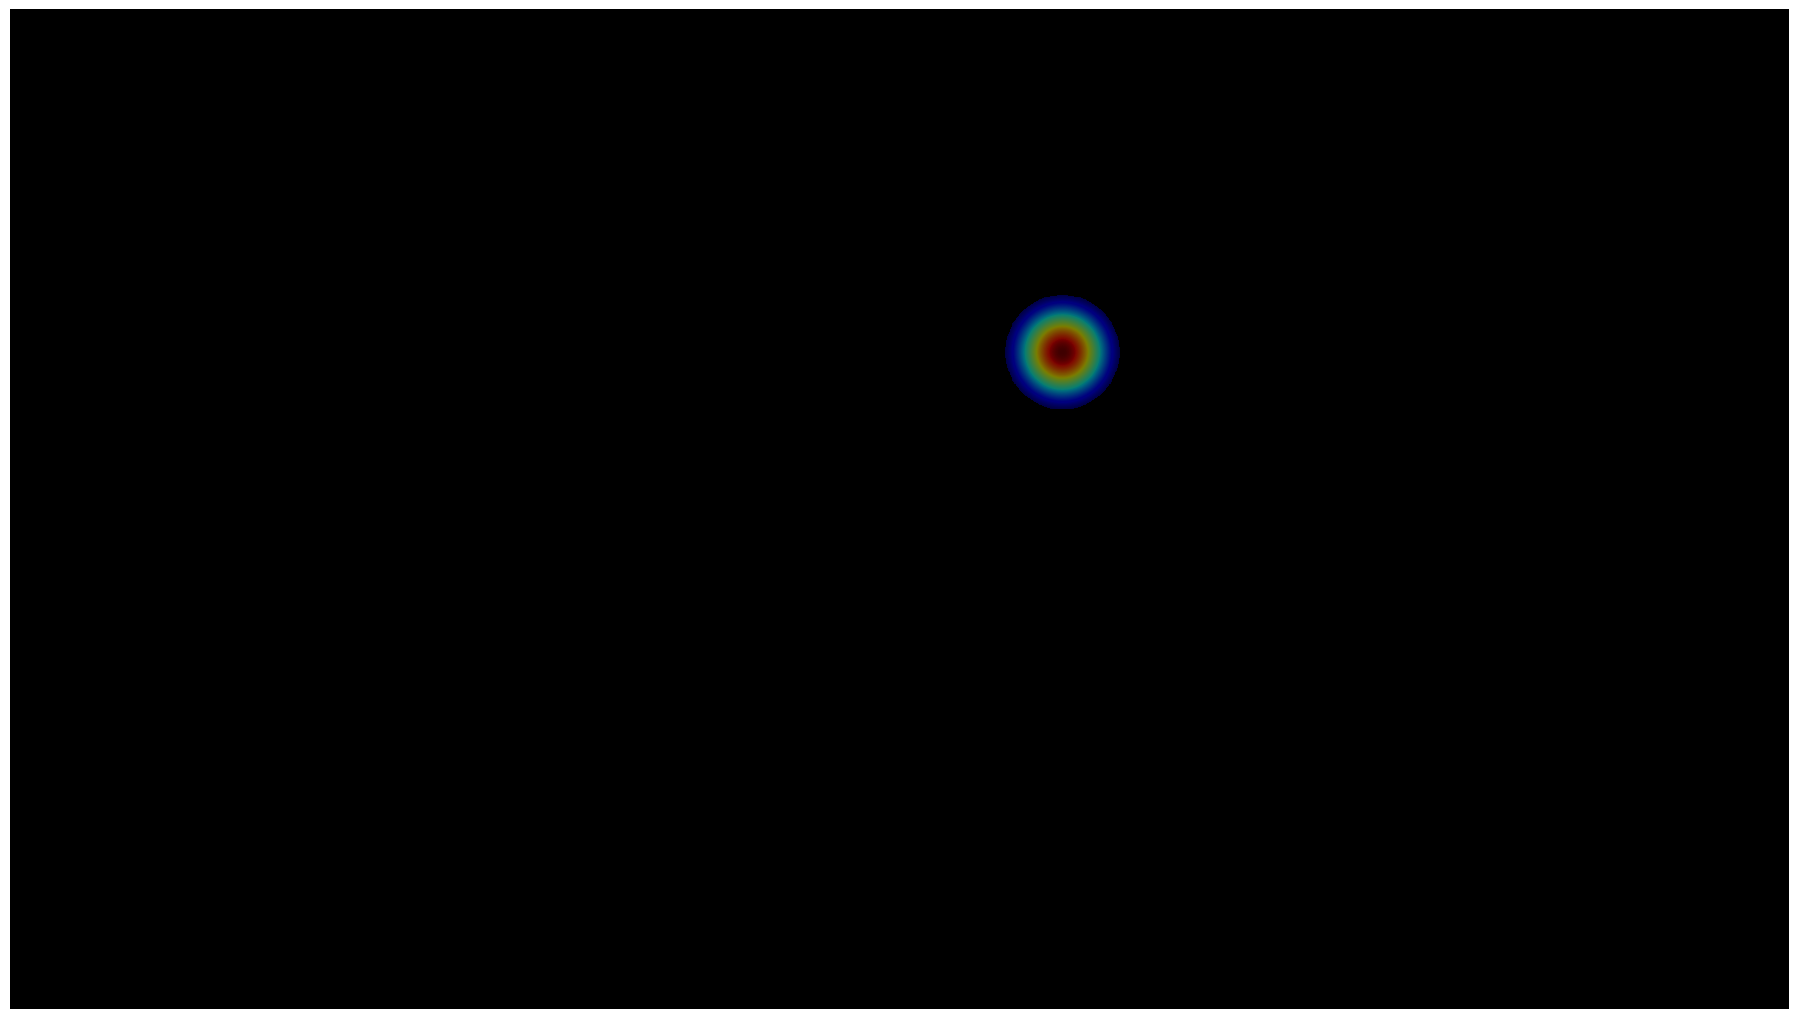

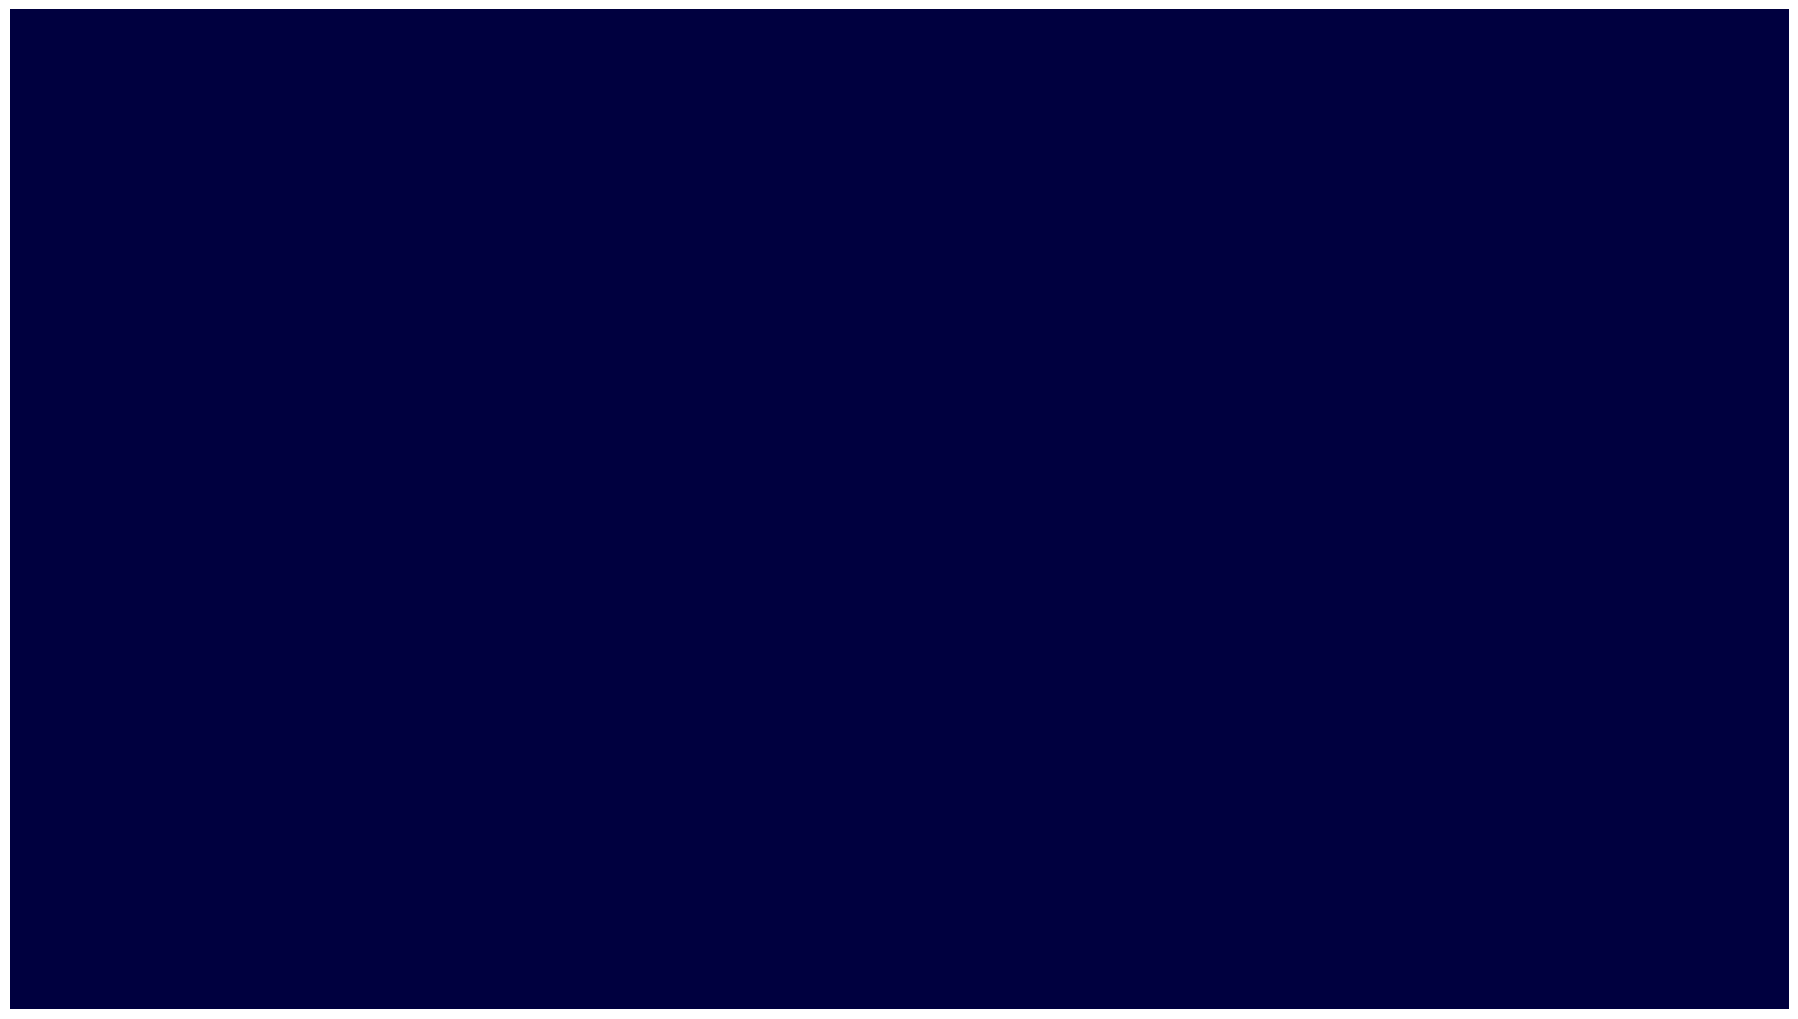

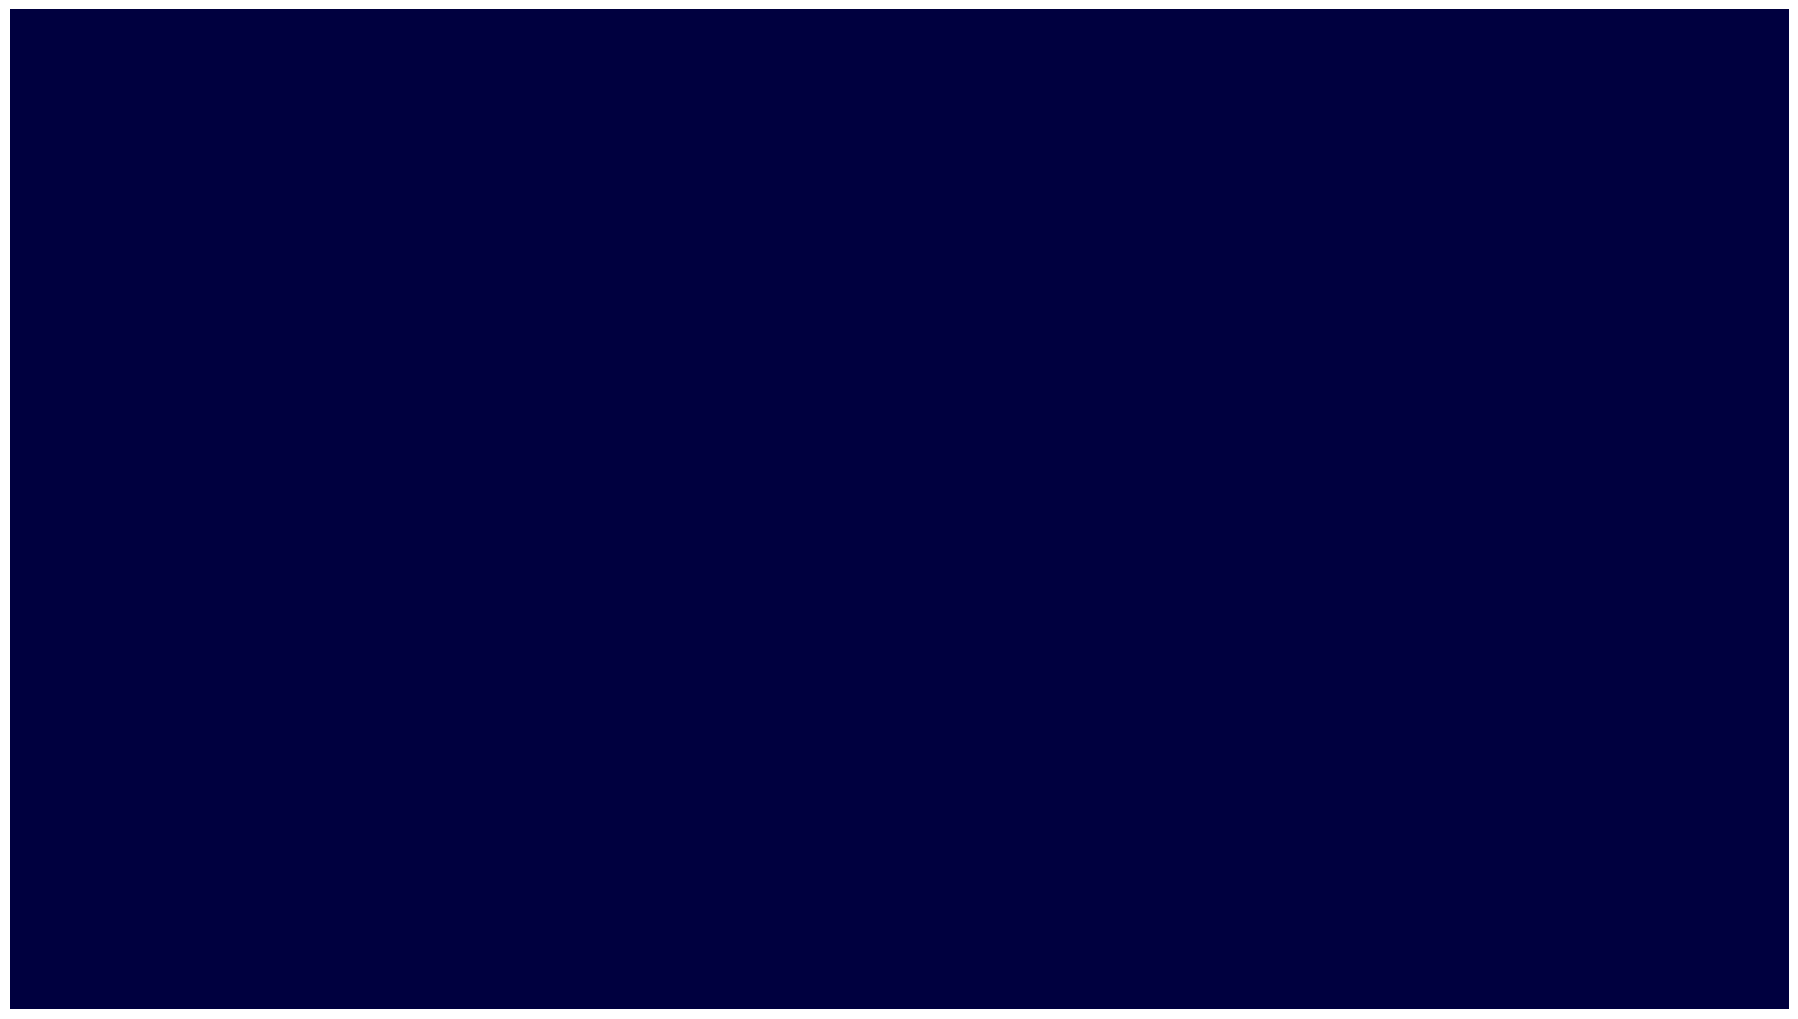

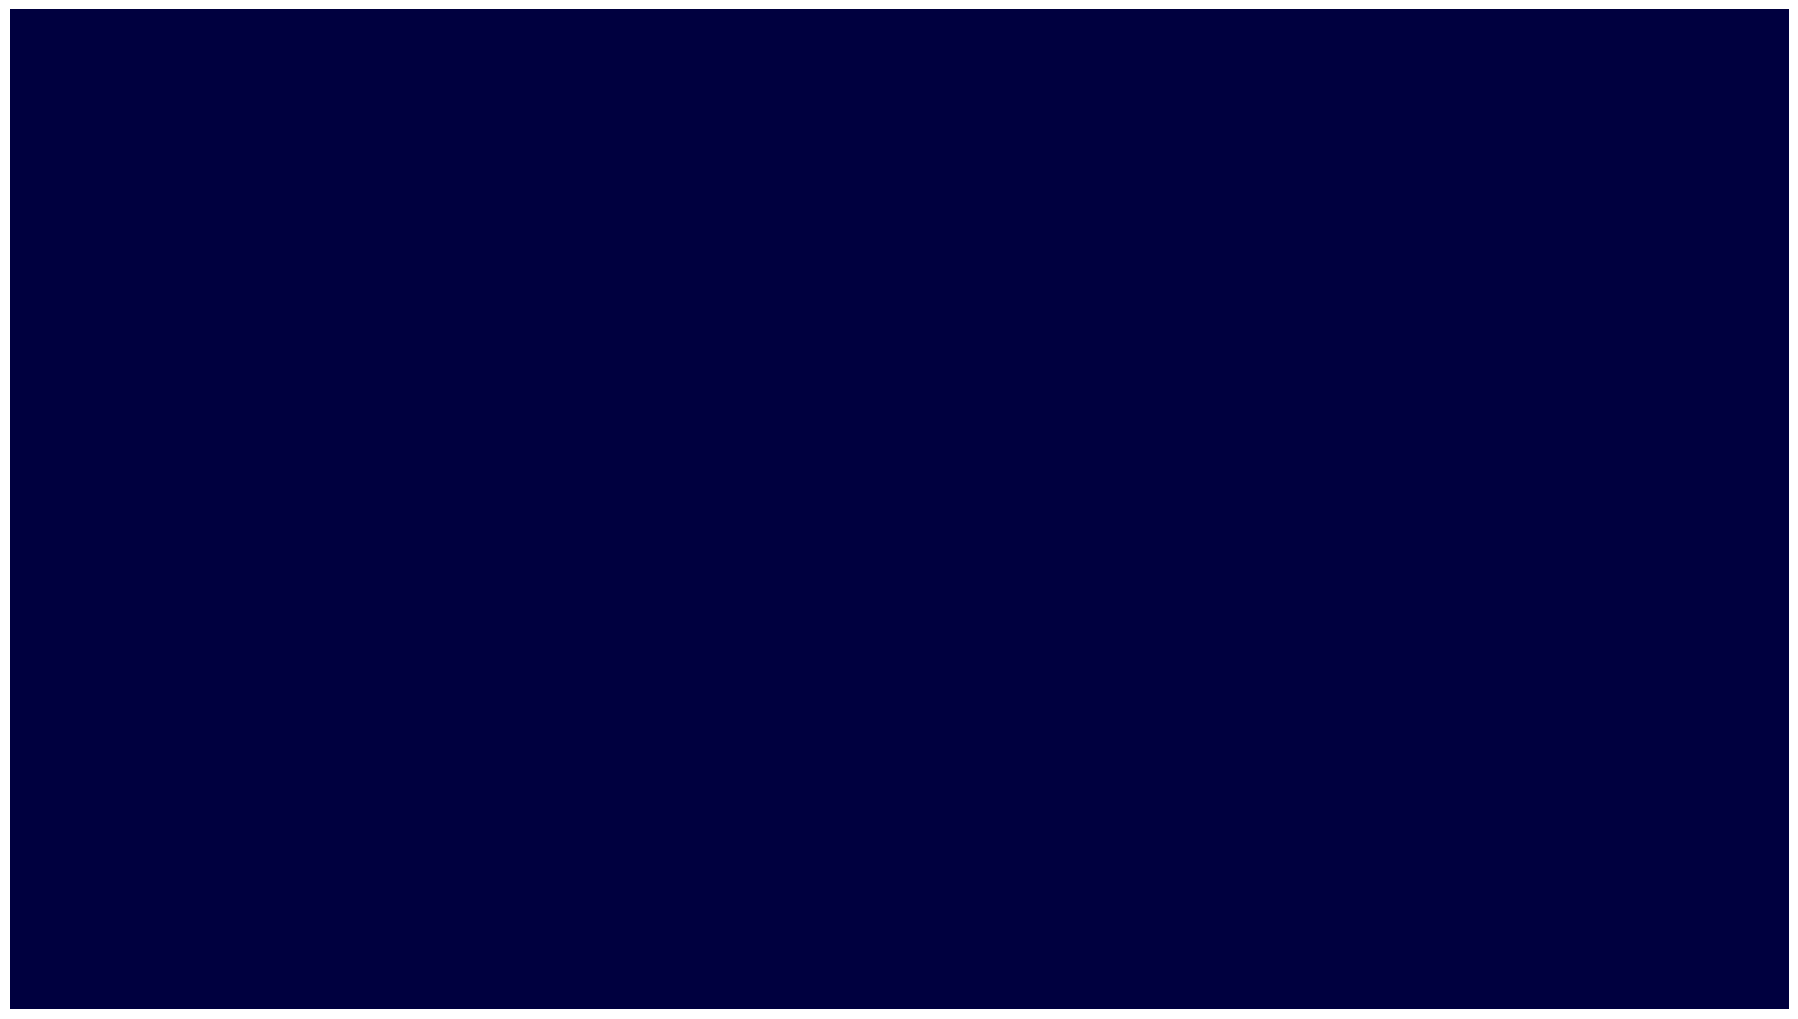

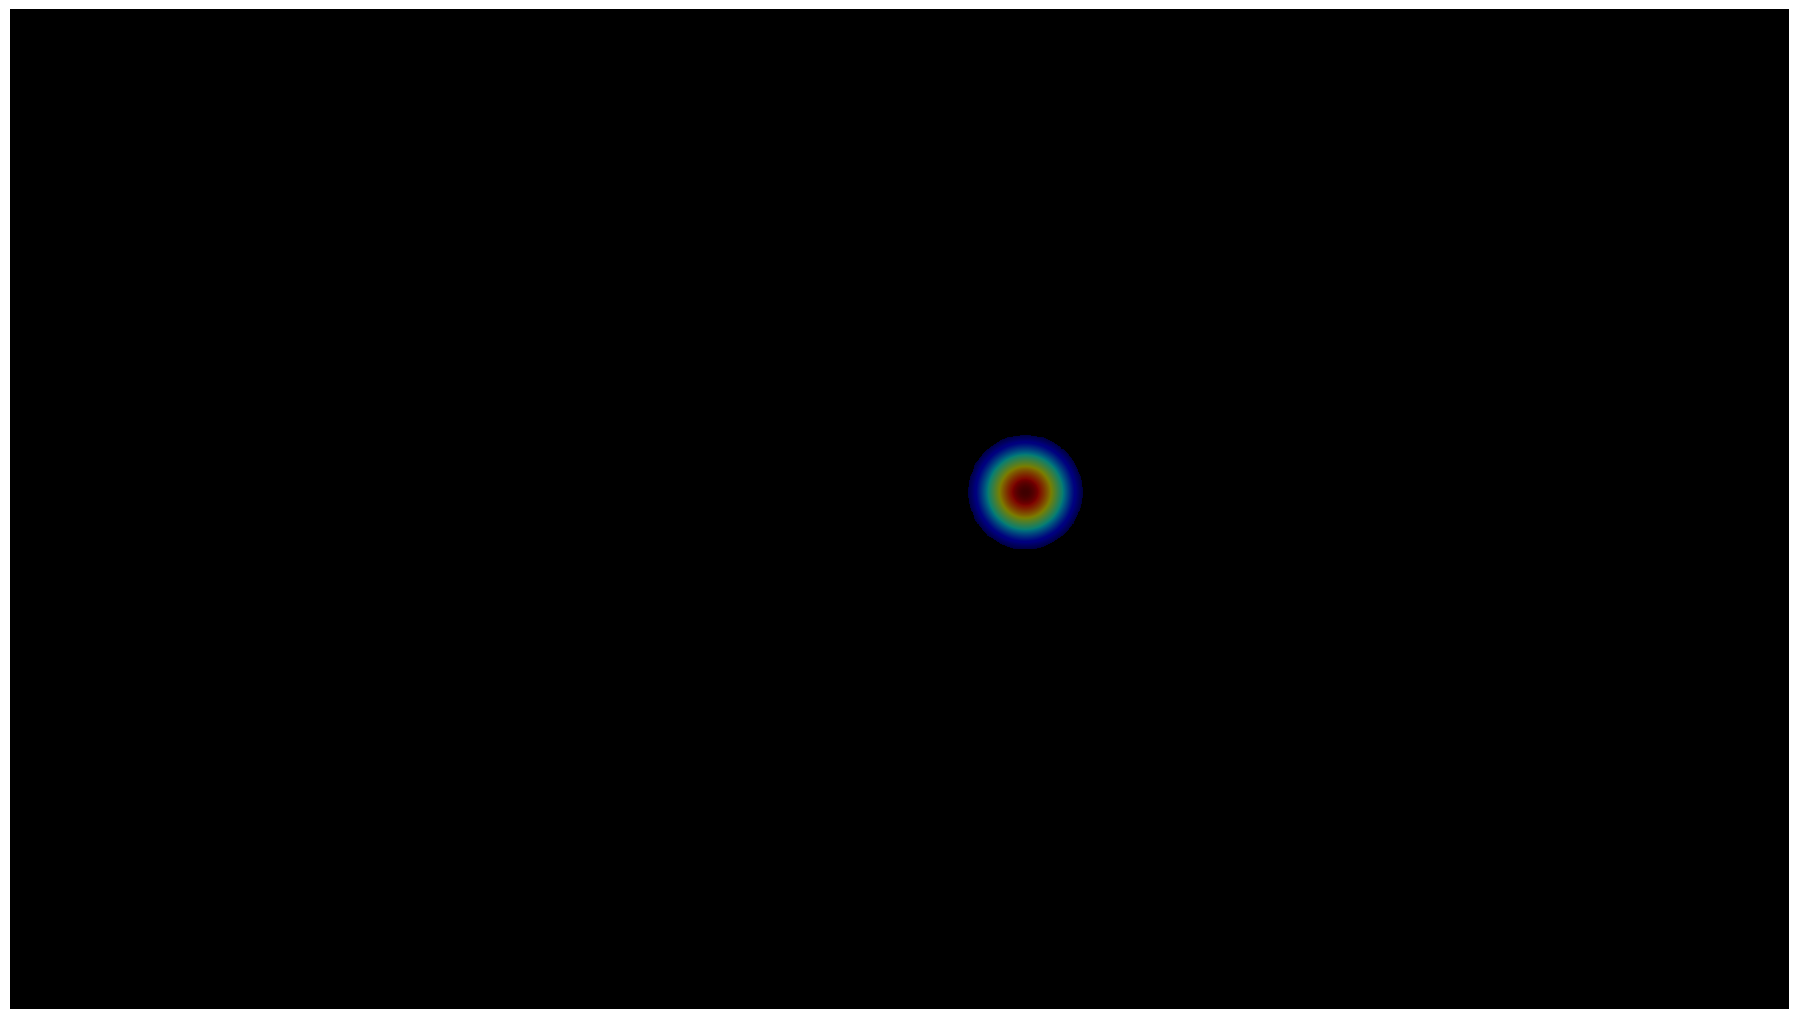

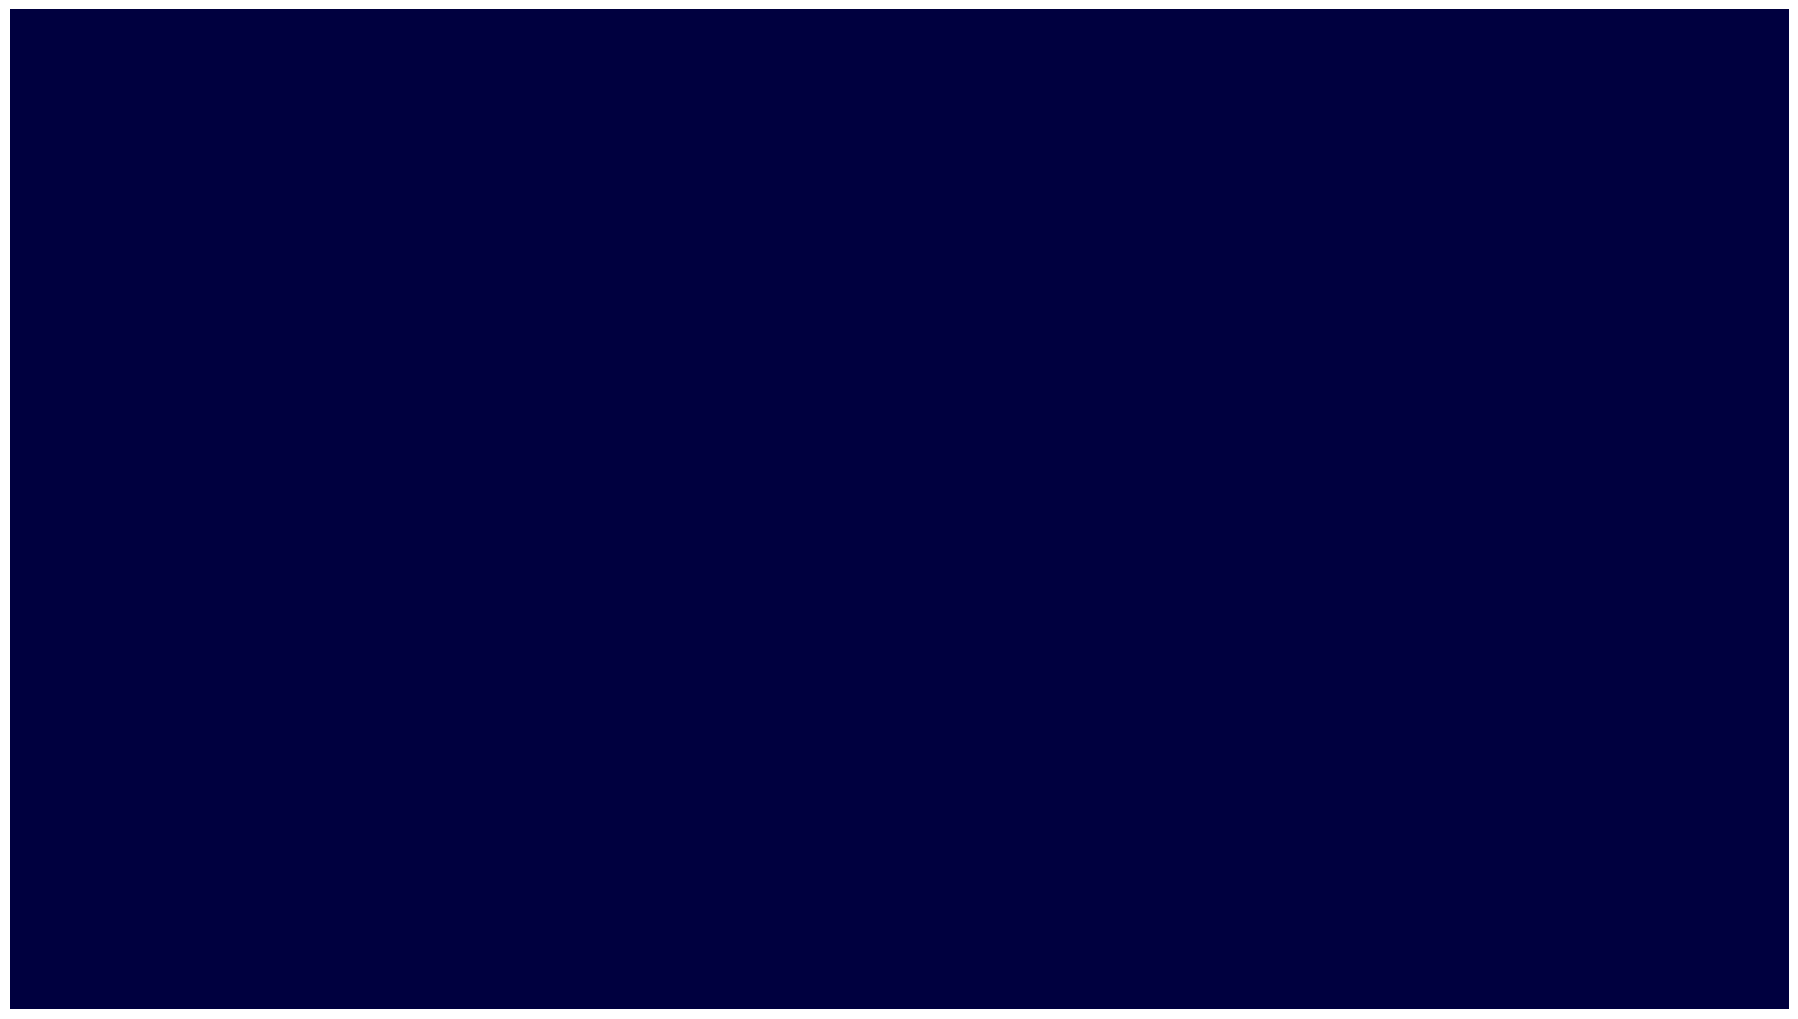

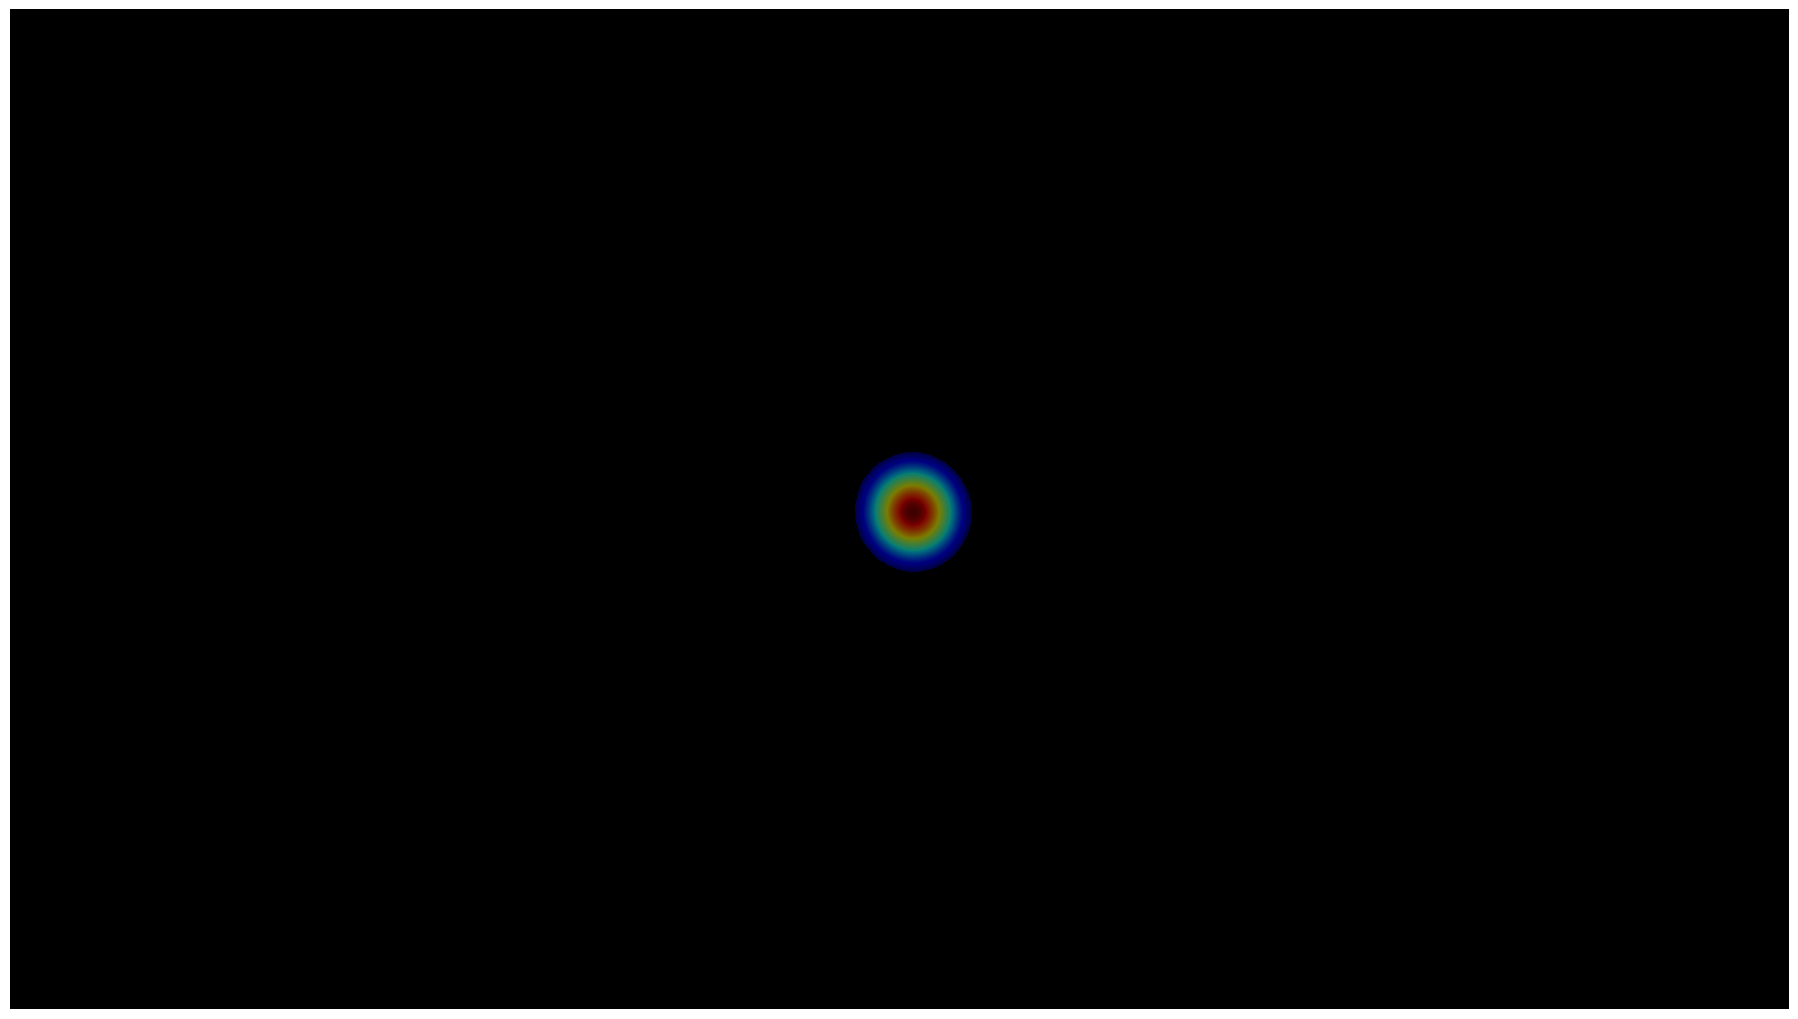

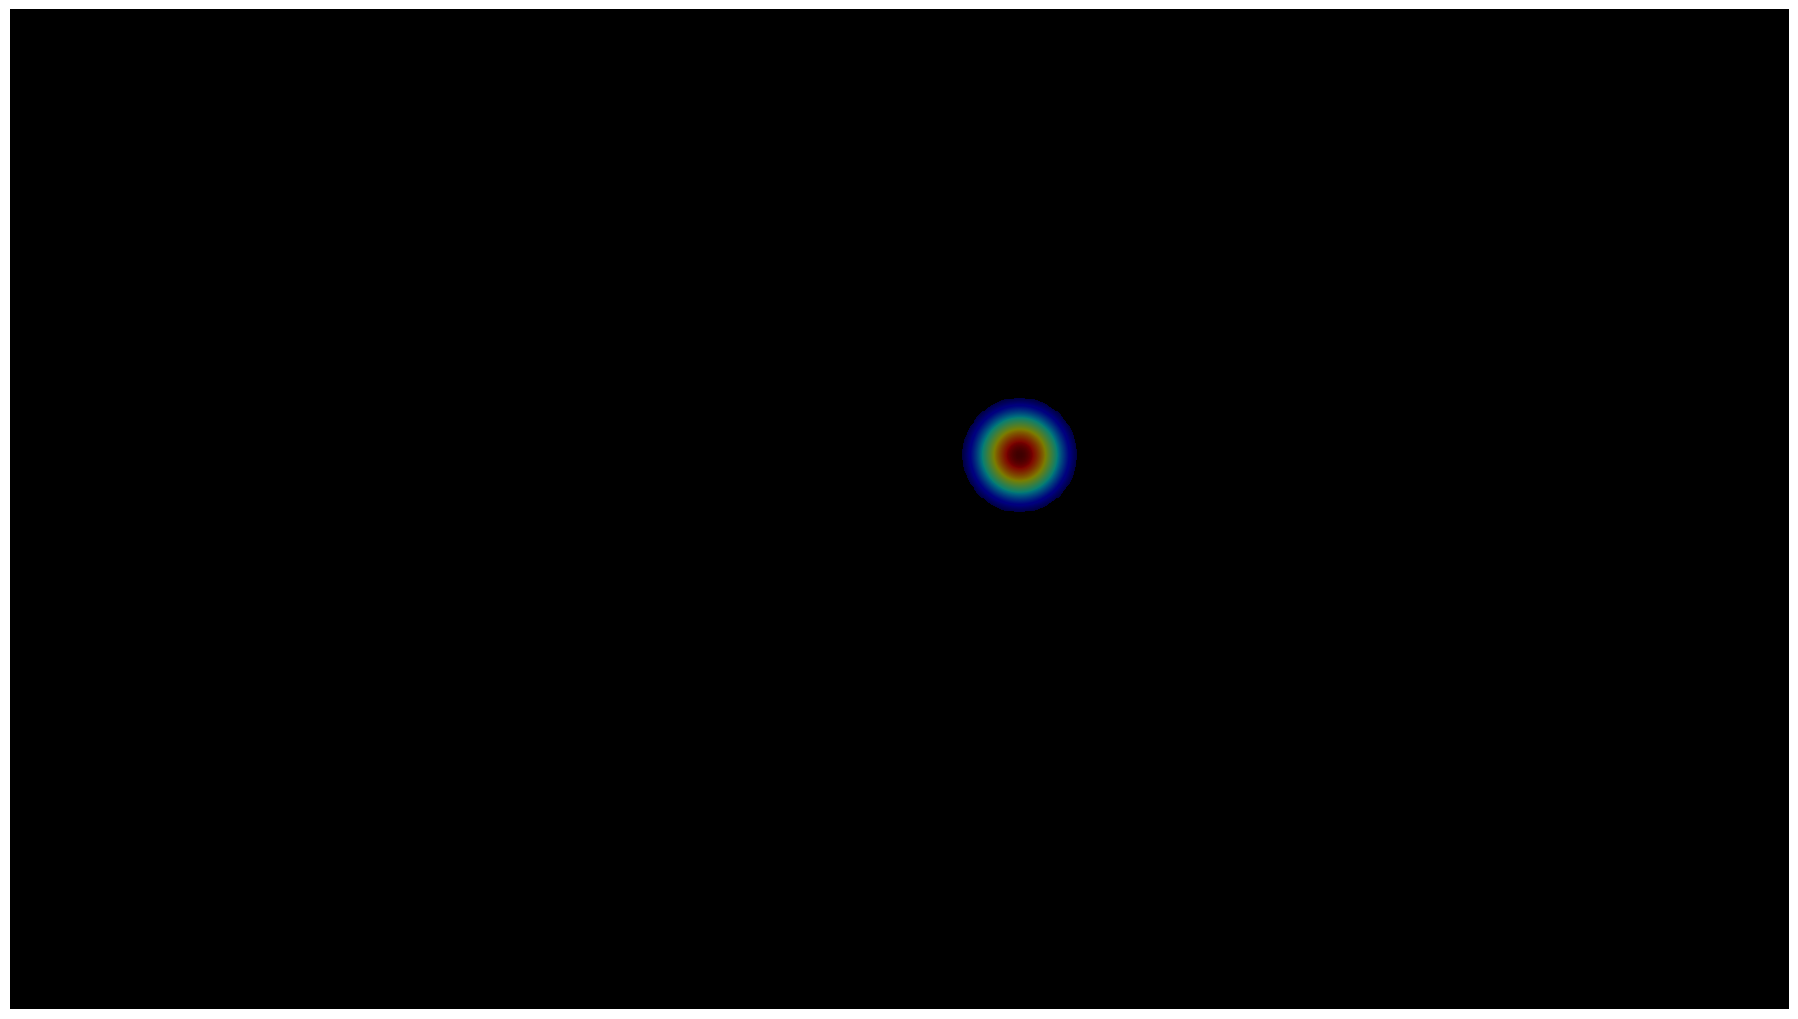

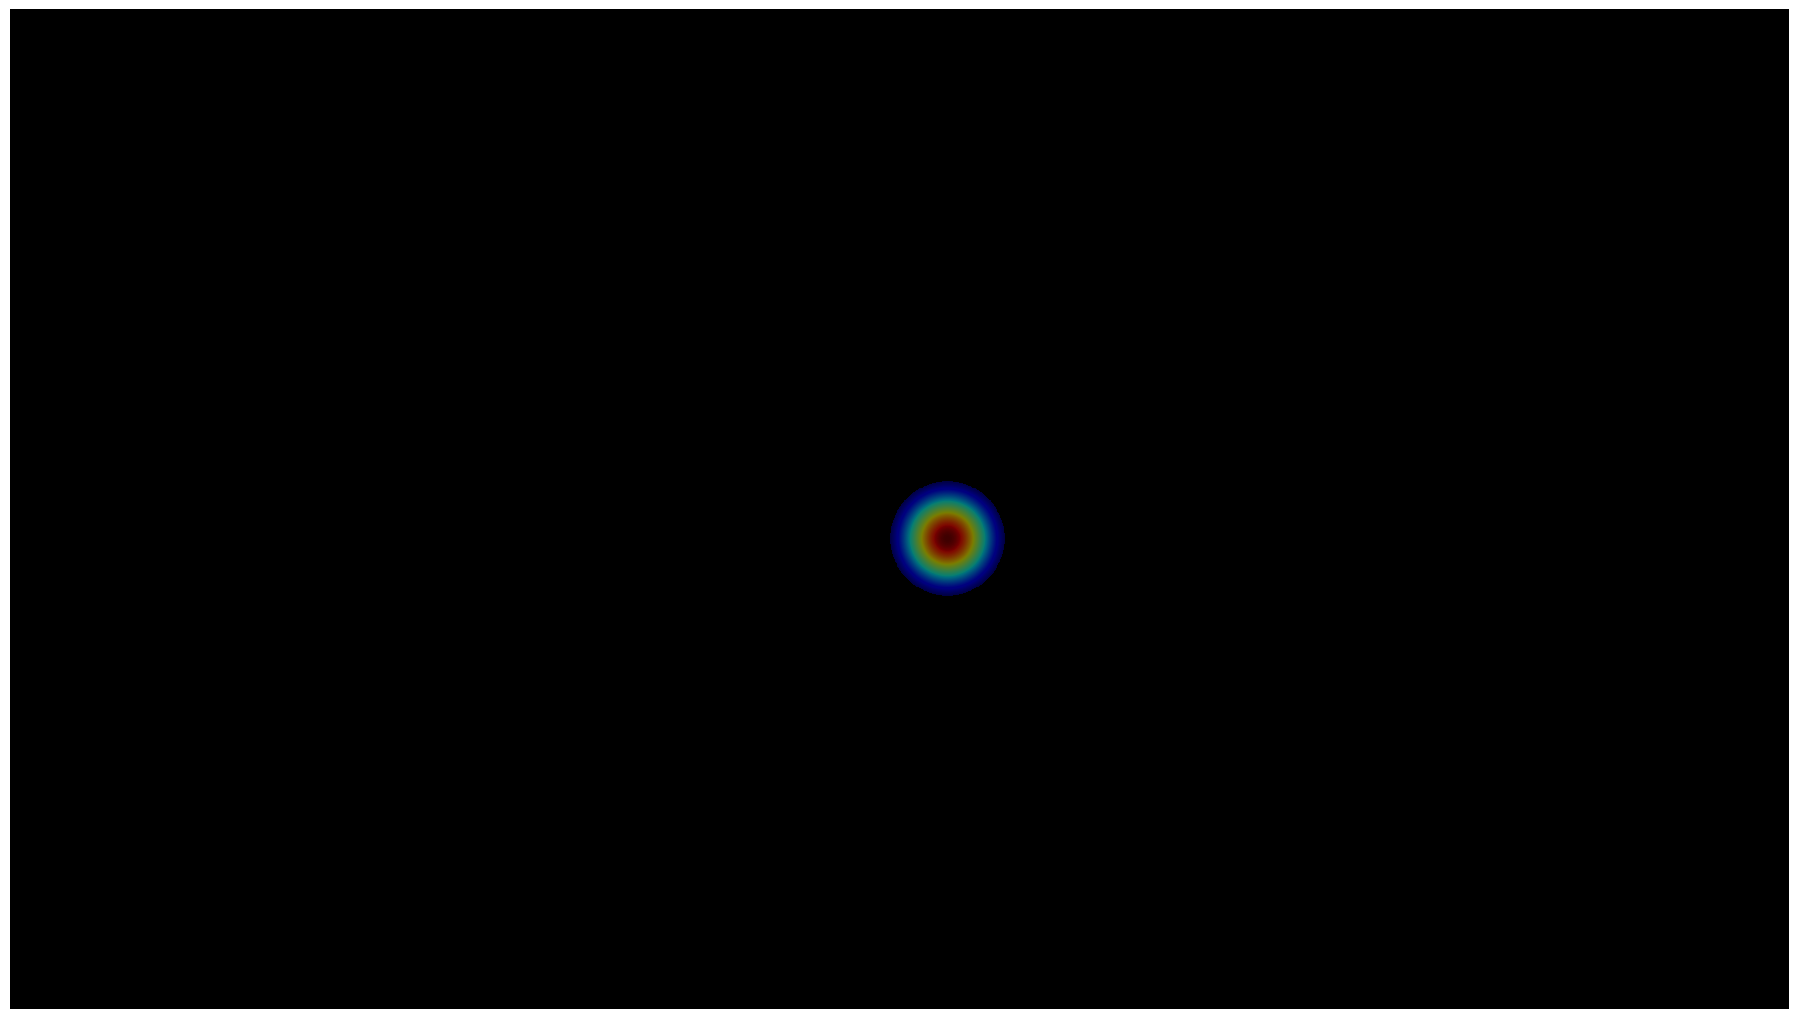

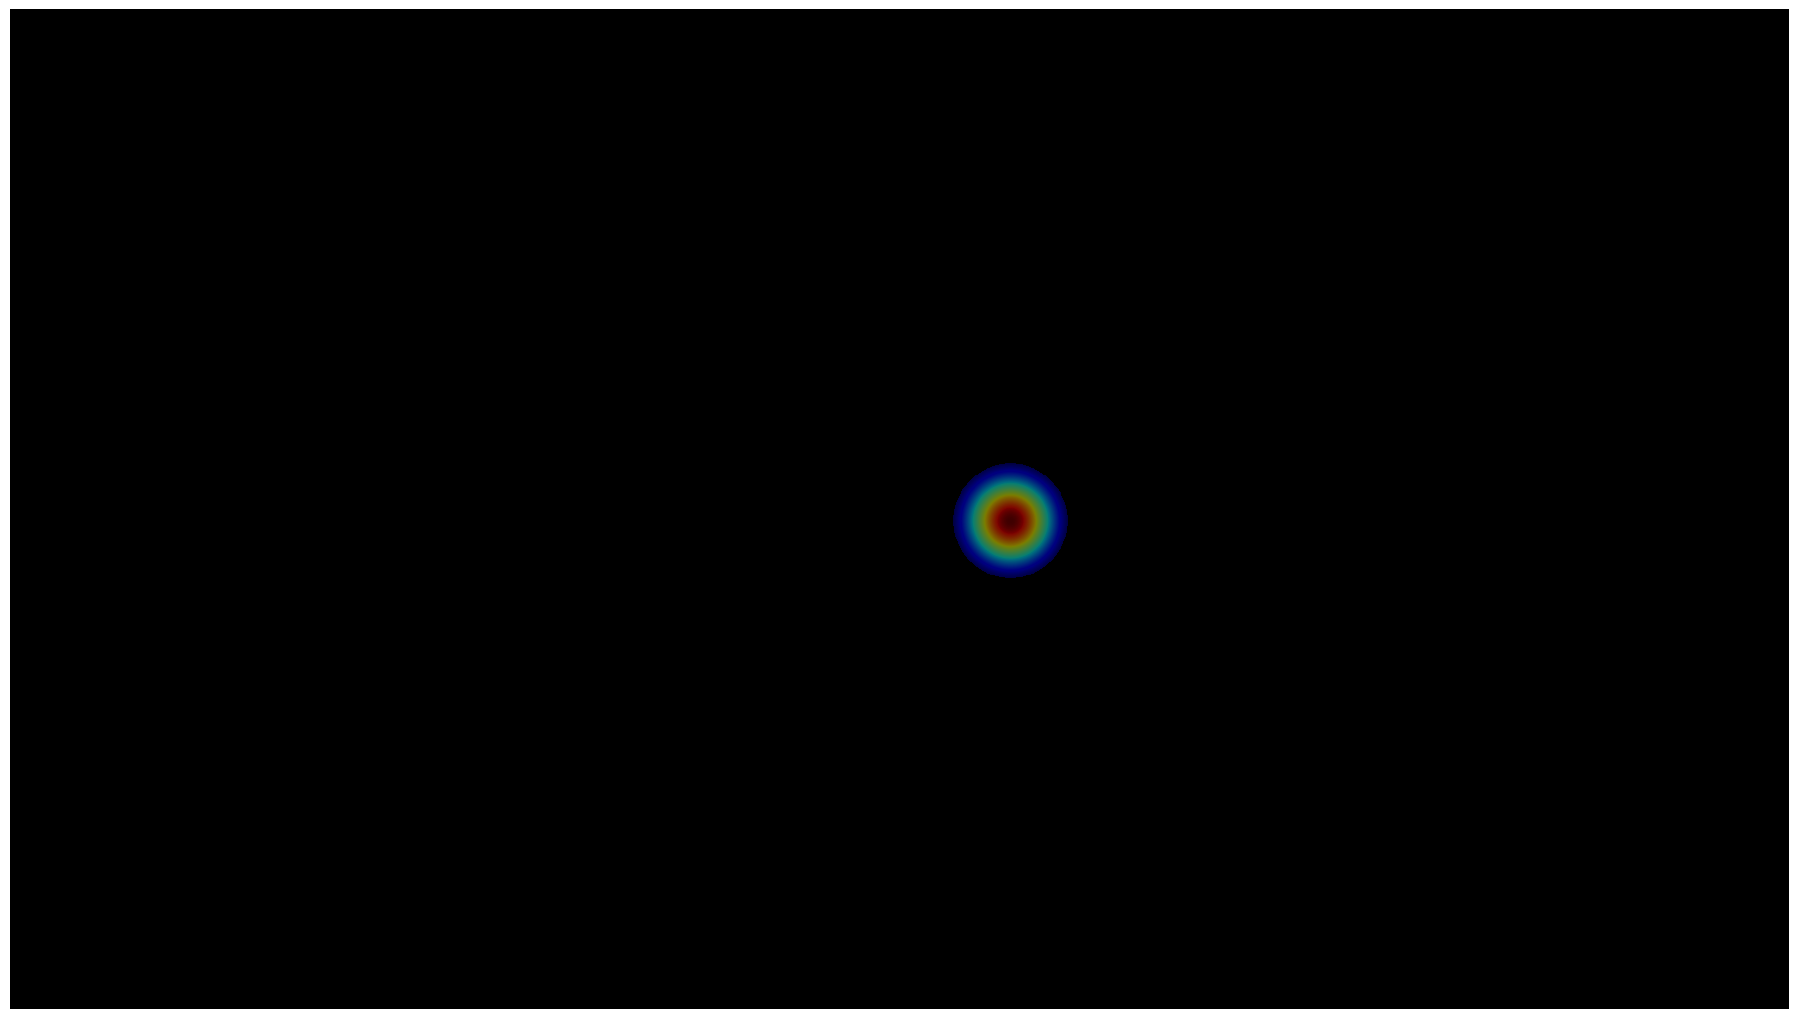

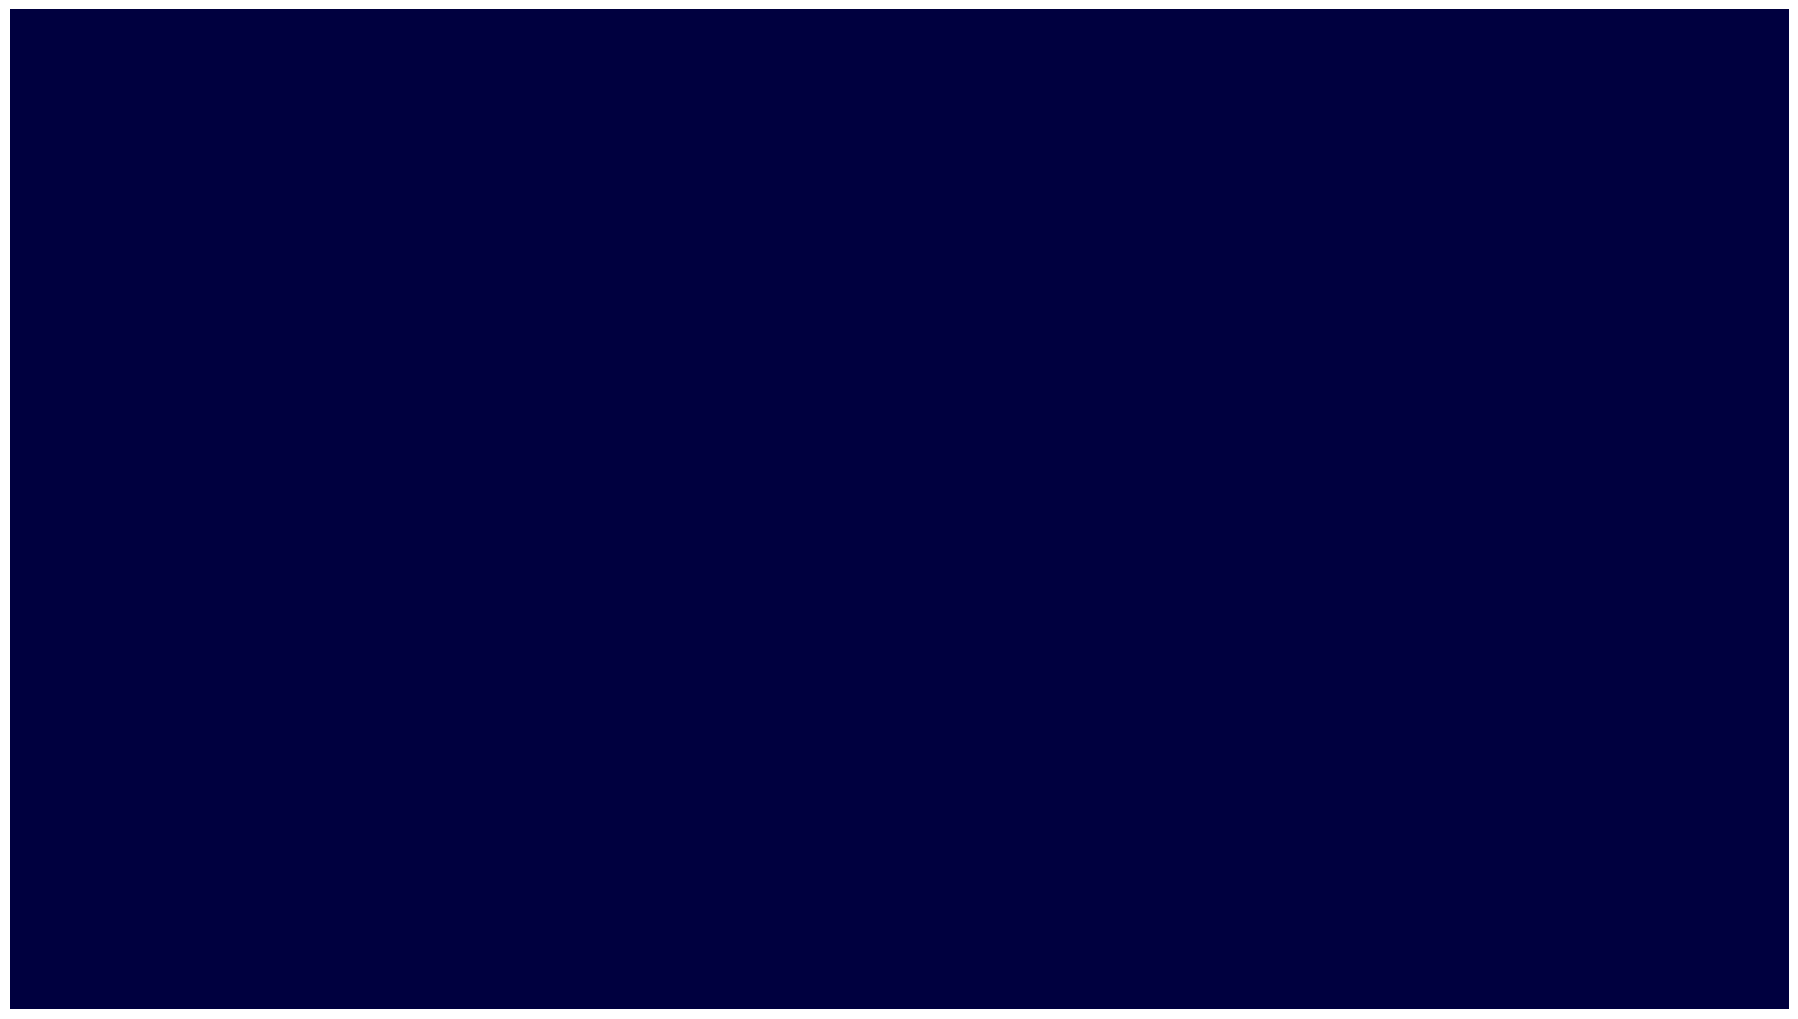

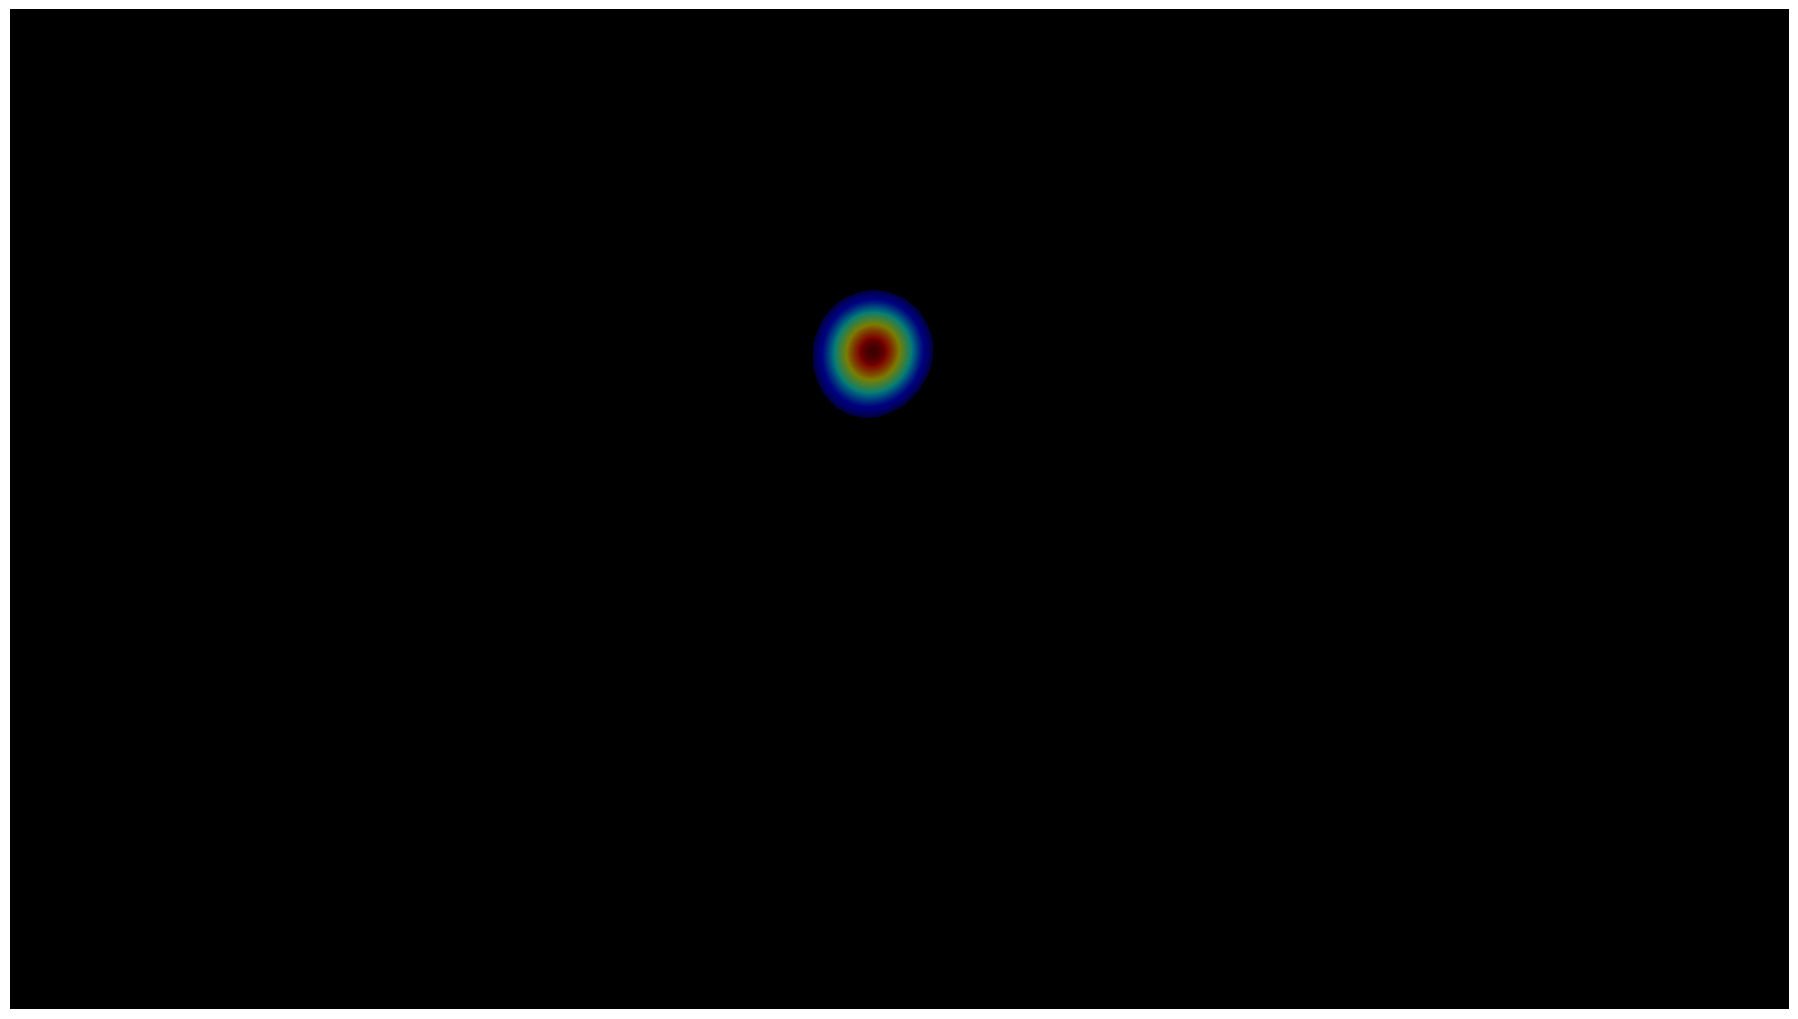

In [122]:
partic_id = 'G036'
game_nr   = 2
trials    = np.arange(1,16,1)
dispsize  = (1919,1079) # (px,px) size of screen 

x_cross_list,y_cross_list, center_x_list,center_y_list = [],[],[],[]
trial_success = []
for trial_nr in (trials):
    #get crosshair position
    #print(return_cross_pos(partic_id,game_nr,trial_nr))
    x_cross,y_cross = return_cross_pos(partic_id,game_nr,trial_nr)
    if x_cross!=0:
        ###get centroid
        
        #fixations
        fixations = np.array(data[trial_nr]['events']['Efix'])
        fig_heatmap = draw_heatmap(fixations, dispsize)
        #save heatmap
        fig_heatmap.savefig('img_1.png')

        #feed heatmap to the function
        image_load = cv2.imread('img_1.png',0)
        center,_,image_out = return_centroid_heatmap(image_load)
        #print(center)
        if center.size!=0:
            #print(center)
            if center.shape[0]>1:
                #print(center.shape)
                center = center[0] #CHANGE LATER!!!
            #plot center - cross hair distance
            #dist = np.sqrt((x_cross-center[0][0])**2 + (y_cross-center[0][1])**2)
            #plt.scatter(trial_nr,dist)
            x_cross_list.append(x_cross)
            y_cross_list.append(y_cross)
            center_x_list.append(center[0][0])
            center_y_list.append(center[0][1])
            trial_success.append(trial_nr)


array([100.62483702,  44.130039  , 140.56498515,  28.51808431,
        38.48509488, 231.91399403,  50.21421924,  51.61939233,
       114.62747844, 139.30515886])

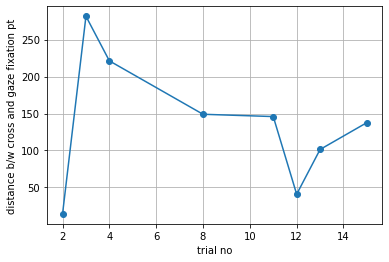

In [121]:
# Game no 1
dist = np.sqrt((np.array(center_x_list) - np.array(x_cross_list))**2 +
               (np.array(center_y_list) - np.array(y_cross_list))**2)
plt.plot(np.array(trial_success),(dist),'-o')
plt.xlabel('trial no')
plt.ylabel('distance b/w cross and gaze fixation pt')
plt.grid()

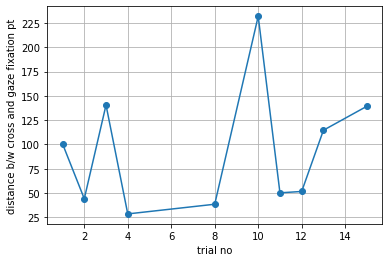

In [123]:
# Game no 2
dist = np.sqrt((np.array(center_x_list) - np.array(x_cross_list))**2 +
               (np.array(center_y_list) - np.array(y_cross_list))**2)
plt.plot(np.array(trial_success),(dist),'-o')
plt.xlabel('trial no')
plt.ylabel('distance b/w cross and gaze fixation pt')
plt.grid()

### Parsing The Stimulus Data

In [13]:
"""
Create Dictionary of Stimulus Properties


dict_keys(['subject_nr', 'subject_id', 'game_nr', 'trial_nr', 'perc_noise', 
            'perc_noise_sample', 'orientation', 'orientation_sample', 'orientation_0', 
            'orientation_0_sample','orientation_positive_unfair', 'orientation_positive_fair', 
            'reference_line'])
            

"""

def load_dataset_properties(fname):
#file name
    #fname = 'dataset_0423.csv'

    #read and store into data_set
    data_set = []
    with open(fname, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in csvreader:
            row = row[0].split(',') #split by comma separated 
            data_set.append(row)
    return data_set


"""convert to dictionary
keys_dict = data_set[0]

#rearrange values
values_dict = np.array(data_set[1:]).T
   
#create_dict
data_set_dict = dict(zip(keys_dict,values_dict))
"""

'convert to dictionary\nkeys_dict = data_set[0]\n\n#rearrange values\nvalues_dict = np.array(data_set[1:]).T\n   \n#create_dict\ndata_set_dict = dict(zip(keys_dict,values_dict))\n'

In [161]:
"""
Convert to Numpy array such that array
[id-2*game_nr-1*trial_nr-1,property] returns the corresponding value



"""




(10080, 13)

In [12]:
## Retrieve Data
'''
['subject_nr', 'subject_id', 'game_nr', 'trial_nr', 'perc_noise', 
'perc_noise_sample', 'orientation', 'orientation_sample', 'orientation_0', 'orientation_0_sample', 
'orientation_positive_unfair', 'orientation_positive_fair', 'reference_line'])

'''

def return_property_value(data_set,subject_id, game_nr,trial_nr,property_label):
    #subject_id = 36
    #game_nr = 1
    #trial_nr = 5
    ### Convert to numpy array
    data_set_arr = np.array(data_set[1:]).astype(float)
    #reshape
    data_set_arr.reshape(35,16,18,-1)
    data_set_arr.shape
    #retrieve perc_noise_sample
    #property_label = 'perc_noise_sampe'
    index_property = data_set[0].index(property_label)
    property_value = data_set_arr[(subject_id-2)*(game_nr-1)*(trial_nr-1),index_property]
    return property_value

 ### Plot perceived noise_sample vs inattention


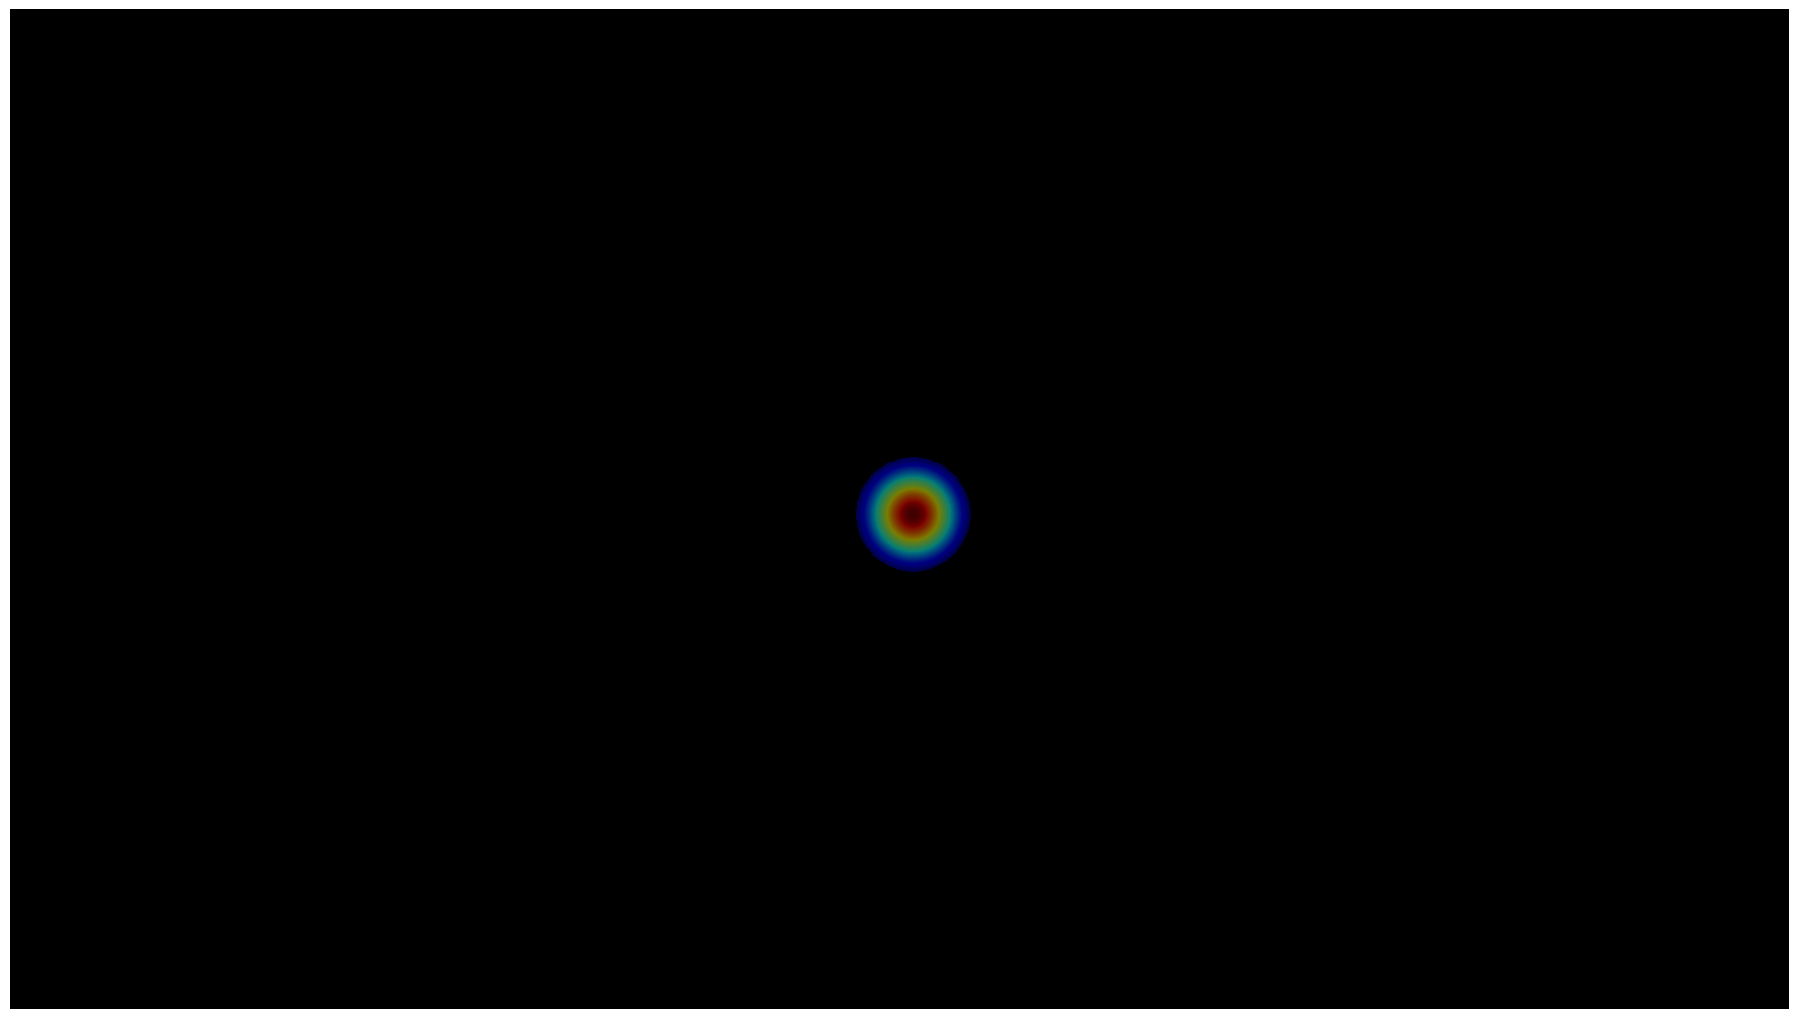

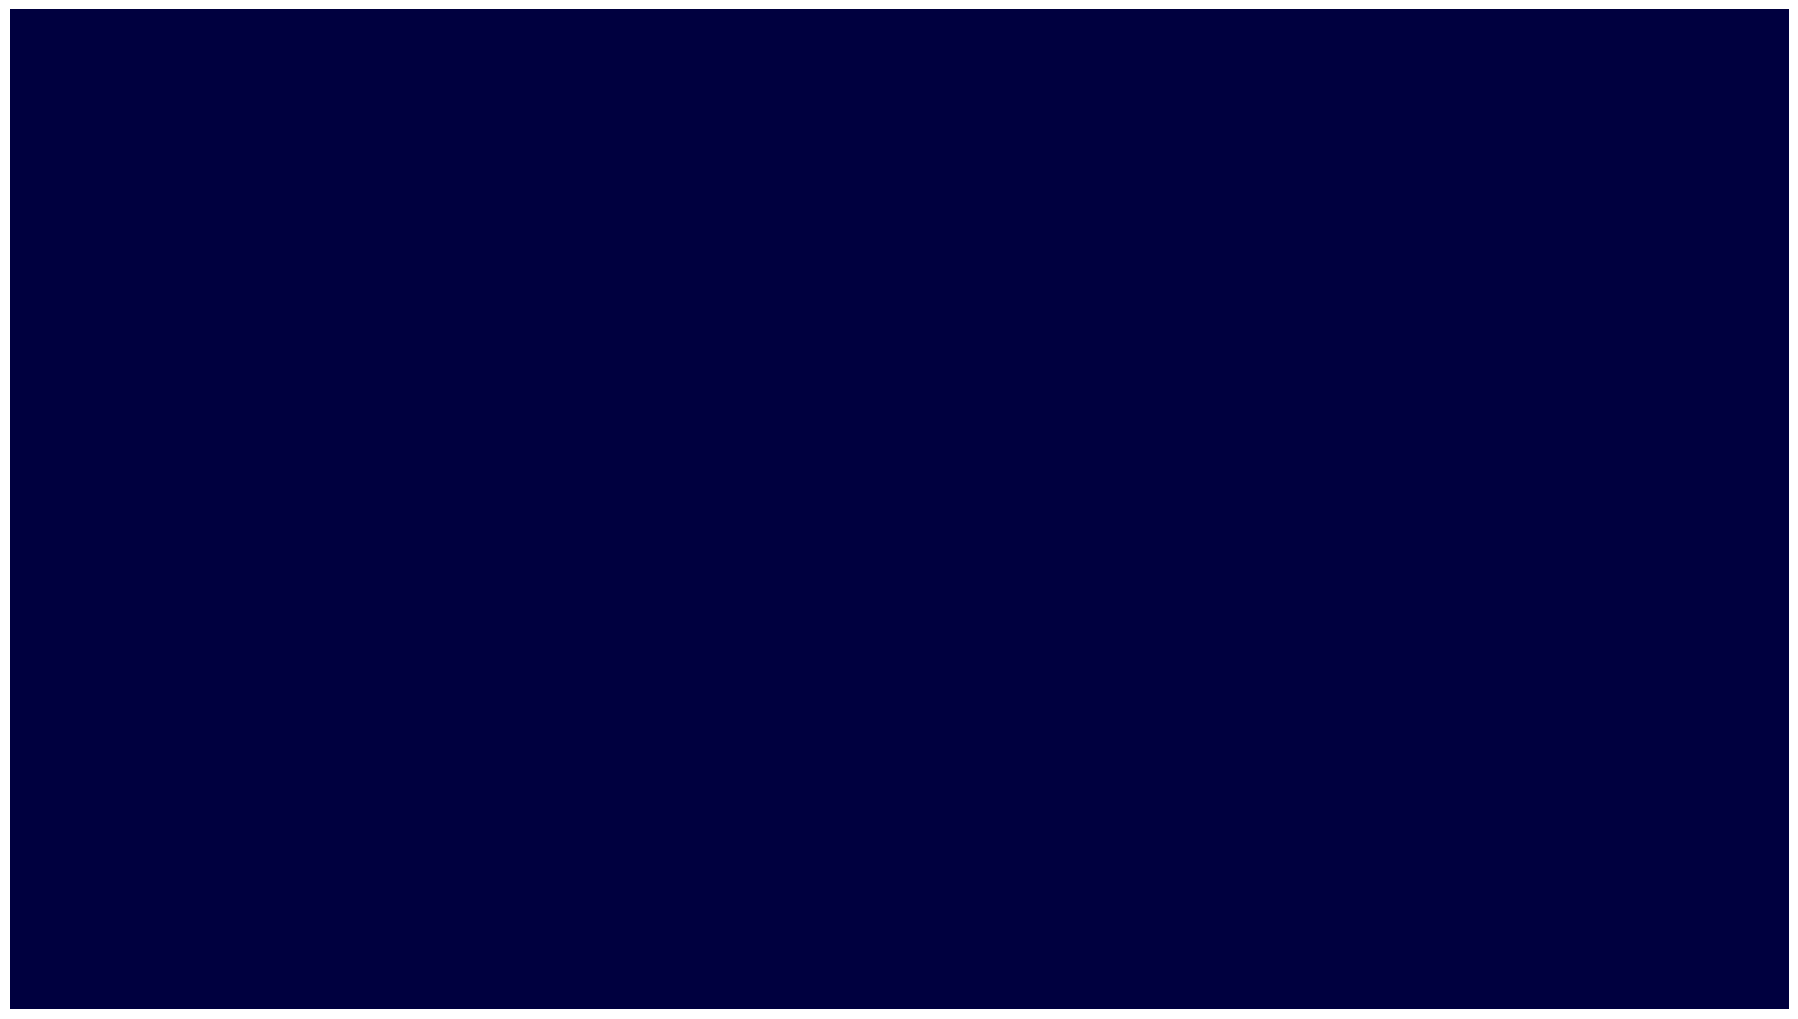

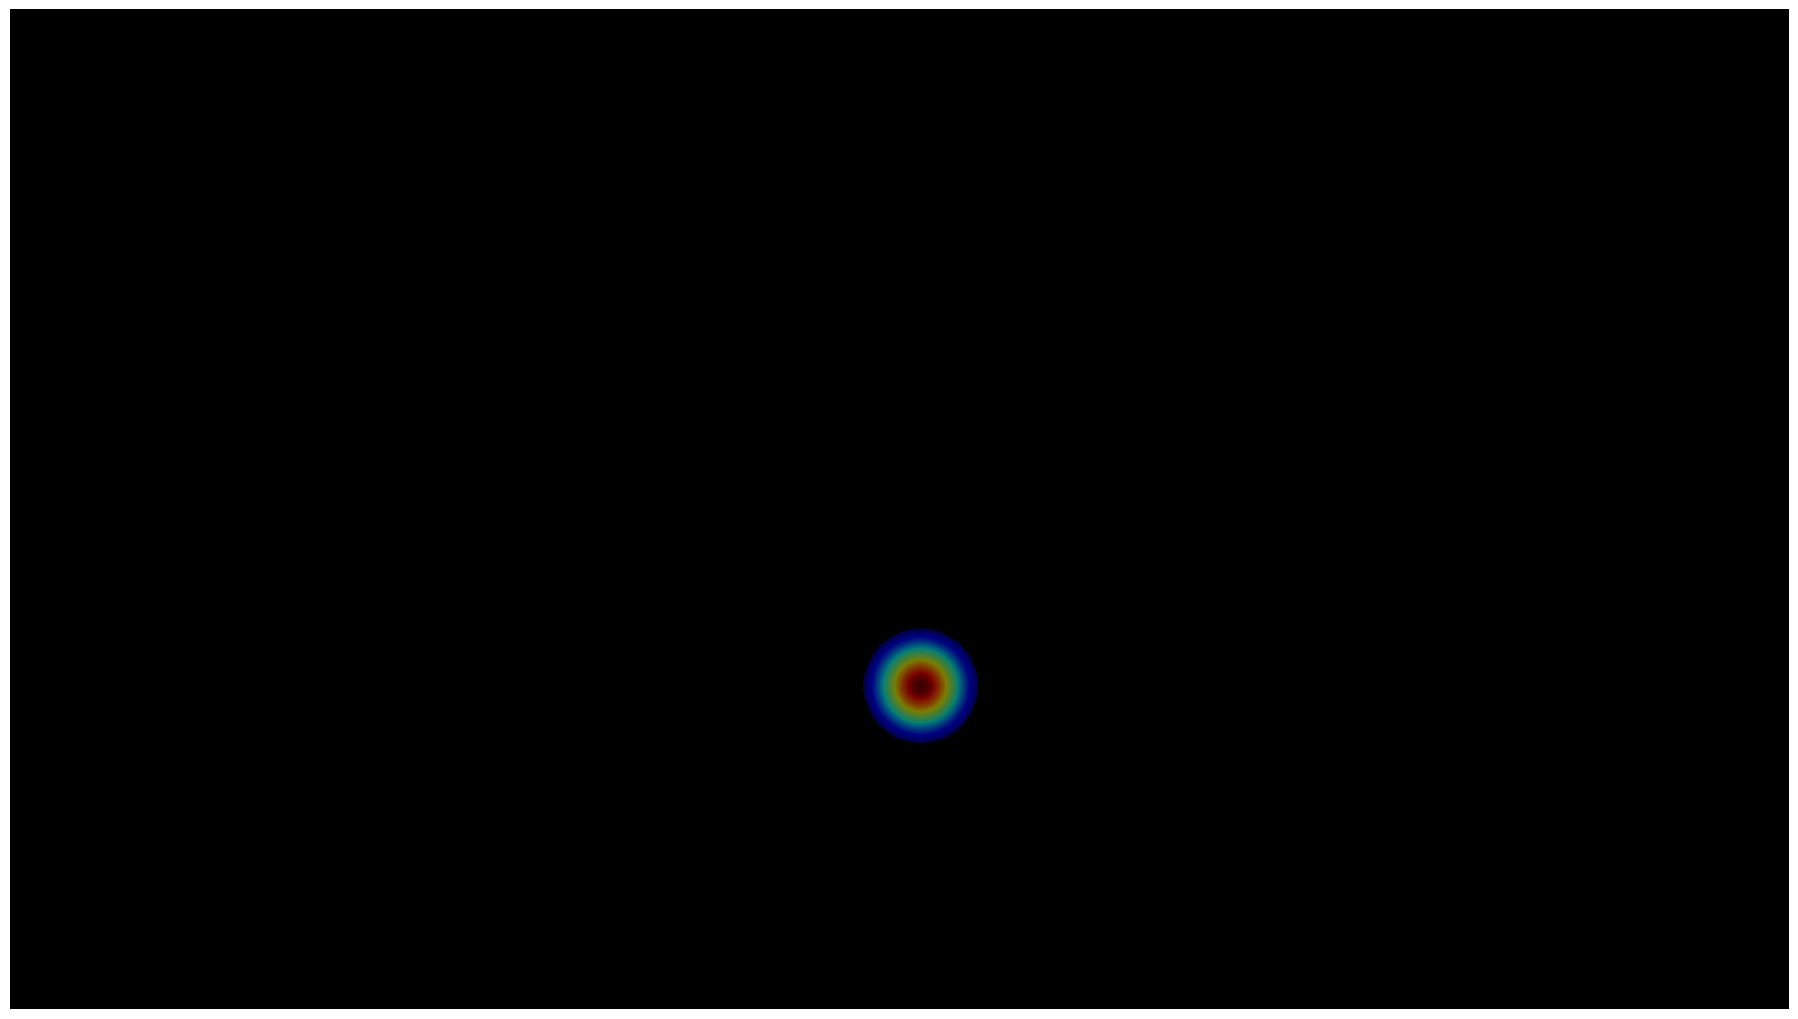

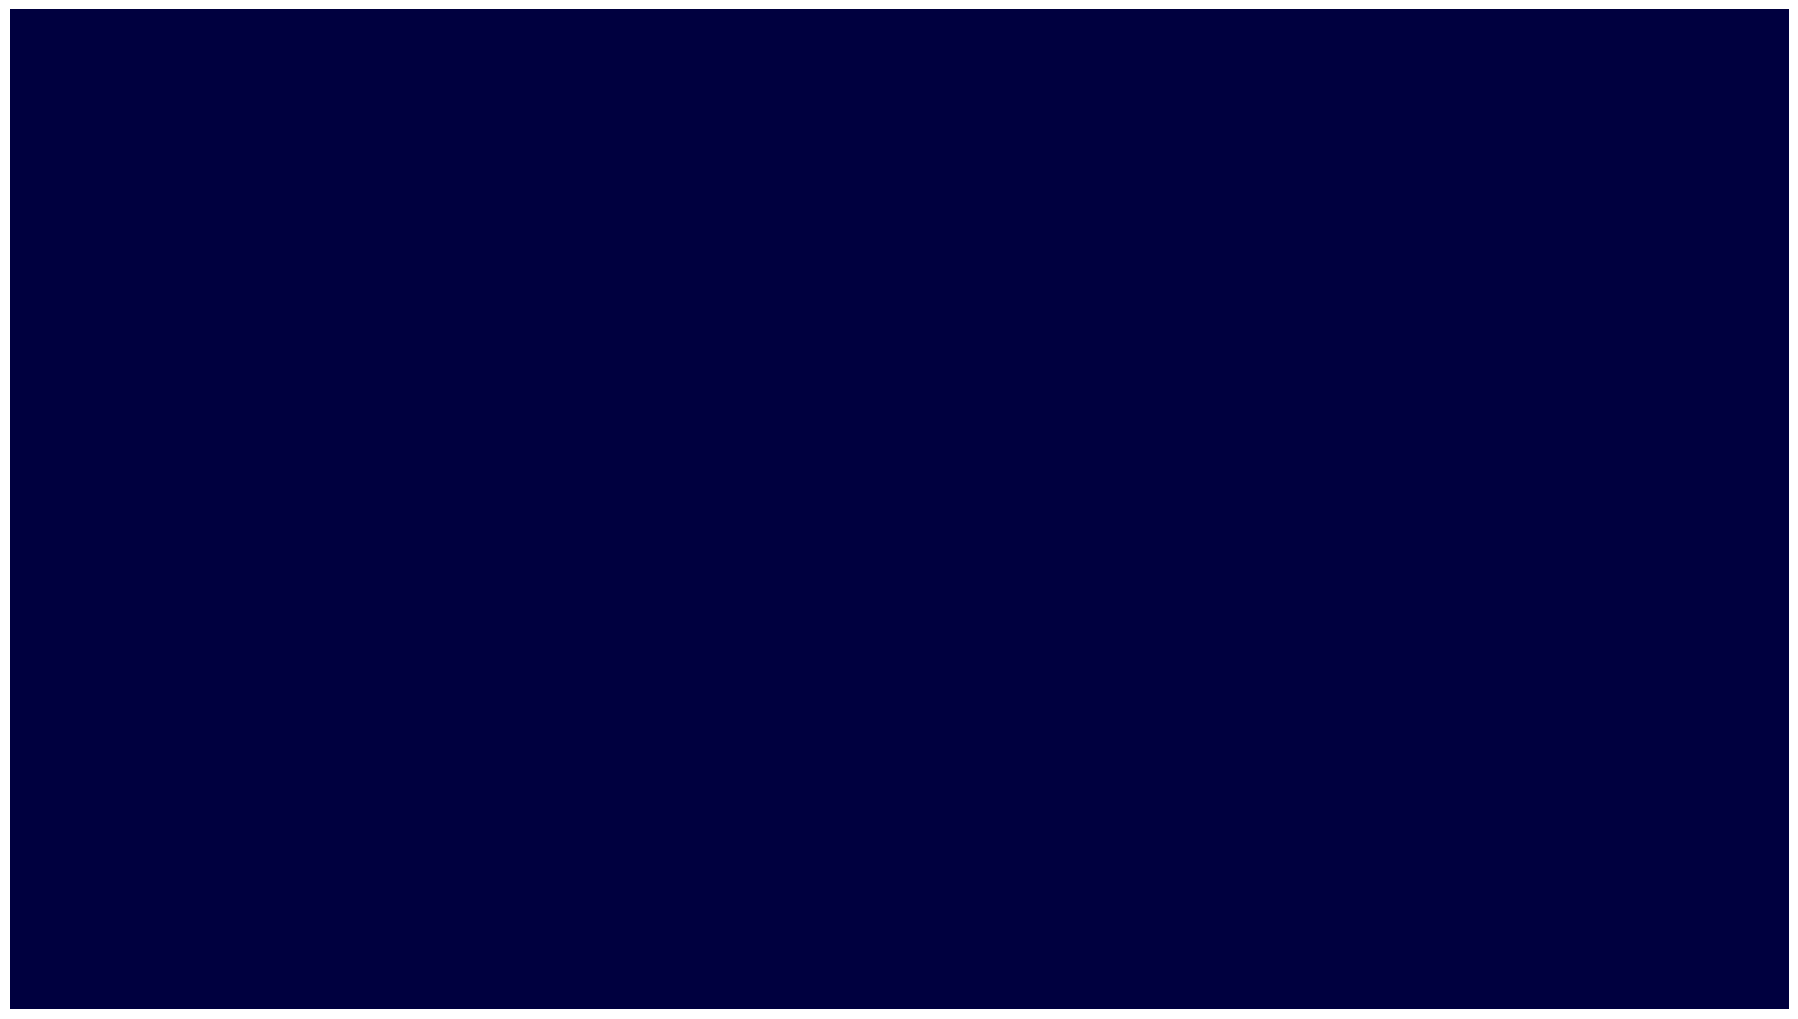

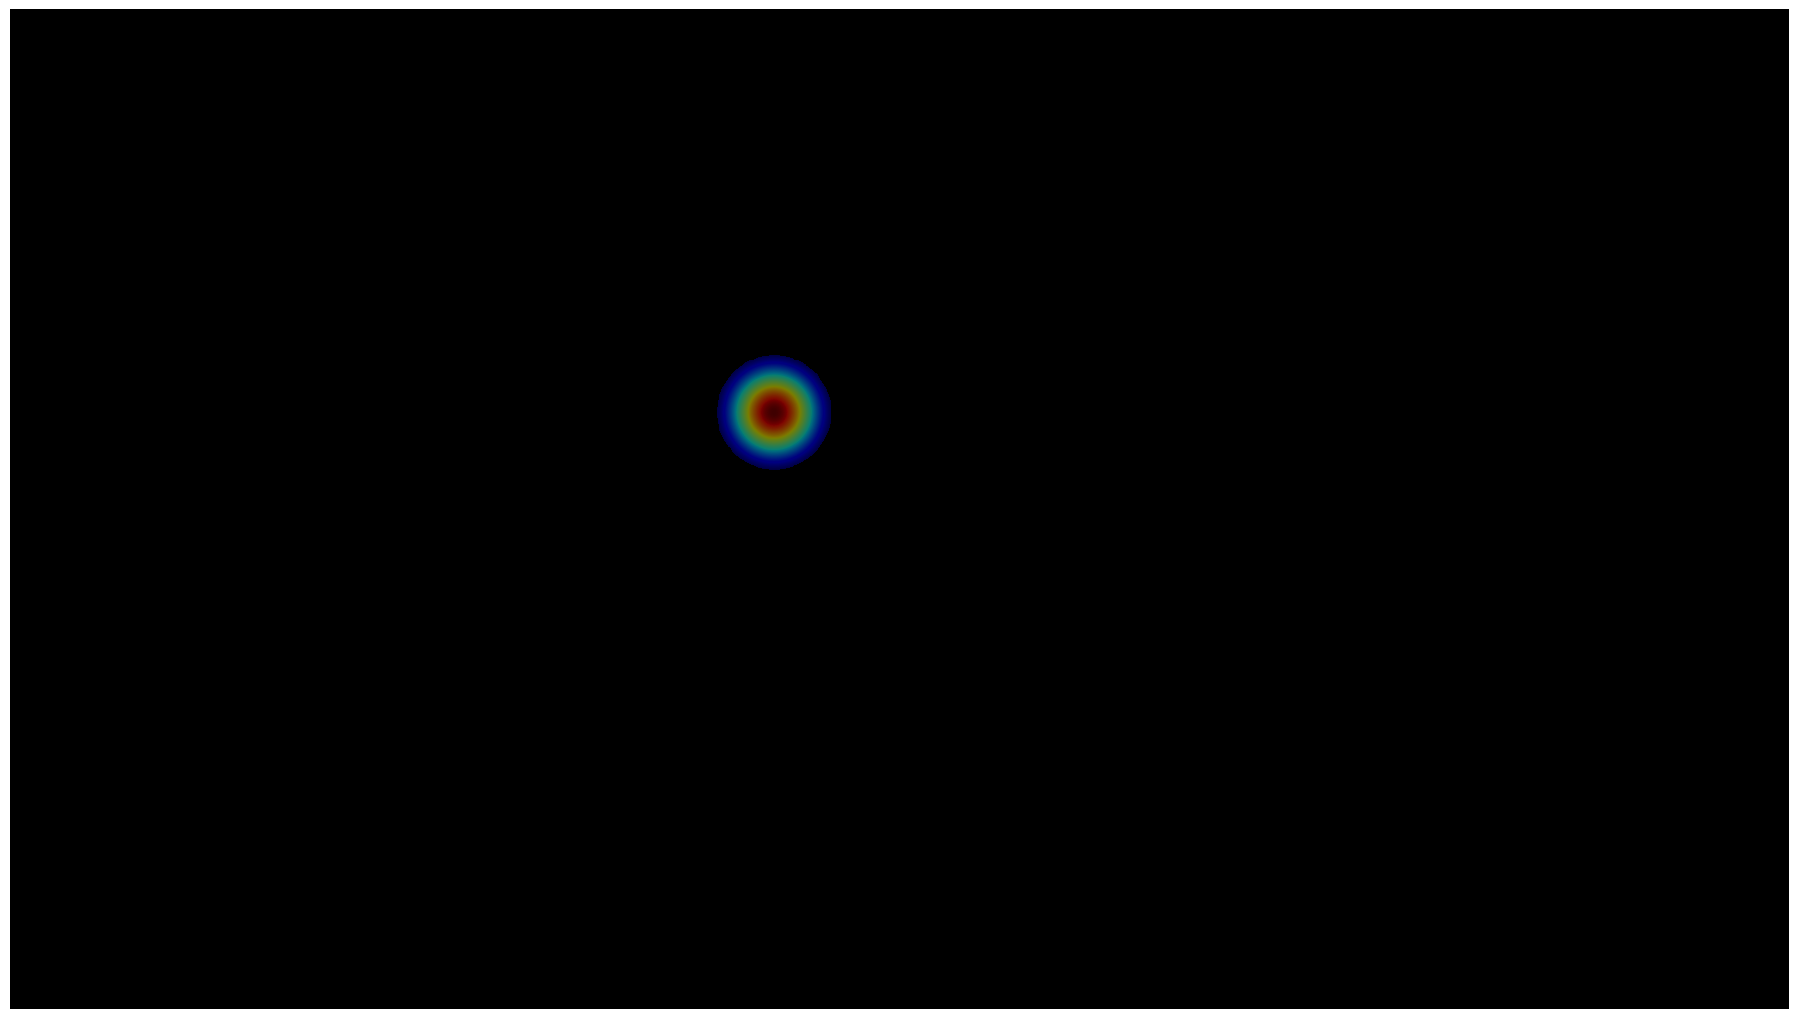

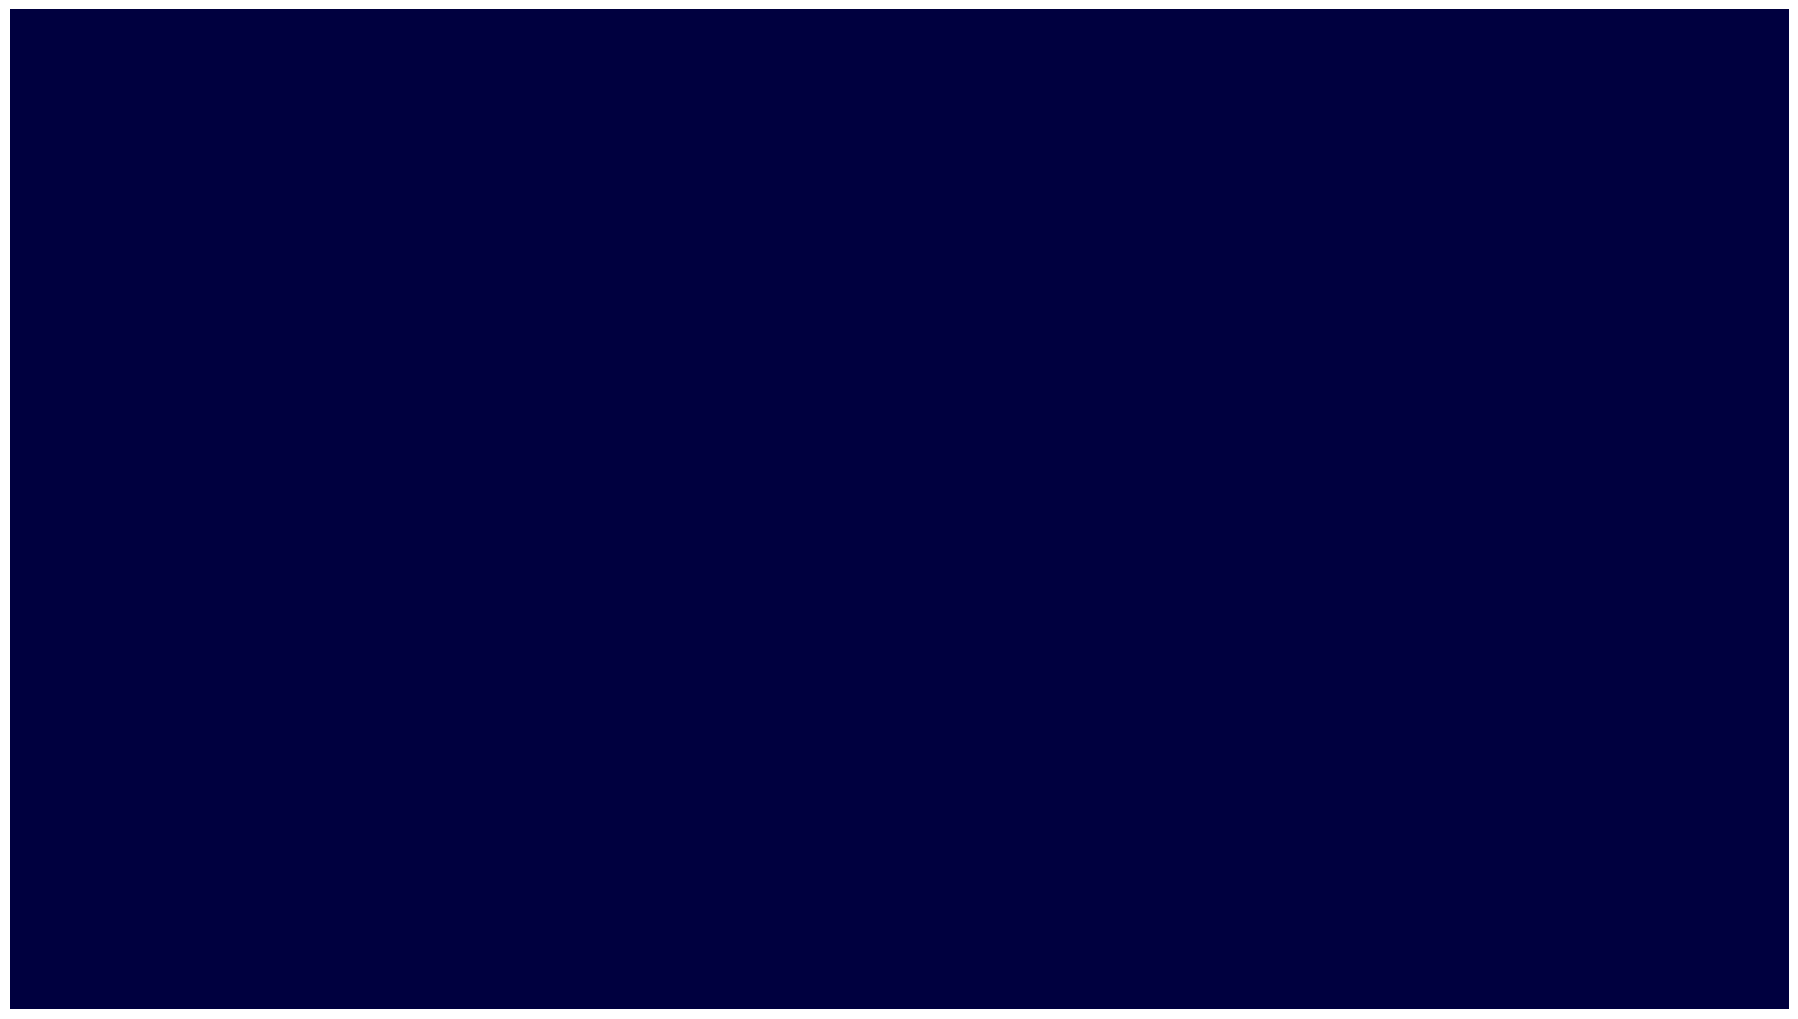

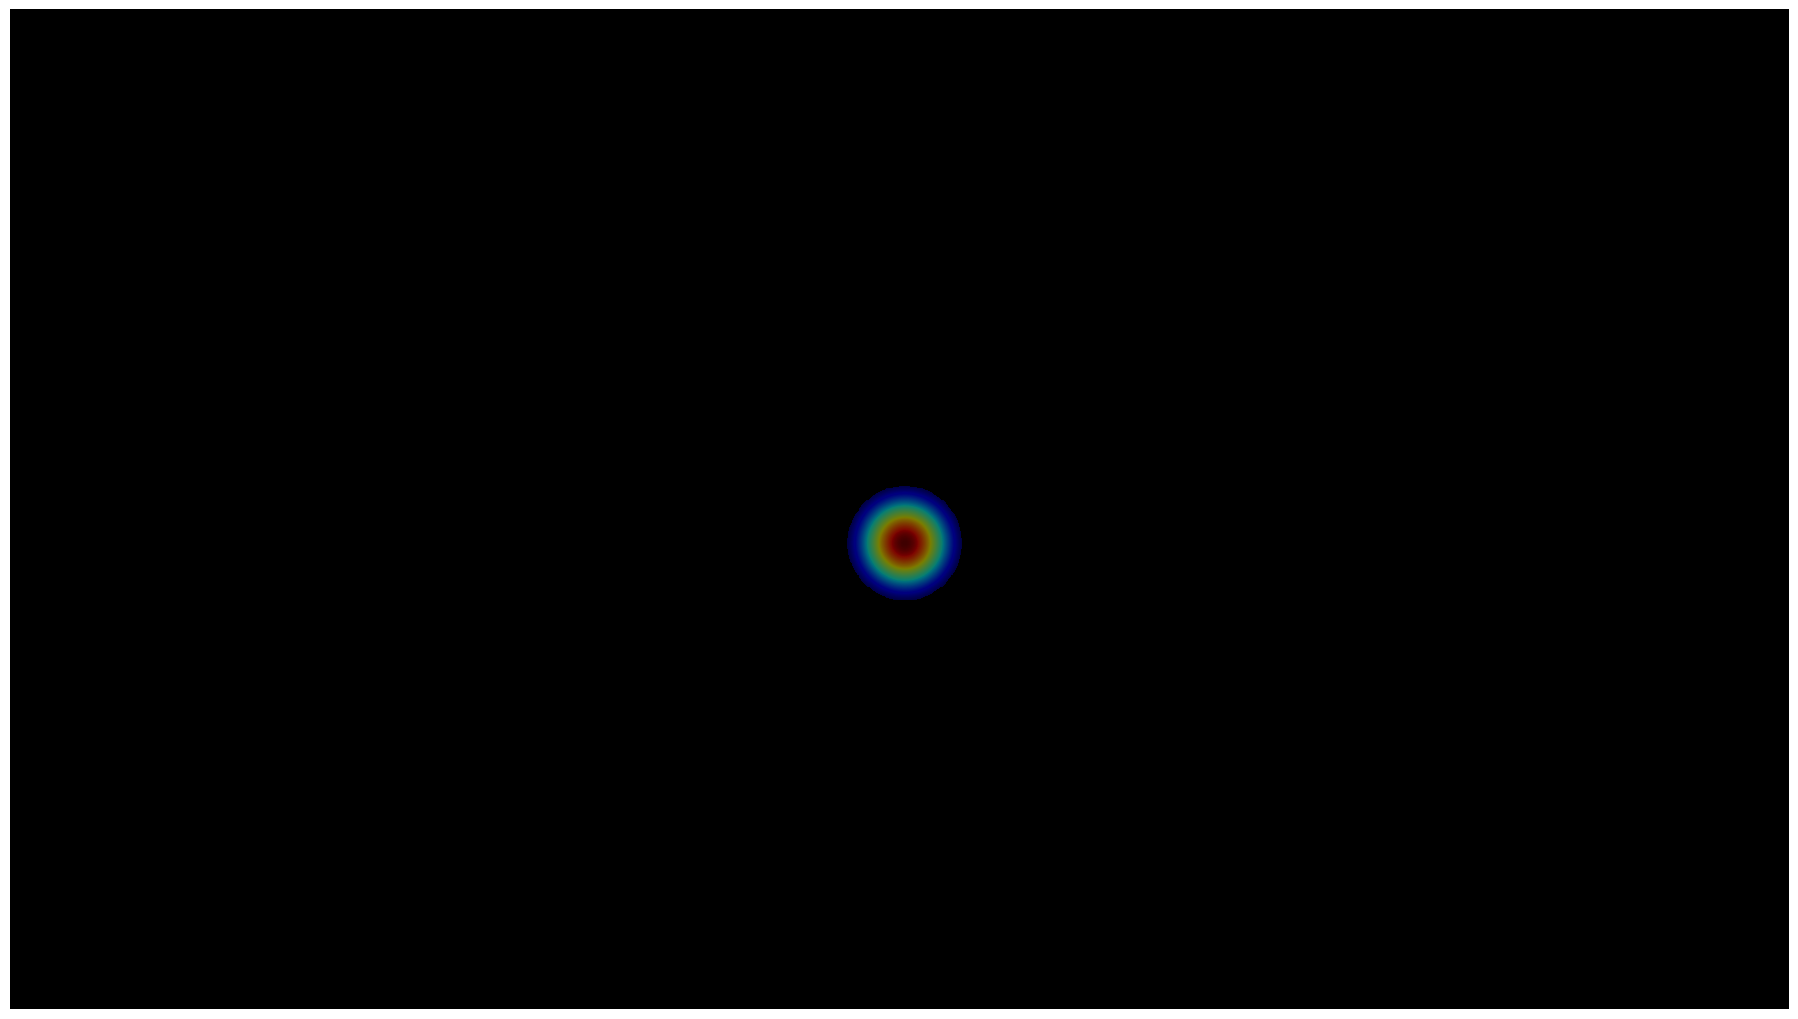

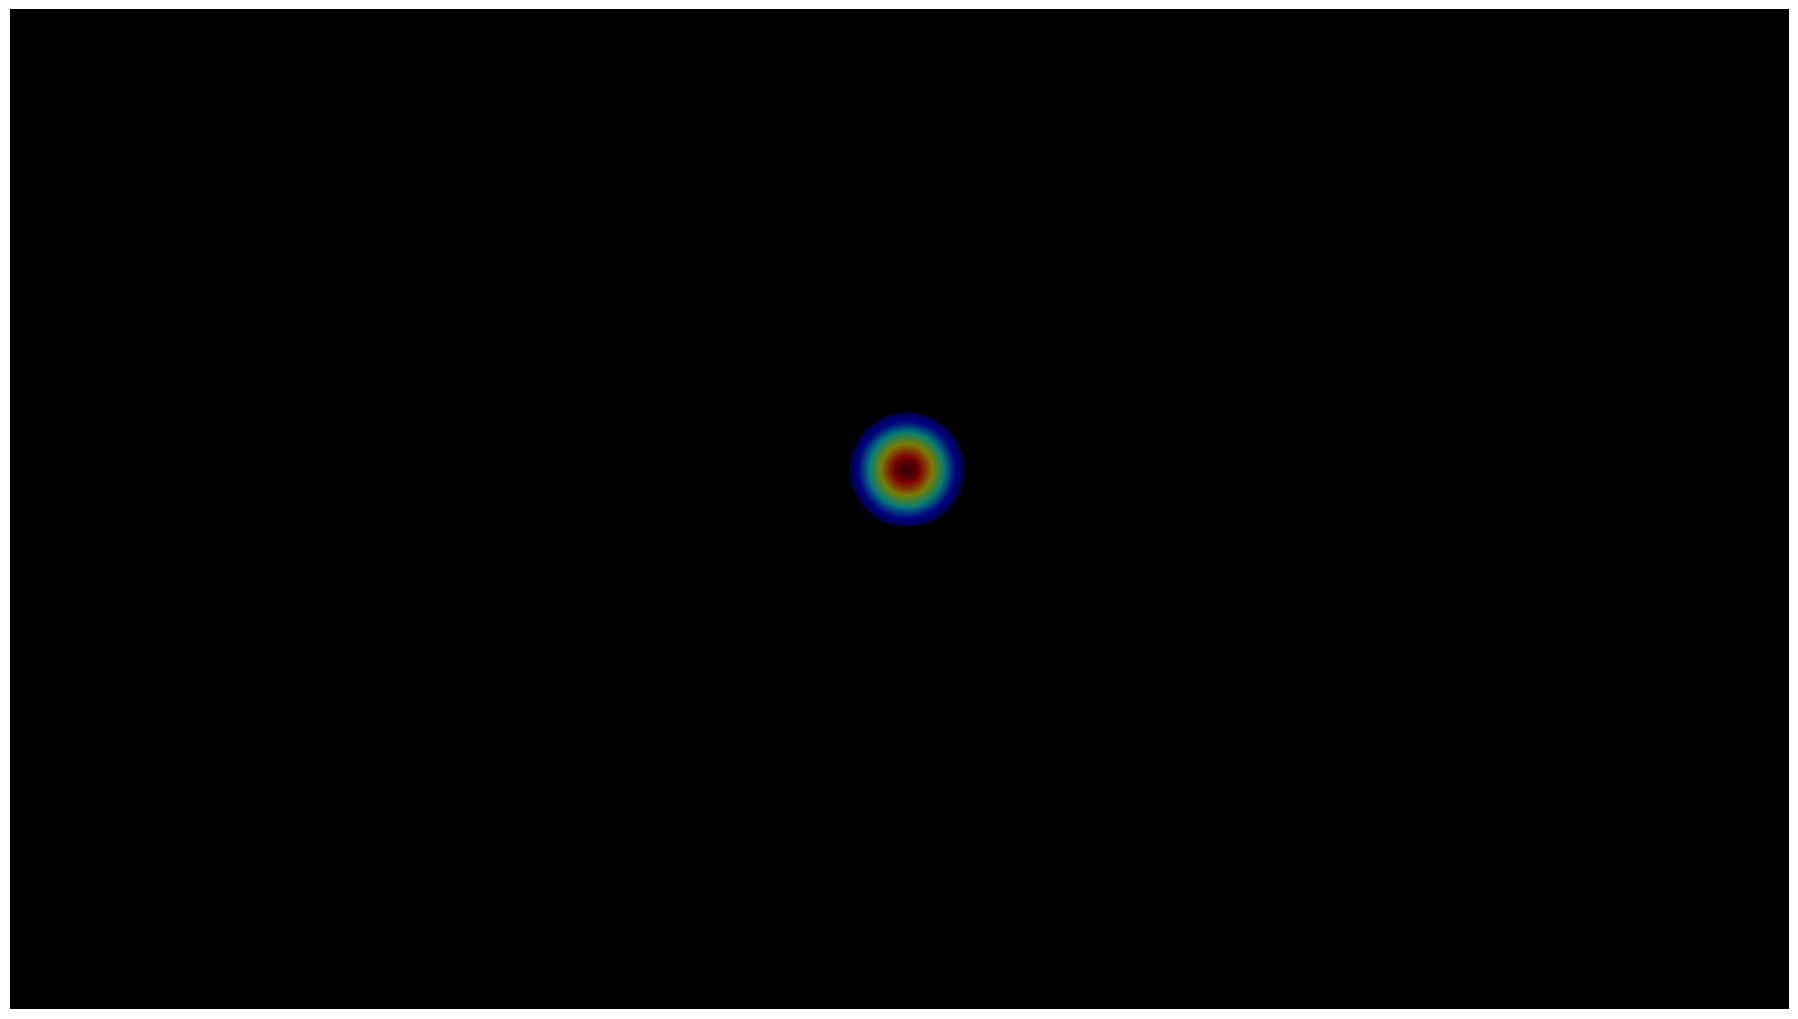

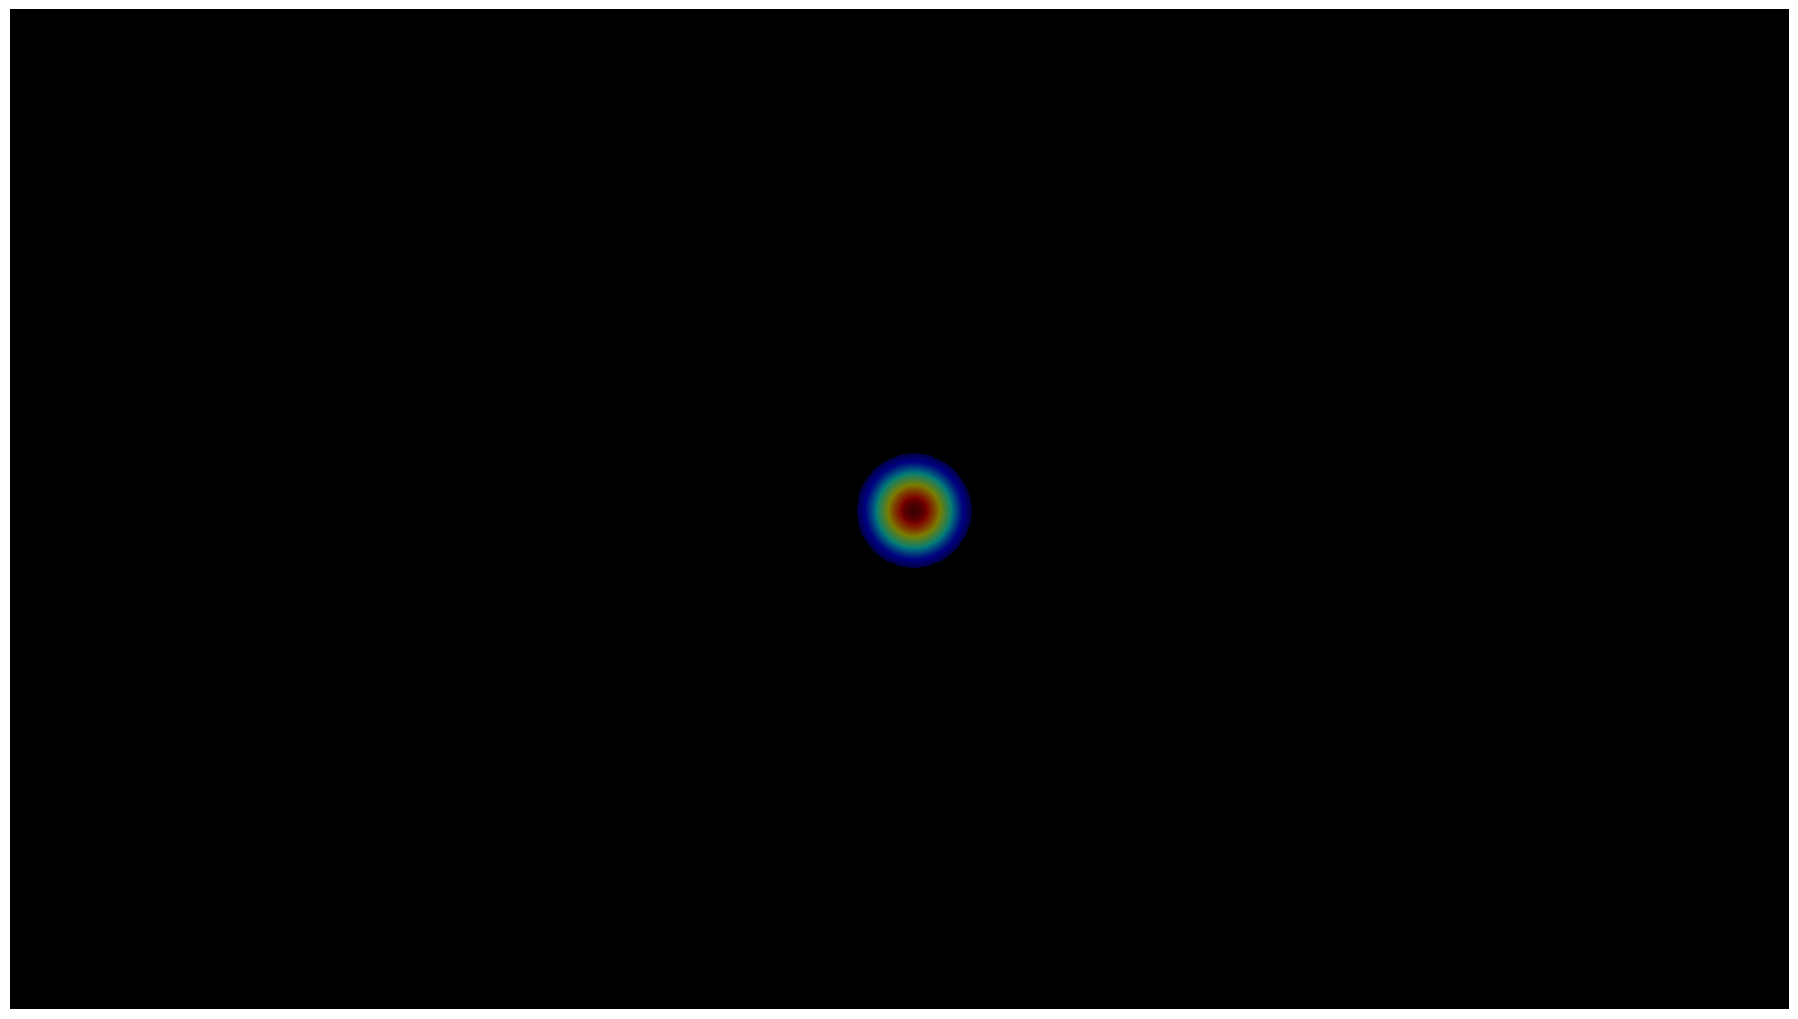

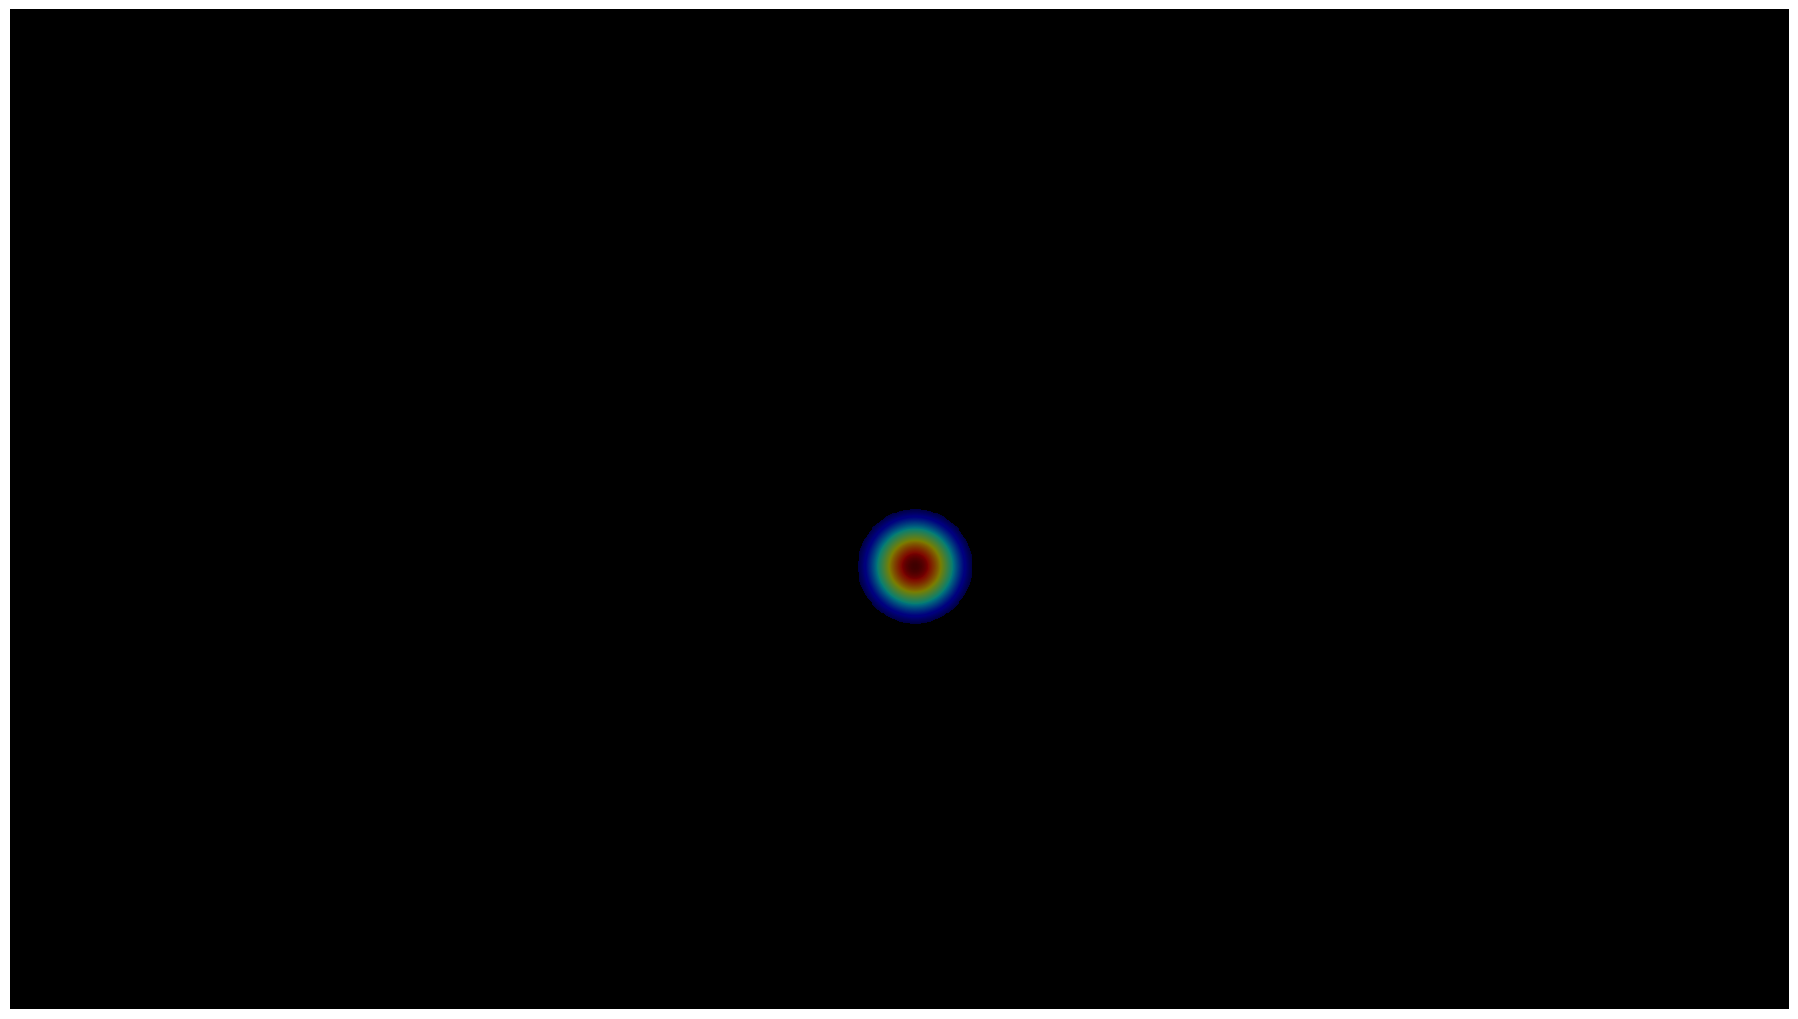

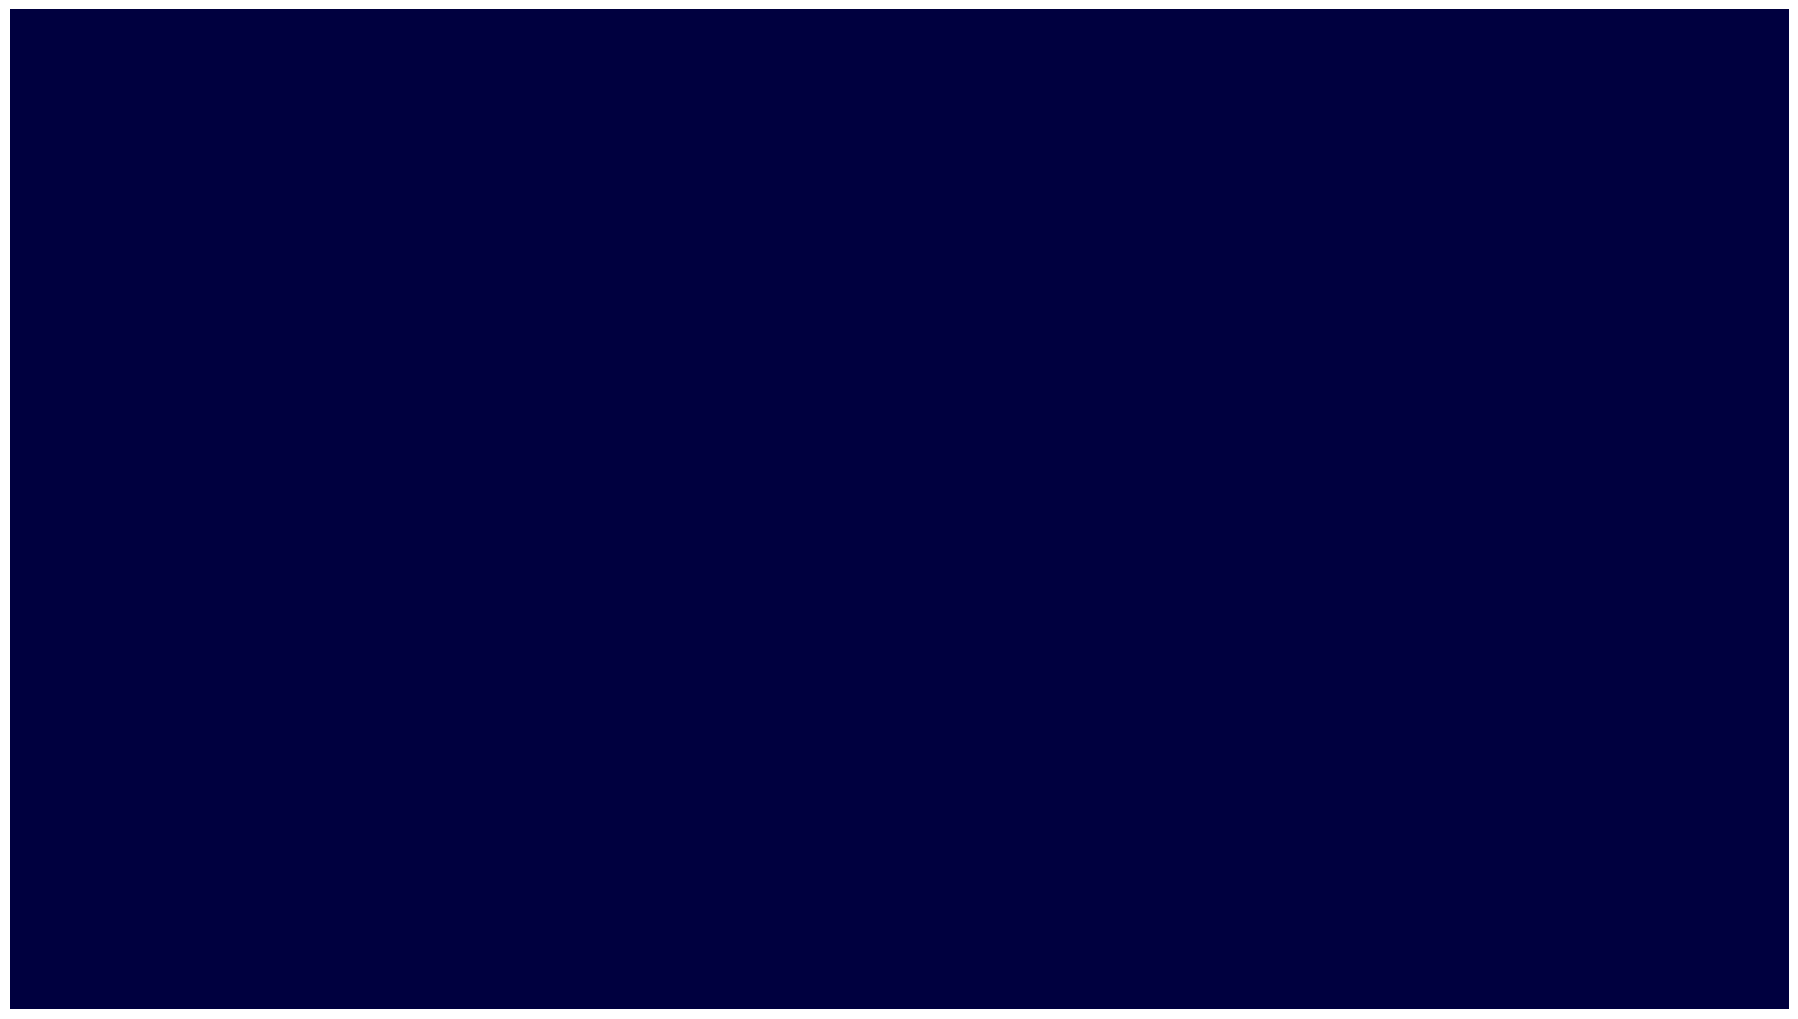

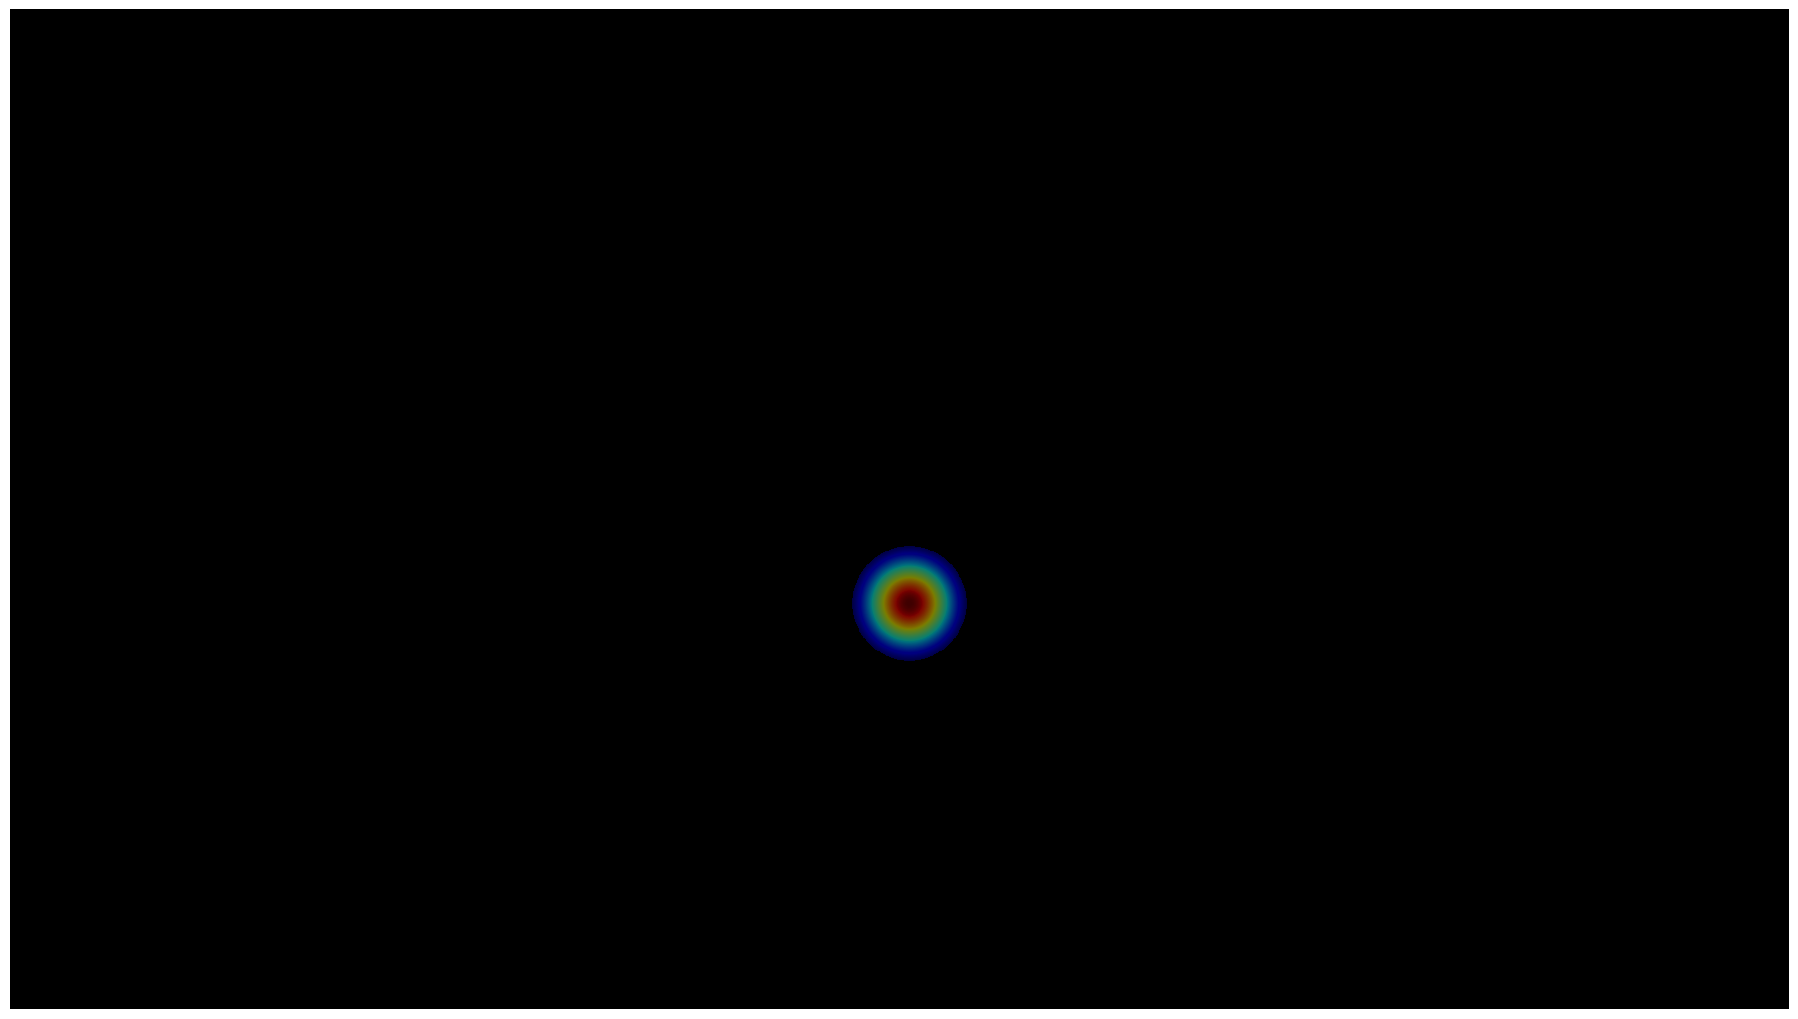

In [242]:
### Plot perceived noise_sample vs inattention

# parameters
partic_id = 'G036'
game_nr   = 16
trials    = np.arange(1,16,1)
dispsize  = (1919,1079) # (px,px) size of screen 

#initialize
x_cross_list,y_cross_list, center_x_list,center_y_list = [],[],[],[]
trial_success = []

#read stimulus data
data = read_data(partic_id,game_nr,phase='stimulus')


for trial_nr in (trials):
    #get crosshair position
    x_cross,y_cross = return_cross_pos(partic_id,game_nr,trial_nr)
    if x_cross!=0:
        ###get centroid
        
        #fixations
        fixations = np.array(data[trial_nr]['events']['Efix'])
        fig_heatmap = draw_heatmap(fixations, dispsize)
        #save heatmap
        fig_heatmap.savefig('img_1.png')

        #feed heatmap to the function
        image_load = cv2.imread('img_1.png',0)
        center,_,image_out = return_centroid_heatmap(image_load)
        #print(center)
        if center.size!=0:
            #print(center)
            if center.shape[0]>1:
                #print(center.shape)
                center = center[0] #CHANGE LATER!!!
            #plot center - cross hair distance
            #dist = np.sqrt((x_cross-center[0][0])**2 + (y_cross-center[0][1])**2)
            #plt.scatter(trial_nr,dist)
            x_cross_list.append(x_cross)
            y_cross_list.append(y_cross)
            center_x_list.append(center[0][0])
            center_y_list.append(center[0][1])
            trial_success.append(trial_nr)



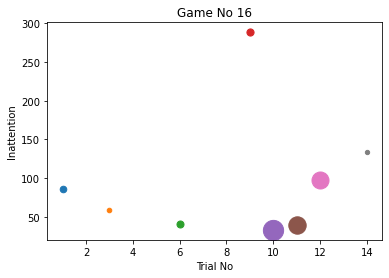

In [243]:
#calculate distances from center point
dist = np.sqrt((np.array(center_x_list) - np.array(x_cross_list))**2 +
               (np.array(center_y_list) - np.array(y_cross_list))**2)


#get standard deviation
#load data set
fname = 'dataset_0423.csv'
data_set = load_dataset_properties(fname)
std_dev_list =[]
property_label= 'perc_noise_sample'
for trial_nr in trials:
    #check if successful trial
    if trial_nr in trial_success:
        std_dev = return_property_value(data_set,subject_id, game_nr+1,trial_nr,property_label)
        std_dev_list.append(std_dev)
        
std_dev_list = np.array(std_dev_list).astype(float)#/max(std_dev_list)

##plot the non-empty trials
fig,ax = plt.subplots()
for i,trial_nr in enumerate(trial_success):
    ax.plot(trial_nr,dist[i],'-o',markersize=std_dev_list[i])
    #print(dist[i],trial_nr)
    title = 'Game No {}'.format(game_nr)
    ax.set_title(title)
    ax.set_xlabel('Trial No')
    ax.set_ylabel('Inattention')
    
fig.savefig(title+'.png')

In [248]:
len(data)

16

C:\Users\adith\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adith\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


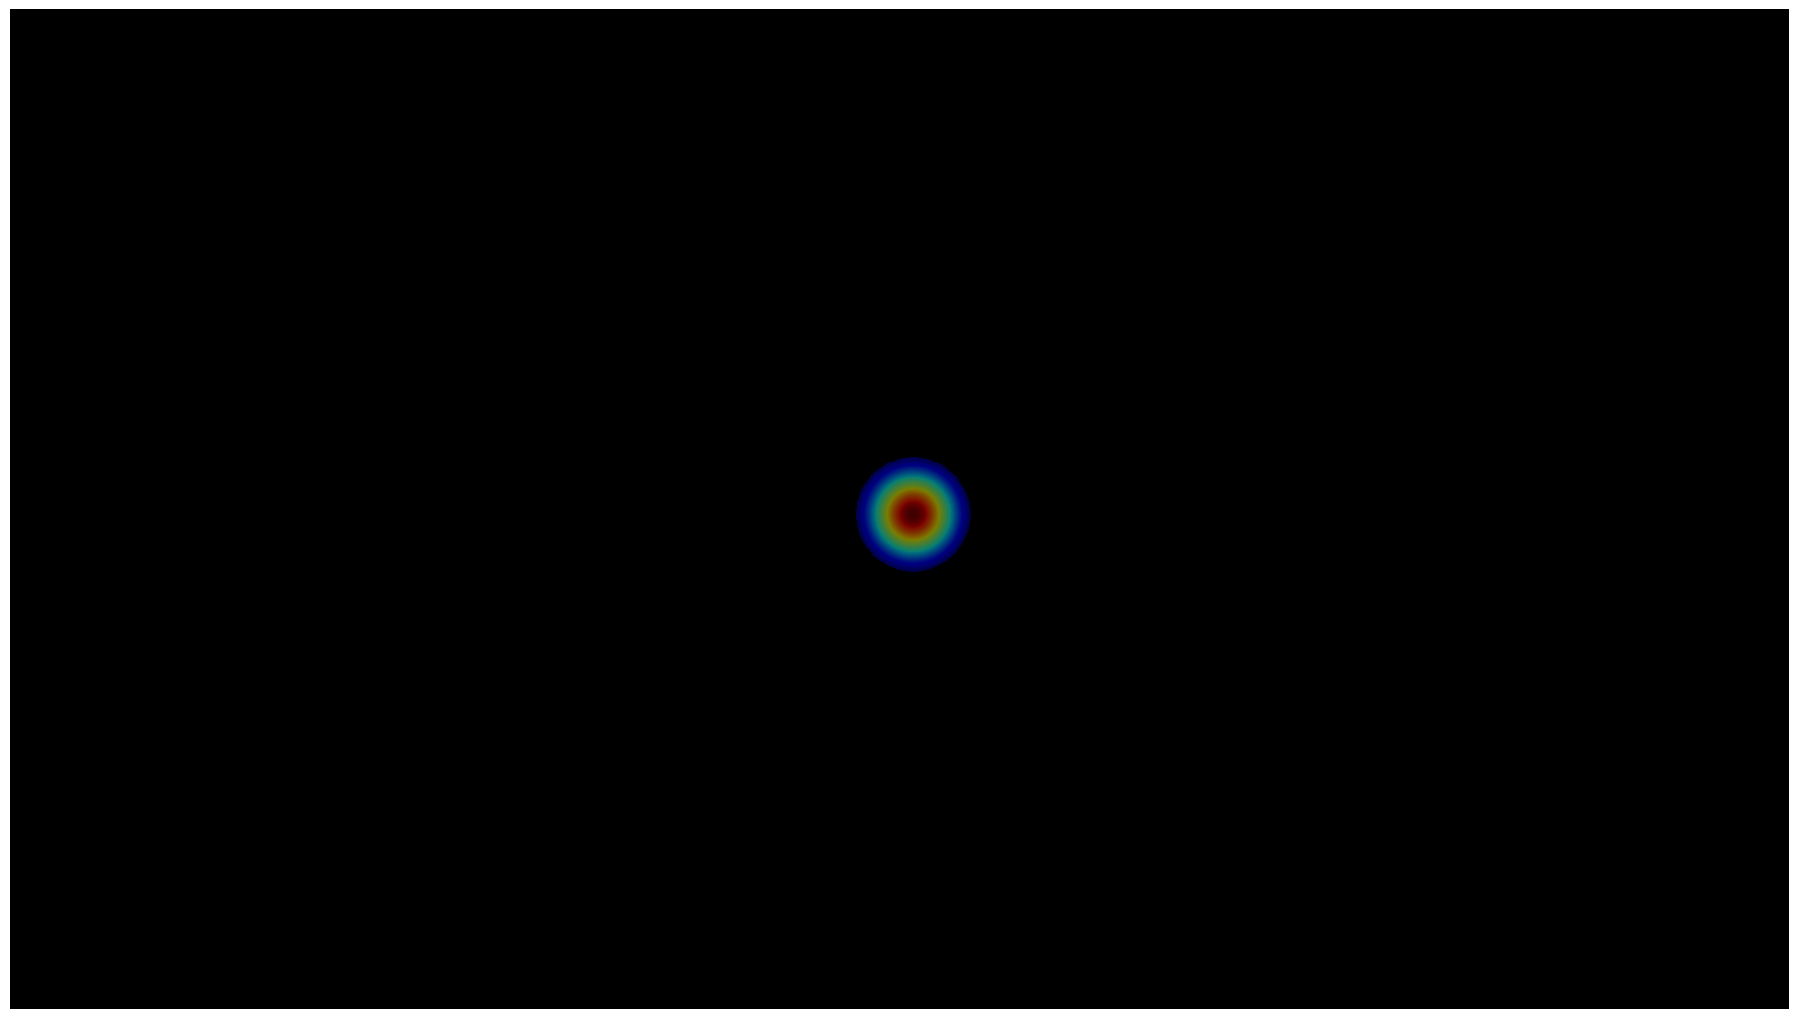

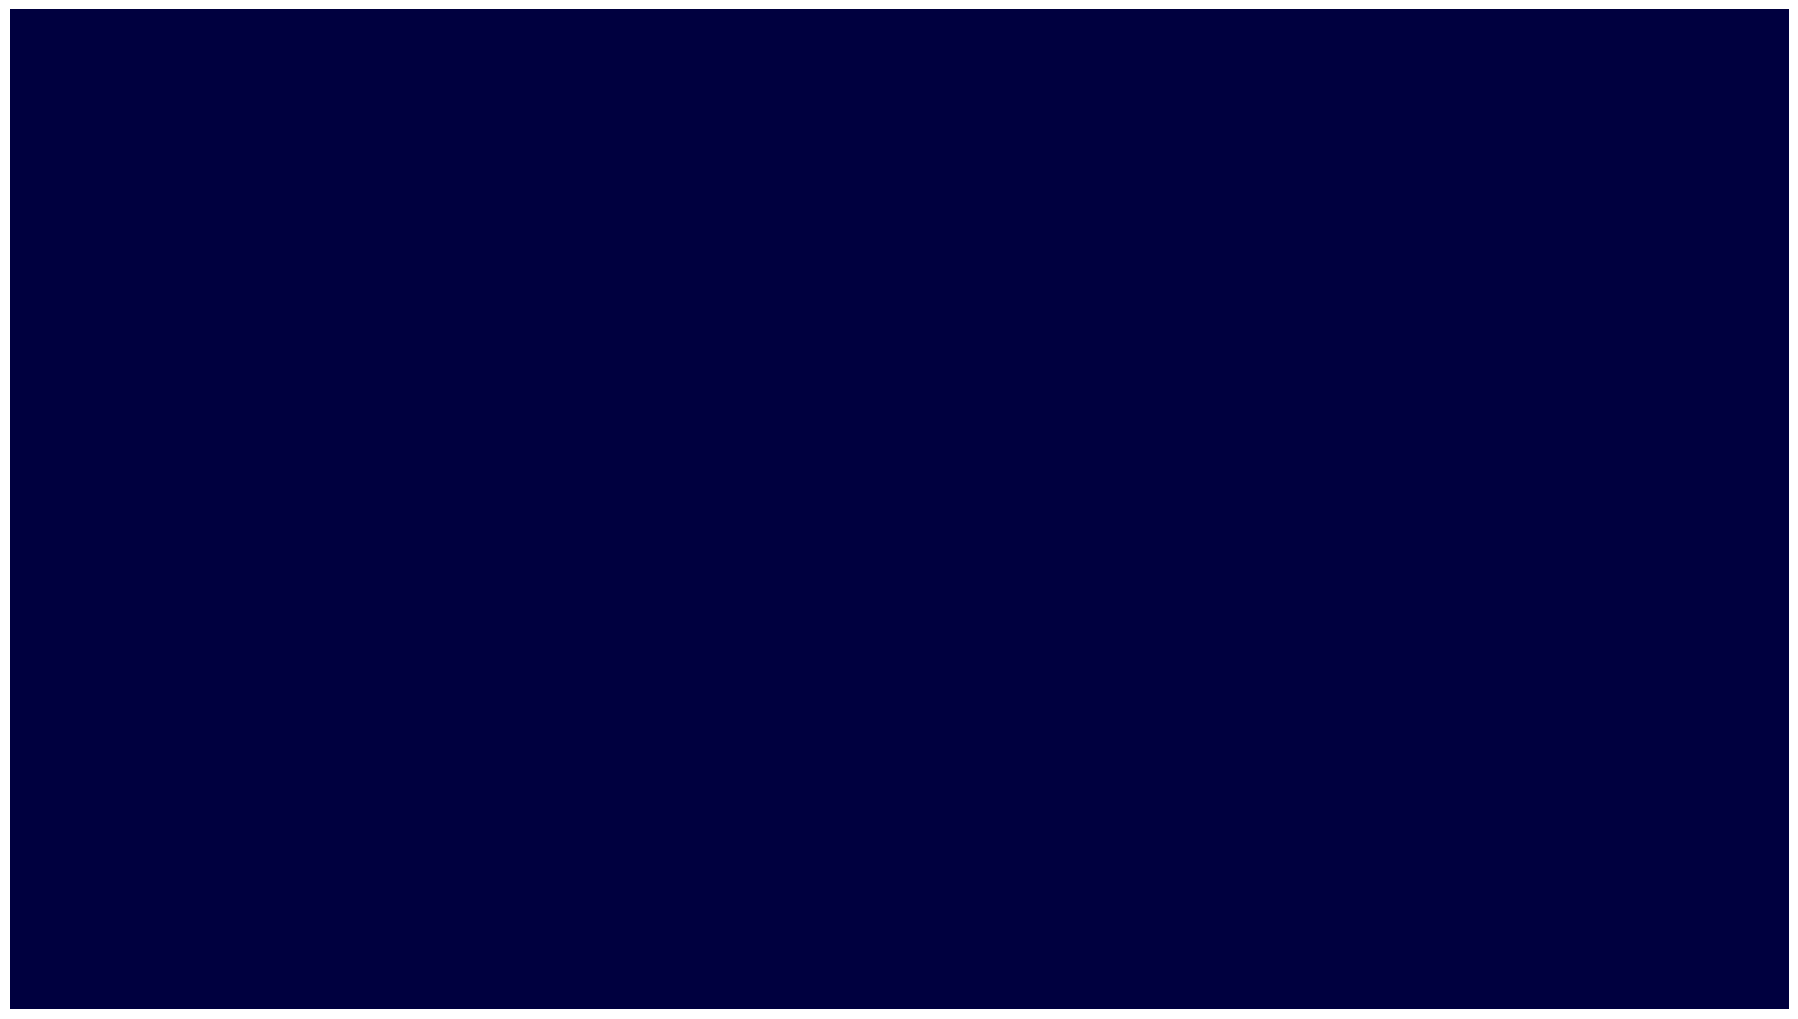

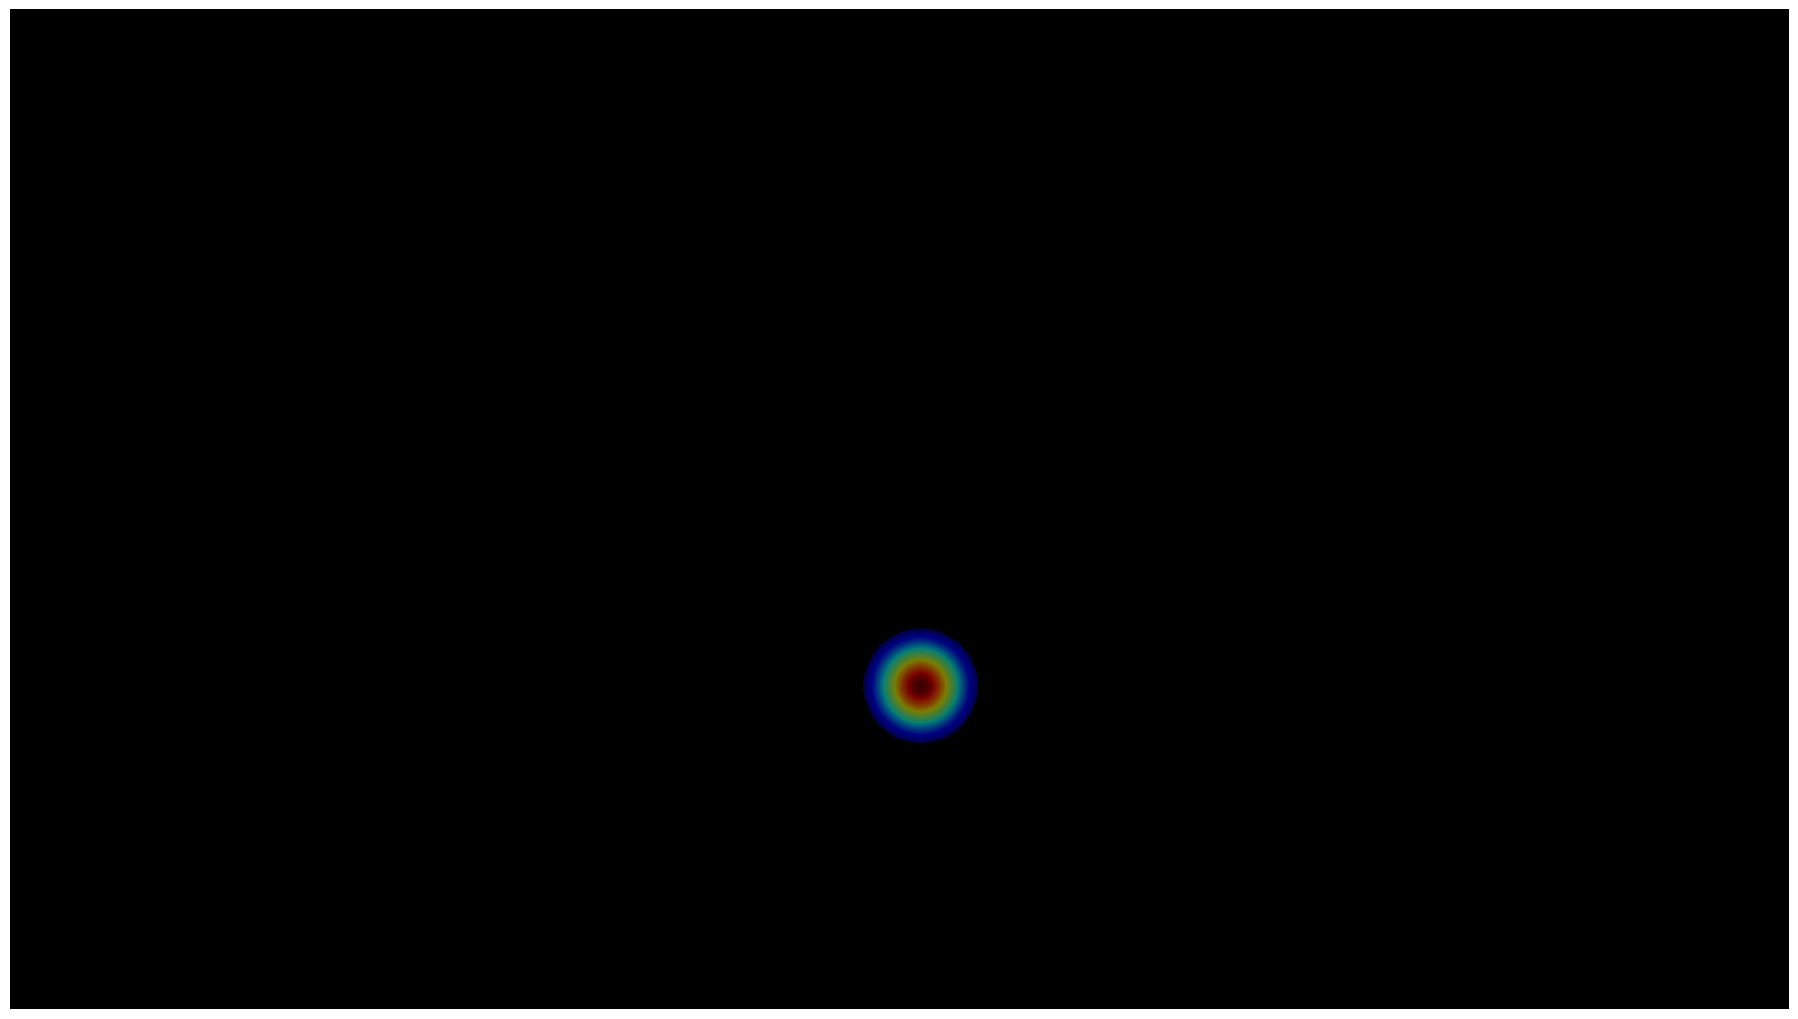

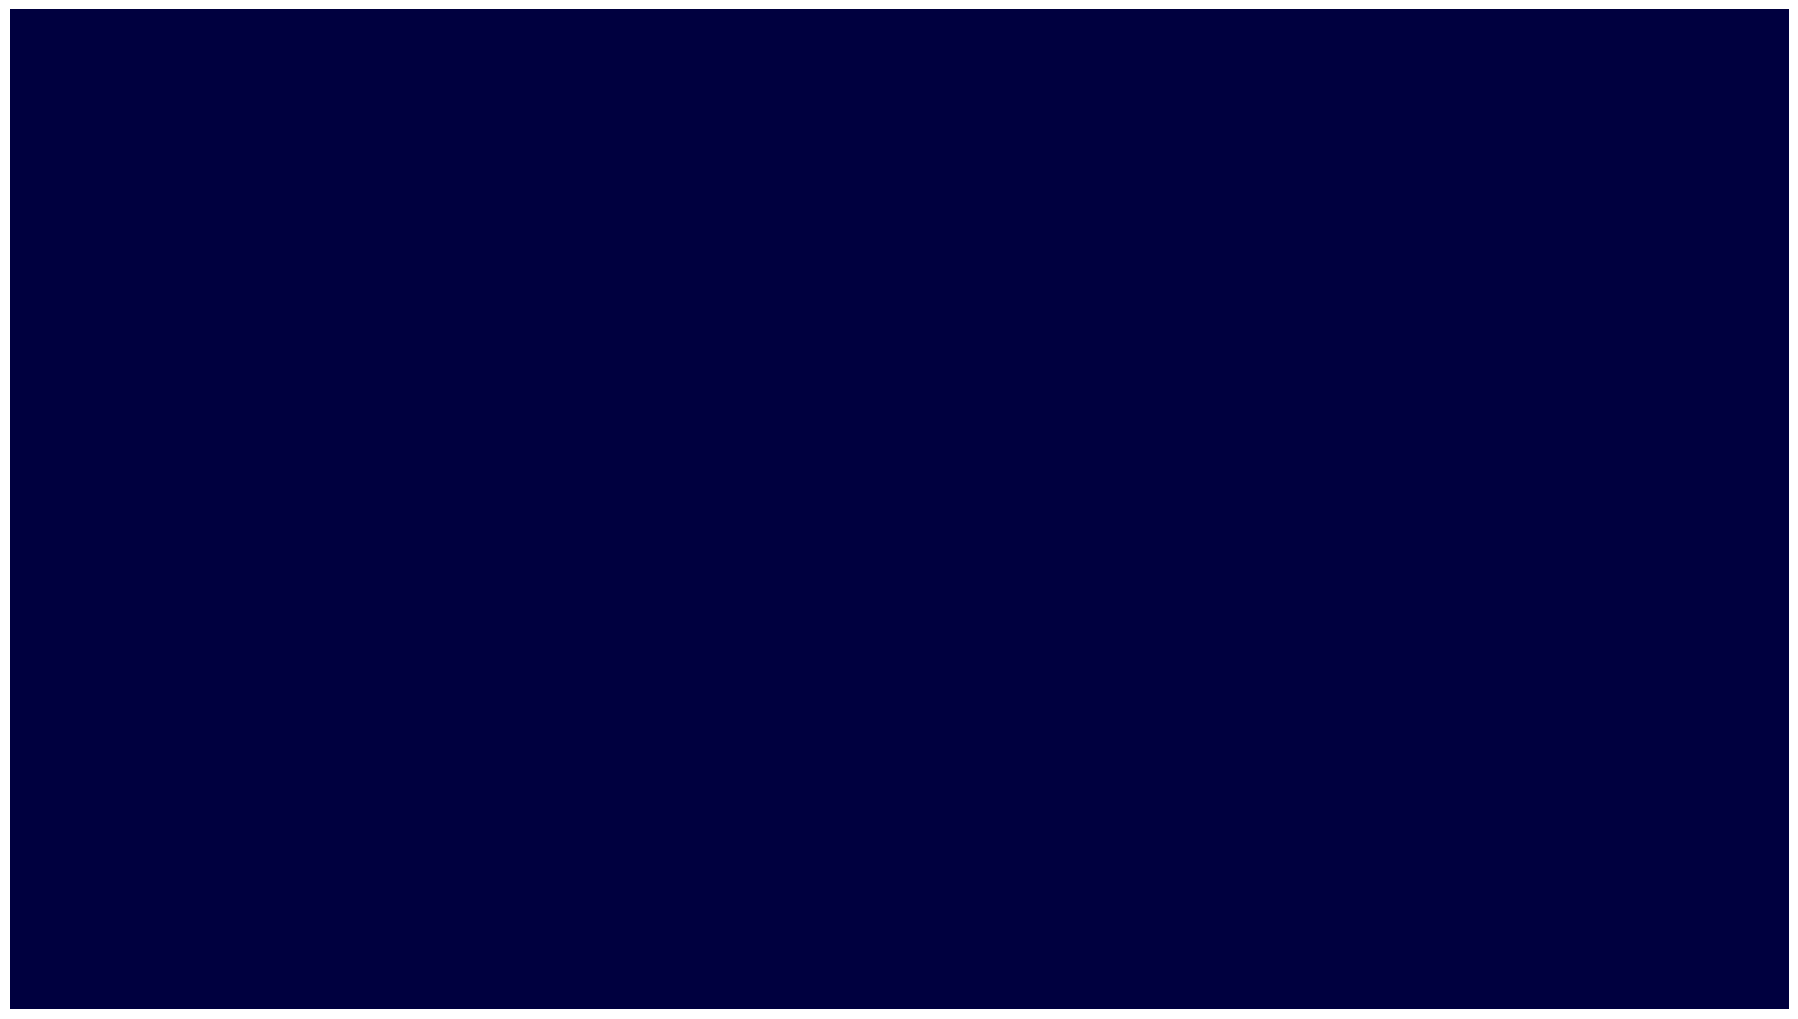

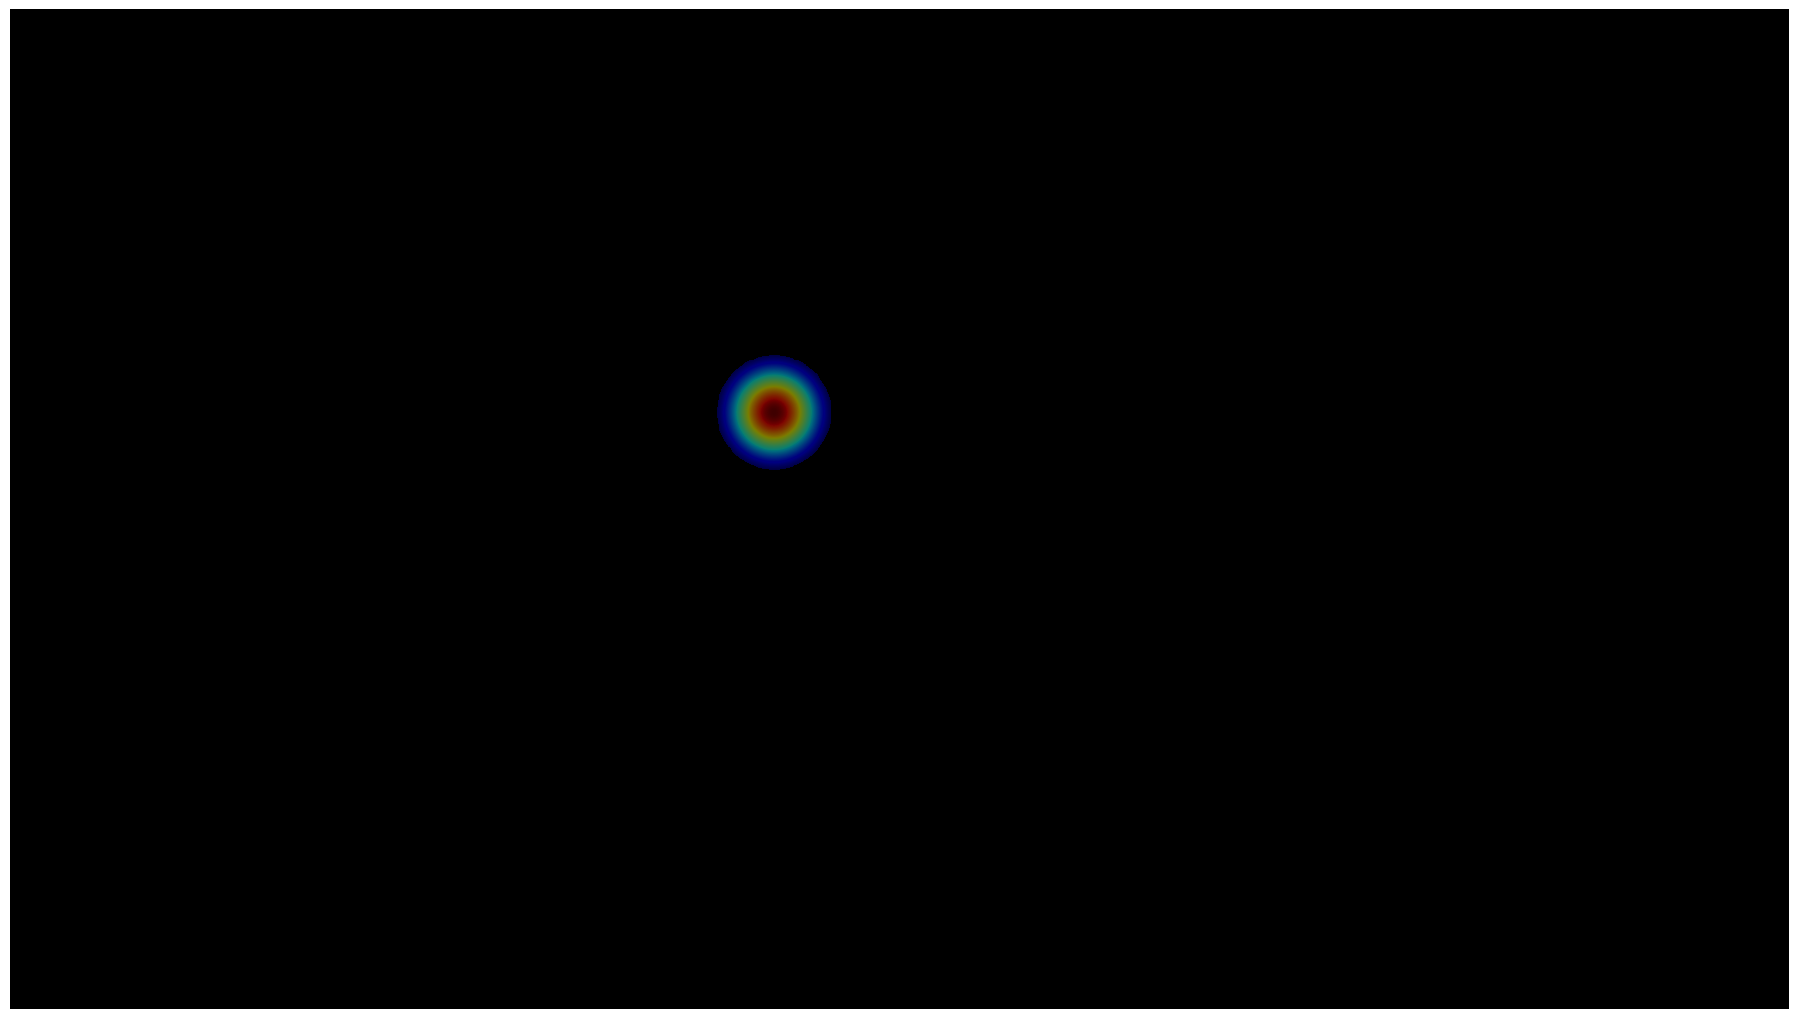

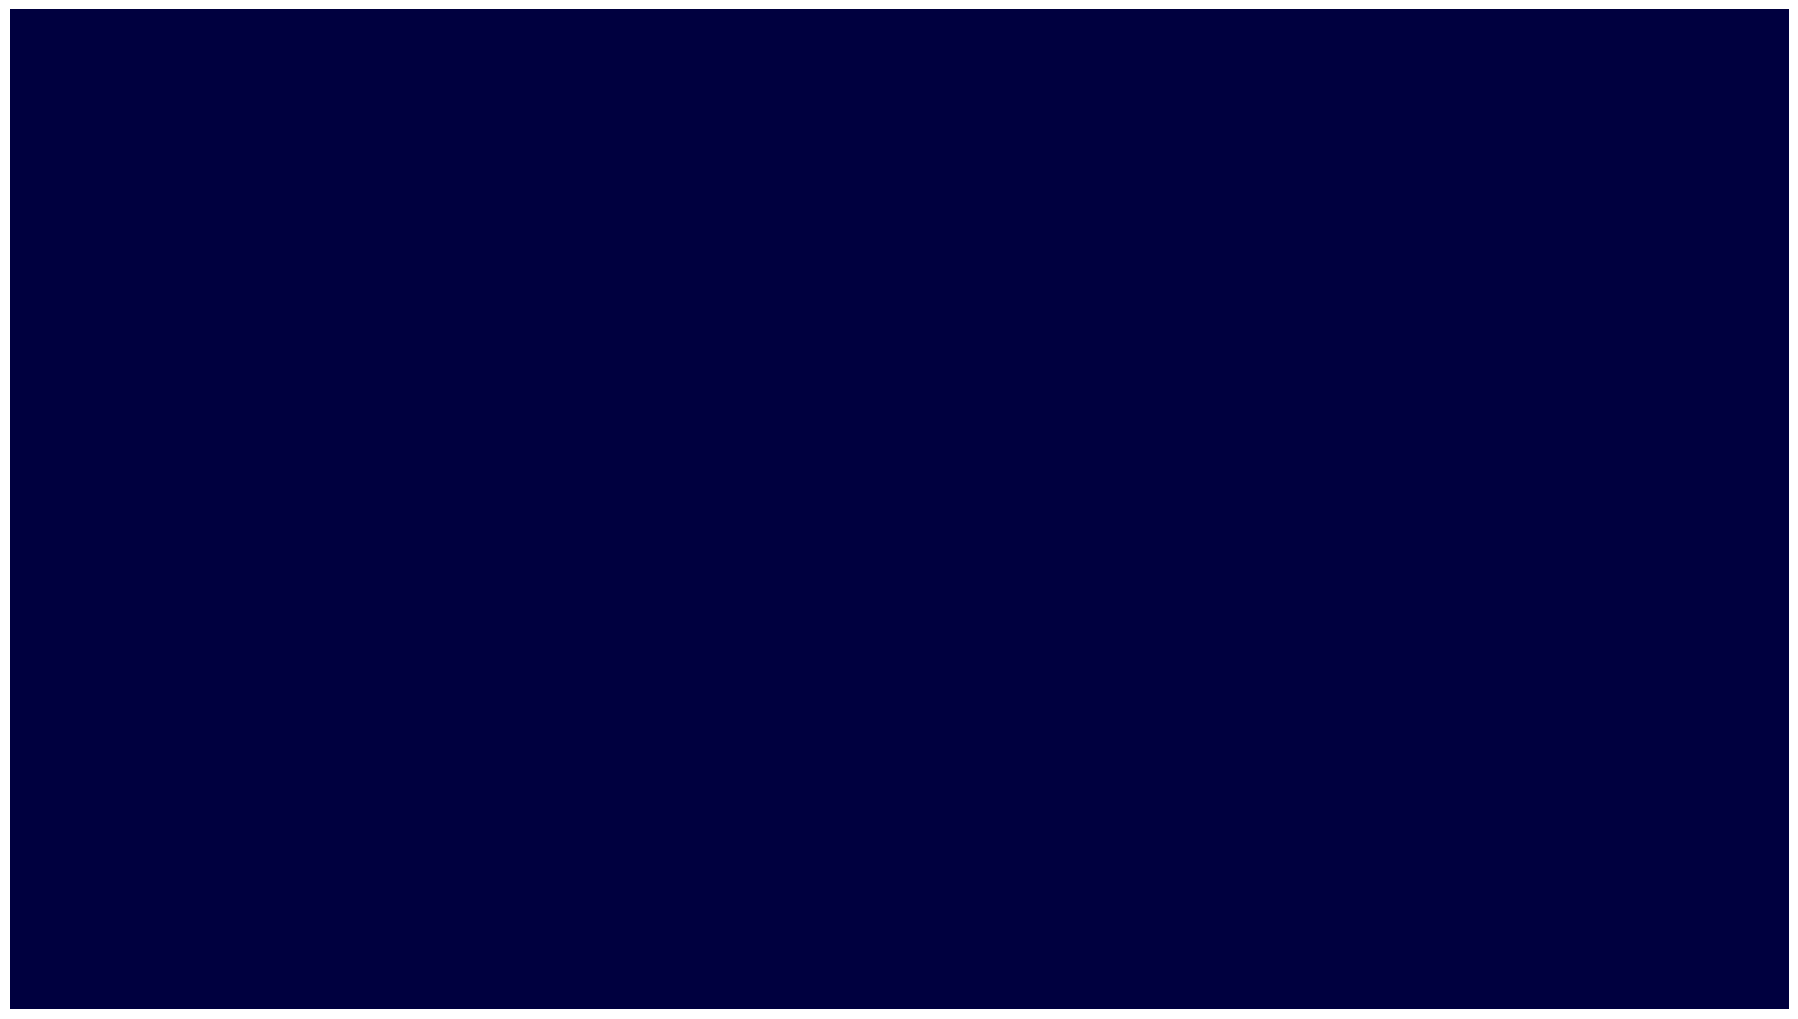

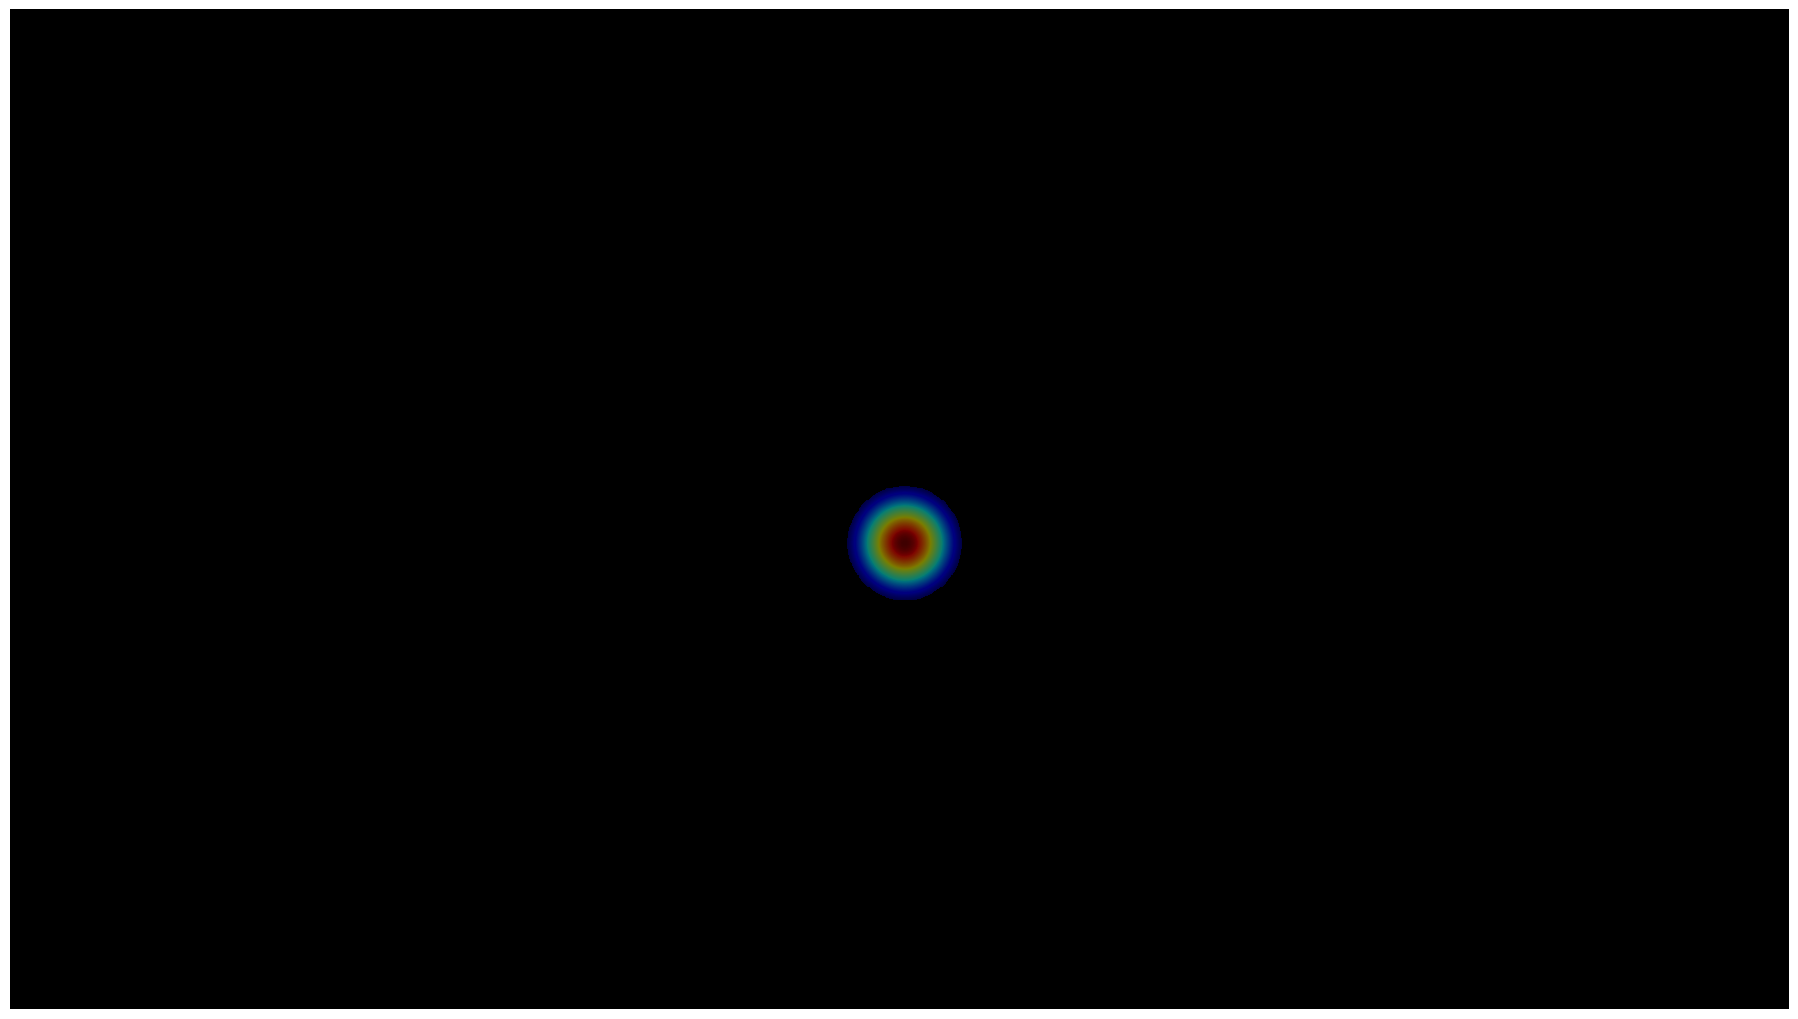

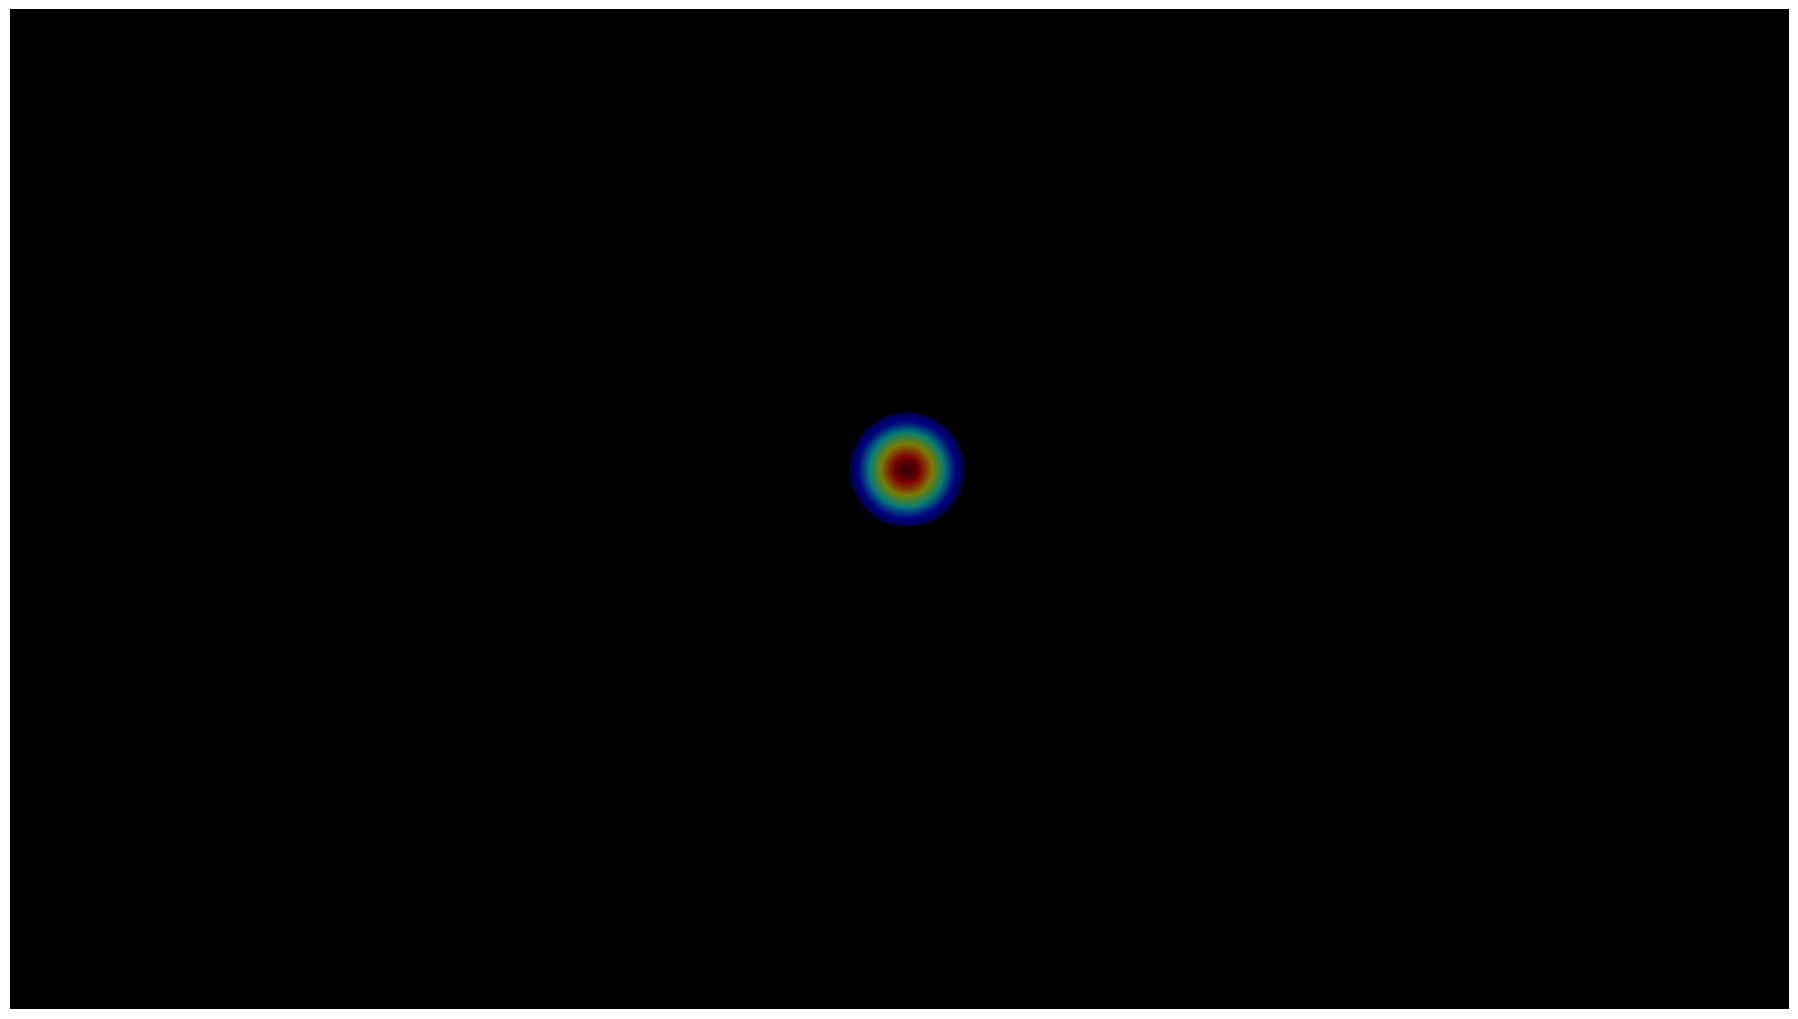

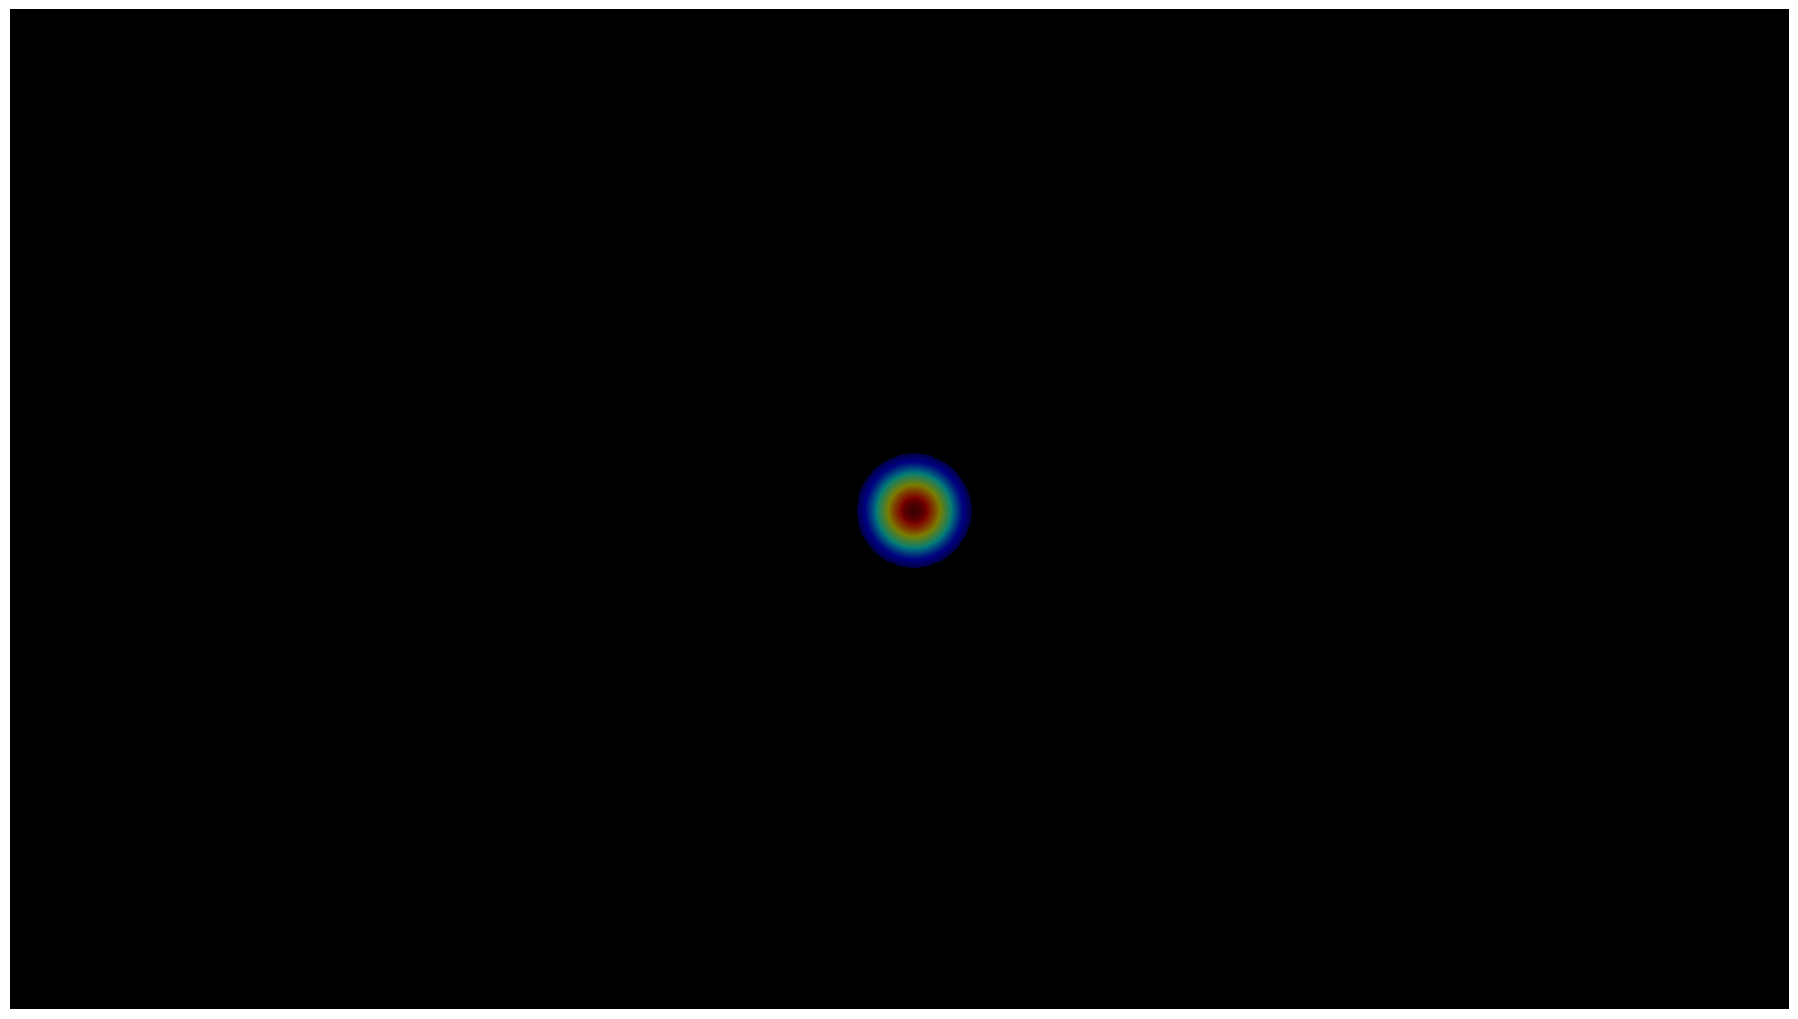

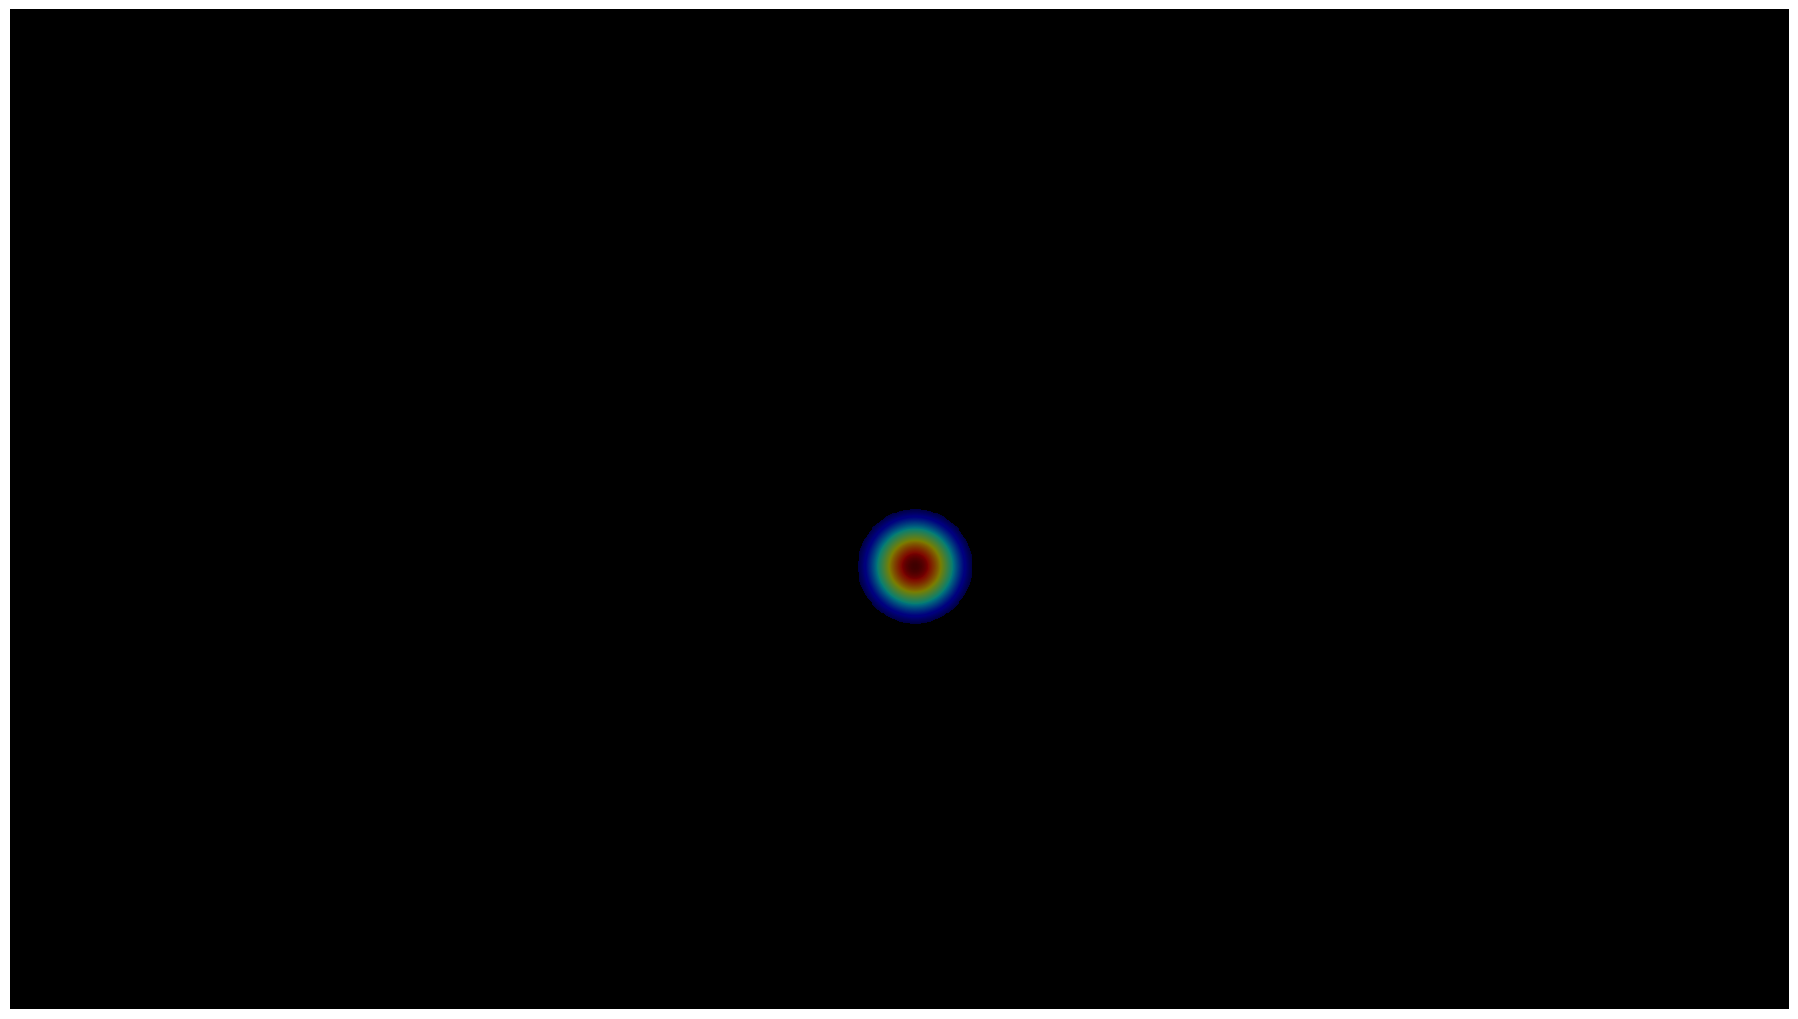

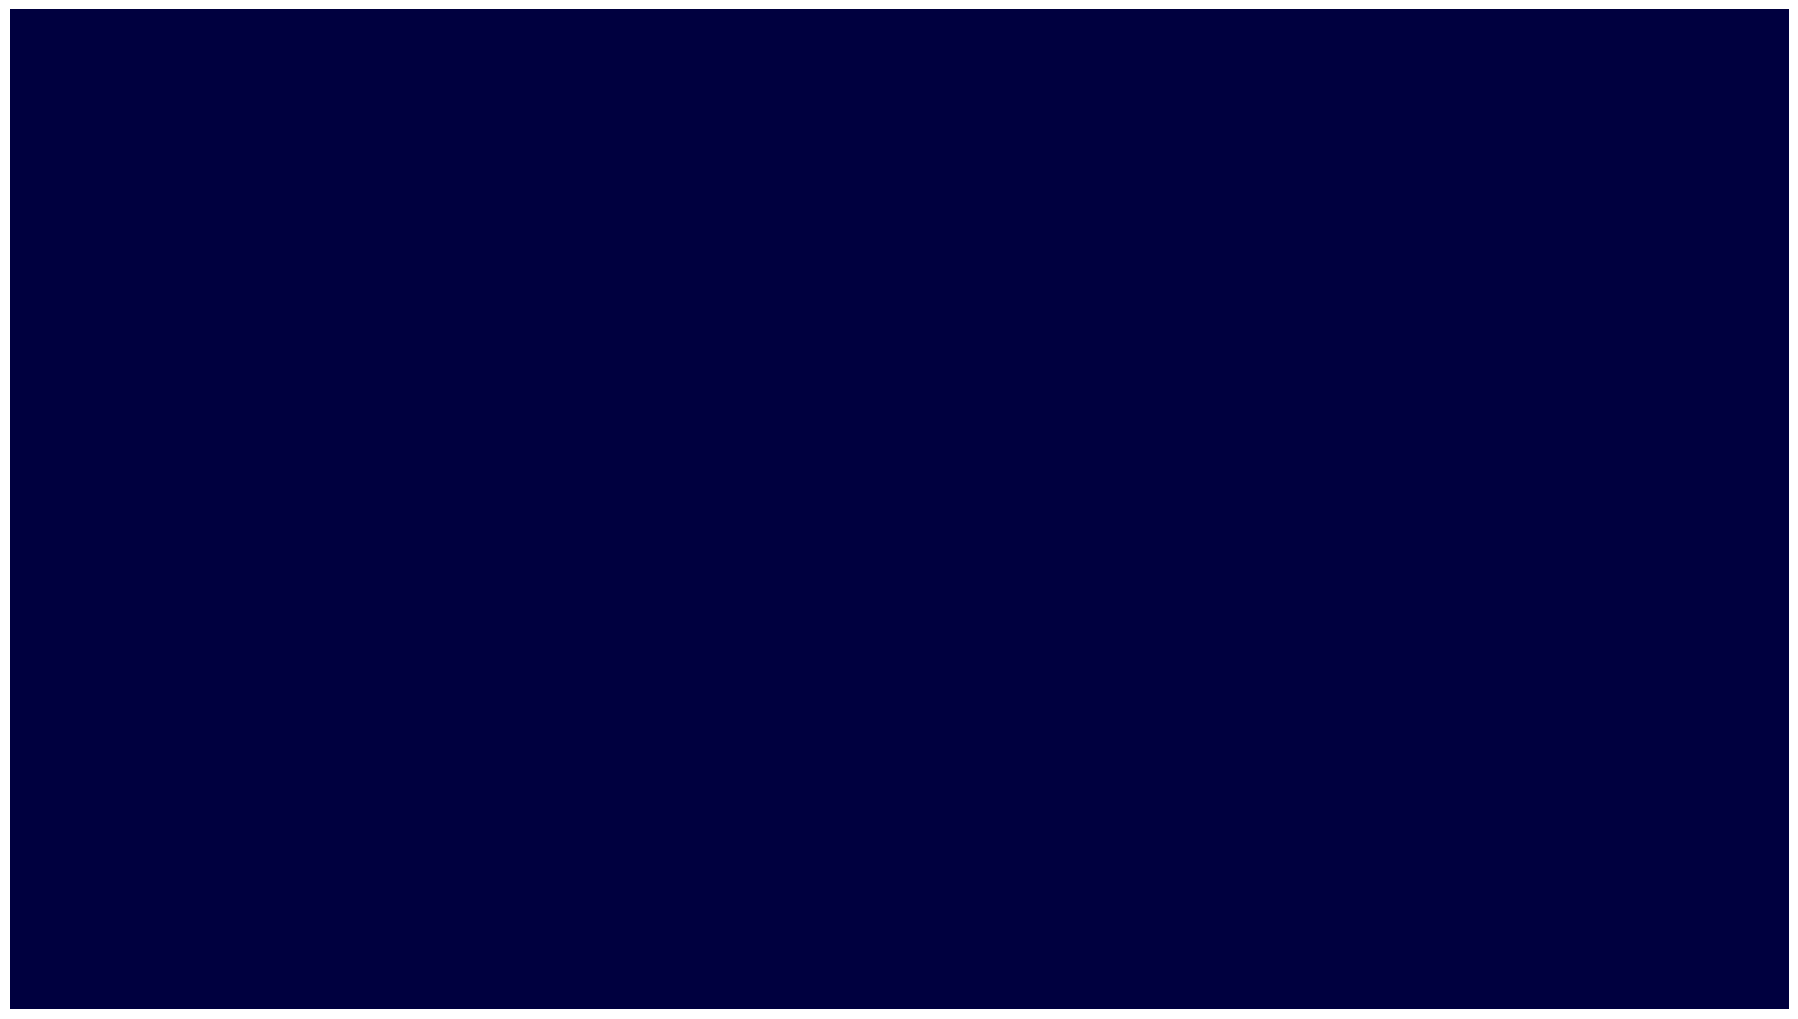

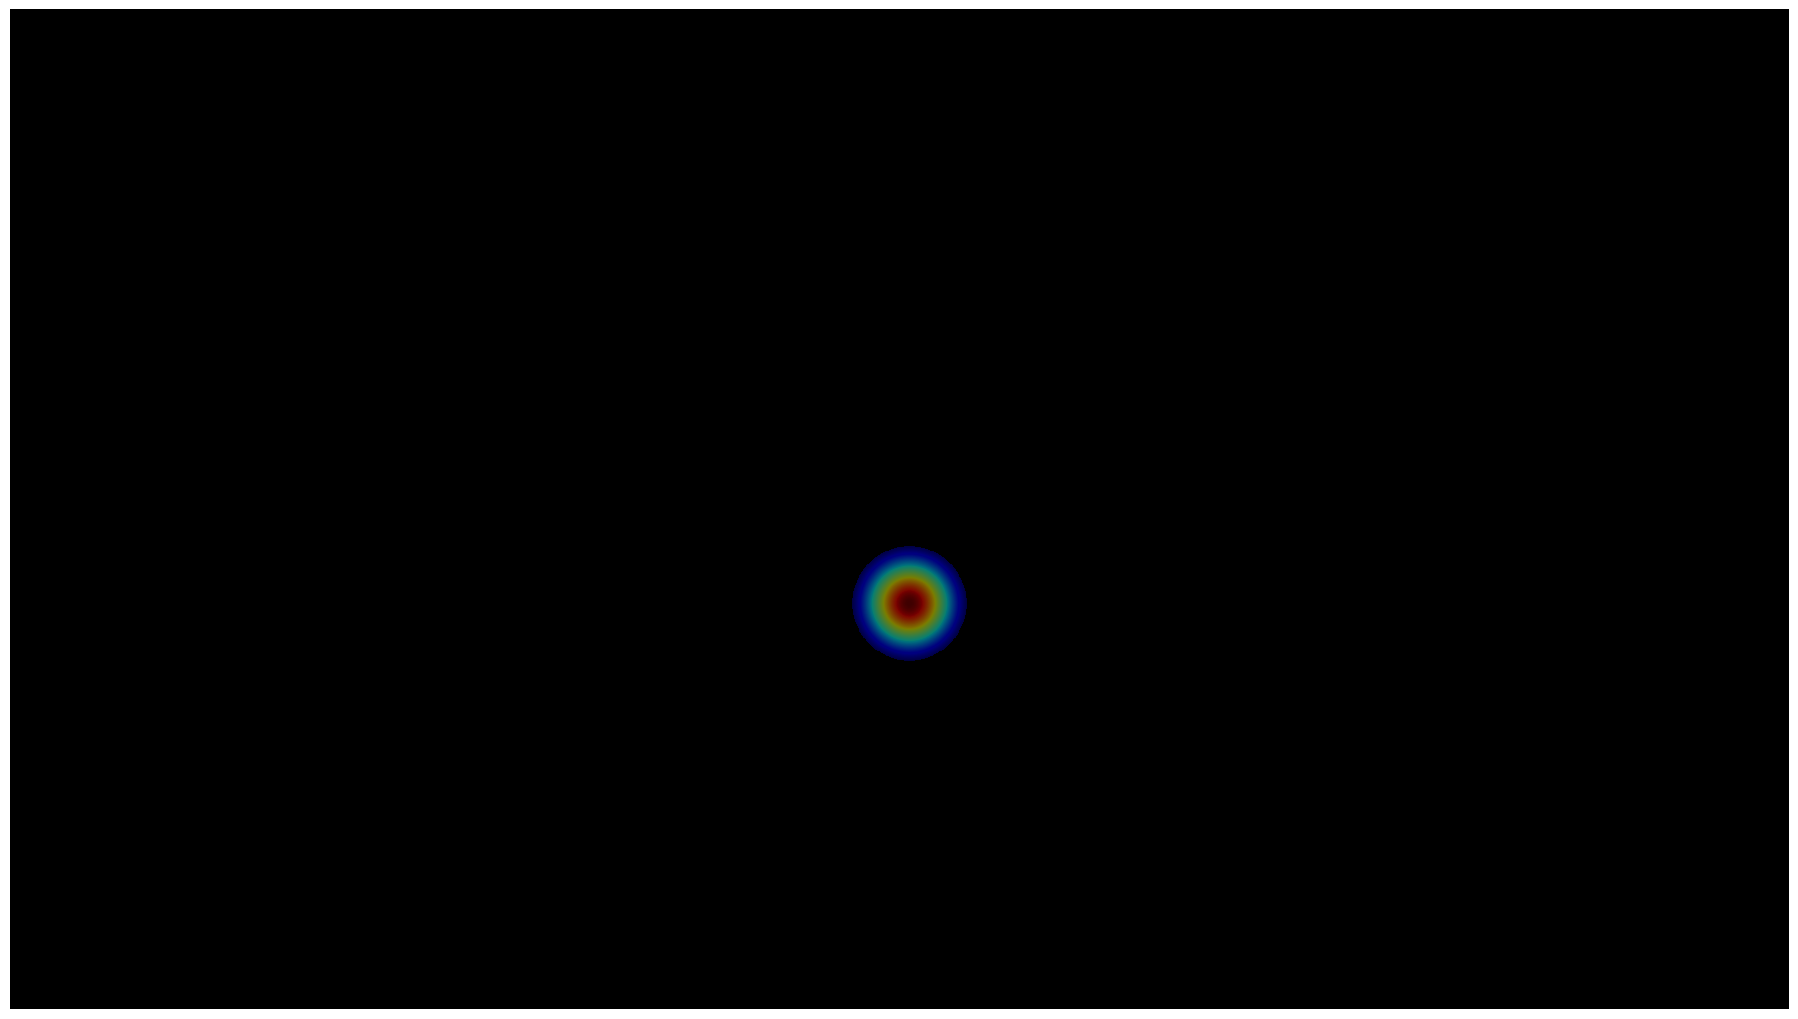

In [10]:
### Plot perceived noise_sample vs inattention

# parameters
partic_id = 'G036'
game_nr   = 16
trials    = np.arange(1,16,1)
dispsize  = (1919,1079) # (px,px) size of screen 

#initialize
x_cross_list,y_cross_list, center_x_list,center_y_list = [],[],[],[]
trial_success = []
radius_list   = []
#read stimulus data
data = read_data(partic_id,game_nr,phase='stimulus')


for trial_nr in (trials):
    #get crosshair position
    x_cross,y_cross = return_cross_pos(partic_id,game_nr,trial_nr)
    if x_cross!=0:
        ###get centroid
        
        #fixations
        fixations = np.array(data[trial_nr]['events']['Efix'])
        fig_heatmap = draw_heatmap(fixations, dispsize)
        #save heatmap
        fig_heatmap.savefig('img_1.png')

        #feed heatmap to the function
        image_load = cv2.imread('img_1.png',0)
        center,radius,image_out = return_centroid_heatmap(image_load)
        #print(center)
        if center.size!=0:
            #print(center)
            if center.shape[0]>1:
                #print(center.shape)
                center = center[0] #CHANGE LATER!!!
                radius = radius[0]
            #plot center - cross hair distance
            #dist = np.sqrt((x_cross-center[0][0])**2 + (y_cross-center[0][1])**2)
            #plt.scatter(trial_nr,dist)
            x_cross_list.append(x_cross)
            y_cross_list.append(y_cross)
            center_x_list.append(center[0][0])
            center_y_list.append(center[0][1])
            trial_success.append(trial_nr)
            radius_list.append(radius)


IndexError: list index out of range

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


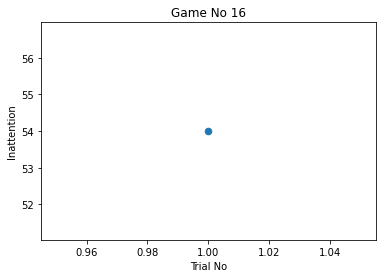

In [16]:
#calculate distances from center point
#dist = np.sqrt((np.array(center_x_list) - np.array(x_cross_list))**2 +
#               (np.array(center_y_list) - np.array(y_cross_list))**2)


#get standard deviation
#load data set
fname = 'dataset_0423.csv'
data_set = load_dataset_properties(fname)
std_dev_list =[]
property_label= 'perc_noise_sample'
subject_id = 36
for trial_nr in trials:
    #check if successful trial
    if trial_nr in trial_success:
        std_dev = return_property_value(data_set,subject_id, game_nr+1,trial_nr,property_label)
        std_dev_list.append(std_dev)
        
std_dev_list = np.array(std_dev_list).astype(float)#/max(std_dev_list)

##plot the non-empty trials
fig,ax = plt.subplots()
for i,trial_nr in enumerate(trial_success):
    ax.plot(trial_nr,radius[i],'-o',markersize=std_dev_list[i])
    #print(dist[i],trial_nr)
    title = 'Game No {}'.format(game_nr)
    ax.set_title(title)
    ax.set_xlabel('Trial No')
    ax.set_ylabel('Inattention')
    
fig.savefig(title+'.png')

### Sija's Code

In [20]:
# analysis script for eye tracking project
#
# version 4 (Apr 2021)
#
# looks all the data from Start to End

__author__ = "Sijamini Baskaralingam"

# native
import os

# custom
from edfreader import read_edf
from gazeplotter import draw_fixations, draw_heatmap, draw_scanpath, draw_raw

# external
import numpy


# # # # #
# CONSTANTS

# PARTICIPANTS
PP = str(input("participant ID?: "))
PPS = [PP+"_1", PP+"_2", PP+"_3", PP+"_4", PP+"_5", PP+"_6", PP+"_7", PP+"_8", PP+"_9", PP+"_10", PP+"_11", PP+"_12", PP+"_13", PP+"_14", PP+"_15", PP+"_16"]
print(PPS)

# DIRECTORIES
# paths
__file__ = 'C:\\Users\\adith\\OneDrive\\Documents\\Courses\\ETH\\Neural Systems\\Course Project\\pygazeanalyser\\data'
DIR = os.path.dirname(__file__)
IMGDIR = os.path.join(DIR, 'imgs')
DATADIR = os.path.join(DIR, 'data')
PLOTDIR = os.path.join(DIR, 'plots')
OUTPUTFILENAME = os.path.join(DIR, "output.txt")
# check if the image directory exists
if not os.path.isdir(IMGDIR):
	raise Exception("ERROR: no image directory found; path '%s' does not exist!" % IMGDIR)
# check if the data directory exists
if not os.path.isdir(DATADIR):
	raise Exception("ERROR: no data directory found; path '%s' does not exist!" % DATADIR)
# check if output directorie exist; if not, create it
if not os.path.isdir(PLOTDIR):
	os.mkdir(PLOTDIR)

# DATA FILES
SEP = '\t' # value separator
EDFSTART = "START" # EDF file trial start message
EDFSTOP = "END" # EDF file trial end message
TRIALORDER = [EDFSTART, 'image online','image offline', EDFSTOP]
INVALCODE = 0.0 # value coding invalid data

# EXPERIMENT SPECS
DISPSIZE = (1919,1079) # (px,px)
SCREENSIZE = (53.3,29.9) # (cm,cm)
SCREENDIST = 27 # cm
PXPERCM = numpy.mean([DISPSIZE[0]/SCREENSIZE[0],DISPSIZE[1]/SCREENSIZE[1]]) # px/cm


# # # # #
# READ FILES

# loop through all participants
for ppname in PPS:
	
	print("starting data analysis for participant '%s'" % (ppname))

	# BEHAVIOUR
	#print("loading behavioural data")
	
	# path
	#fp = os.path.join(DATADIR, '%s.txt' % ppname)
	
	# open the file
	#fl = open(fp, 'r')
	
	# read the file content
	#data = fl.readlines()
	
	# close the file
	#fl.close()
	
	# separate header from rest of file
	#header = data.pop(0)
	#header = header.replace('\n','').replace('\r','').replace('"','').split(SEP)
	
	# process file contents
	#for i in range(len(data)):
	#	data[i] = data[i].replace('\n','').replace('\r','').replace('"','').split(SEP)
	
	# GAZE DATA
	print("loading gaze data")
	
	# path
	fp = os.path.join(DATADIR, '%s.asc' % ppname)
	
	# check if the path exist
	if not os.path.isfile(fp):
		# if not, check if the EDF exists
		edfp = os.path.join(DATADIR, '%s.edf' % ppname)
		if os.path.isfile(edfp):
			# if it does, convert if usinf edf2asc.exe
			os.system("edf2asc %s" % edfp)
			# load ASCII
			fp = os.path.join(DATADIR, '%s.asc' % ppname)
		# if it does not exist, raise an exception
		else:
			raise Exception("No eye data file (neither ASC, nor EDF) file found for participant '%s' (tried paths:\nASC: %s\nEDF: %s" % (ppname, fp, edfp))
	
	# read the file
	#edfdata[trialnr]['time'] = list of timestamps in trialnr
	#edfdata[trialnr]['size'] = list of pupil size samples in trialnr
	edfdata = read_edf(fp, EDFSTART, stop=EDFSTOP, missing=INVALCODE, debug=False)
	
	# NEW OUTPUT DIRECTORIES
	# create a new output directory for the current participant
	pplotdir = os.path.join(PLOTDIR, ppname)
	# check if the directory already exists
	if not os.path.isdir(pplotdir):
		# create it if it doesn't yet exist
		os.mkdir(pplotdir)


	# # # # #
	# PLOTS
	
	print("plotting gaze data")

        # load image name, saccades, and fixations
	#imgname = data[trialnr][header.index("image")]
	imgname=None
	saccades=[]
	fixations=[]

	# loop through trials
	for trialnr in range(0,16):
		saccades_temp = edfdata[trialnr]['events']['Esac'] # [starttime, endtime, duration, startx, starty, endx, endy]
		fixations_temp = edfdata[trialnr]['events']['Efix'] # [starttime, endtime, duration, endx, endy]
		saccades = saccades + saccades_temp
		fixations = fixations + fixations_temp
		print("Saccades: ", saccades)
		print("Fixation: ", fixations)
		
	# paths
	#imagefile = os.path.join(IMGDIR,imgname)
	imagefile = None
	#rawplotfile = os.path.join(pplotdir, "raw_data_%s_%d" % (ppname,trialnr))
	#scatterfile = os.path.join(pplotdir, "fixations_%s_%d" % (ppname,trialnr))
	#scanpathfile =  os.path.join(pplotdir, "scanpath_%s_%d" % (ppname,trialnr))
	heatmapfile = os.path.join(pplotdir, "heatmap_%s_%d" % (ppname,trialnr))
	
	# raw data points
	#draw_raw(edfdata[trialnr]['x'], edfdata[trialnr]['y'], DISPSIZE, imagefile=imagefile, savefilename=rawplotfile)

	# fixations
	#draw_fixations(fixations, DISPSIZE, imagefile=imagefile, durationsize=True, durationcolour=False, alpha=0.5, savefilename=scatterfile)
	
	# scanpath
	#draw_scanpath(fixations, saccades, DISPSIZE, imagefile=imagefile, alpha=0.5, savefilename=scanpathfile)

	# heatmap		
	draw_heatmap(fixations, DISPSIZE, imagefile=imagefile, durationweight=True, alpha=0.5, savefilename=heatmapfile)


KeyboardInterrupt: Interrupted by user